In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime

import matplotlib.dates as mdates
from datetime import timedelta

import warnings
warnings.filterwarnings("ignore")

# Import data

In [2]:
df = pd.read_csv('./../data-workfile/search-and-bookings.csv', index_col='Unnamed: 0')

In [3]:
df.head()

search_log_session_id                   uuid  session_id utm_source  \
0                   4034  1145549807.1726611234  1726611549         na   
1                   4037  2039466988.1726611511  1726611615   facebook   
2                   4069  1556994523.1726611965  1726612033     google   
3                   4034  1145549807.1726611234  1726611549         na   
4                   4102   901475575.1726612653  1726612722     google   

  utm_medium utm_campaign hotel_id  search_log_id         utc_datetime  \
0  (not set)           na  hotel_1         112645  2024-09-17 22:19:09   
1        cpc   other_camp  hotel_1         112648  2024-09-17 22:20:15   
2        cpc          NaN  hotel_1         112680  2024-09-17 22:27:13   
3  (not set)           na  hotel_1         112682  2024-09-17 22:28:30   
4        cpc          NaN  hotel_1         112714  2024-09-17 22:38:42   

  lang_code  ... ROOMHH_room_price_min ROOMHH_room_price_max pieces  \
0        hu  ...                   NaN                   NaN    NaN   
1        hu  ...                   NaN                   NaN    NaN   
2        de  ...                   NaN                   NaN    NaN   
3        hu  ...                   NaN                   NaN    NaN   
4        en  ...                684.25                771.19    NaN   

   sum_price  total_price_final_y  rooms_total_price  upsell_total_price  \
0        NaN                  NaN                NaN                 NaN   
1        NaN                  NaN                NaN                 NaN   
2        NaN                  NaN                NaN                 NaN   
3        NaN                  NaN                NaN                 NaN   
4        NaN                  NaN                NaN                 NaN   

   vouchers_total_price  loyalty_discount_total  redeemed_loyalty_points_total  
0                   NaN                     NaN                            NaN  
1                   NaN                     NaN                            NaN  
2                   NaN                     NaN                            NaN  
3                   NaN                     NaN                            NaN  
4                   NaN                     NaN                            NaN  

[5 rows x 52 columns]

In [4]:
df.columns

Index(['search_log_session_id', 'uuid', 'session_id', 'utm_source',
       'utm_medium', 'utm_campaign', 'hotel_id', 'search_log_id',
       'utc_datetime', 'lang_code', 'currency', 'arrival', 'departure', 'days',
       'nights', 'adults', 'children', 'conversion', 'search_log_room_id',
       'sel_num_of_rooms', 'picked_price_median', 'picked_room', '0_age',
       '1_age', '2_age', '3_age', '4_age', 'baby_bed', 'ROOMAA_room_price_min',
       'ROOMAA_room_price_max', 'ROOMBB_room_price_min',
       'ROOMBB_room_price_max', 'ROOMCC_room_price_min',
       'ROOMCC_room_price_max', 'ROOMDD_room_price_min',
       'ROOMDD_room_price_max', 'ROOMEE_room_price_min',
       'ROOMEE_room_price_max', 'ROOMFF_room_price_min',
       'ROOMFF_room_price_max', 'ROOMGG_room_price_min',
       'ROOMGG_room_price_max', 'ROOMHH_room_price_min',
       'ROOMHH_room_price_max', 'pieces', 'sum_price', 'total_price_final_y',
       'rooms_total_price', 'upsell_total_price', 'vouchers_total_price',
      

In [5]:
# rename a cloumn
df.rename(columns={'total_price_final_y':'total_price_final'}, inplace=True)

In [6]:
# import ppc spending data 
ppc_data = pd.read_csv('./../data-workfile/ppc_performance.csv', index_col='Unnamed: 0')

In [7]:
# read occupancy data
occupancy = pd.read_csv('./../data-workfile/daily_occupancy.csv', index_col='Unnamed: 0')

# Feature engineering

- Currency conversion
- variable type conversion
- Generate new variables

### Currency conversion

In [8]:
# currency conversion

# ccrape down the EUR exchange rate data from MNB's webpage

import requests
from bs4 import BeautifulSoup

# Define the URL
url = 'https://www.mnb.hu/arfolyam-tablazat?deviza=rbCurrencyActual&devizaSelected=EUR&datefrom=2024.09.17.&datetill=2024.10.18.&order=1'

# Fetch the page content
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

table = soup.find('table') 

# rows into a table
table_data = []
for row in table.find_all('tr'):
    cells = row.find_all(['td', 'th'])
    table_data.append([cell.get_text(strip=True) for cell in cells])

eur_price = pd.DataFrame(table_data[1:], columns=table_data[0])  # first row to header

eur_price = eur_price.drop(index=[0,1]).reset_index()

eur_price = eur_price.rename(columns={'':'date'})[['date','EUR']]

In [9]:
# dates to YYYY-MM-DD format

hungarian_to_english = {
    'január': 'January', 'február': 'February', 'március': 'March', 'április': 'April',
    'május': 'May', 'június': 'June', 'július': 'July', 'augusztus': 'August',
    'szeptember': 'September', 'október': 'October', 'november': 'November', 'december': 'December',
    'hétfő': 'Monday', 'kedd': 'Tuesday', 'szerda': 'Wednesday', 'csütörtök': 'Thursday',
    'péntek': 'Friday', 'szombat': 'Saturday', 'vasárnap': 'Sunday'
}

def convert_hungarian_date(date_str):
    for hun, eng in hungarian_to_english.items():
        date_str = date_str.replace(hun, eng)
    date_obj = datetime.strptime(date_str, '%Y. %B %d., %A')
    return date_obj.strftime('%Y-%m-%d')

# apply the function to the df column
eur_price['date'] = eur_price['date'].apply(convert_hungarian_date)
eur_price['date'] = pd.to_datetime(eur_price['date'])

In [10]:
# Convert date column to datetime and value column to numeric
eur_price.set_index('date', inplace=True)

# Create a complete date range from the first to the last date
date_range = pd.date_range(start=eur_price.index.min(), end=eur_price.index.max(), freq='D')

# Reindex the DataFrame to include all dates in the range
eur_price = eur_price.reindex(date_range)

# fill nans (weekends and holidays)
eur_price['EUR'] = eur_price['EUR'].fillna(method='ffill')

In [11]:
# define a conversion function
def conversion(x):
    rate = eur_price[eur_price.index == x]['EUR'].values
    if rate:
        return float(rate[0].replace(',', '.')) 
    else:
        return None

In [12]:
df['simple_date'] = pd.to_datetime(df['utc_datetime'], format='%Y-%m-%d %H:%M:%S').dt.strftime('%Y-%m-%d')

# Set the default conversion rate to 1
df['conversion_rate'] = 1

# Update 'conversion_rate' only where 'currency' is 'EUR'
df.loc[df['currency'] == 'EUR', 'conversion_rate'] = df.loc[df['currency'] == 'EUR', 'simple_date'].apply(conversion)

In [13]:
# mean room price for the entire duration
df['mean_room_price'] =  df['rooms_total_price']/df['sel_num_of_rooms']

In [14]:
# execute the conversions
df['total_price_final'] = df['conversion_rate']*df['total_price_final']
df['rooms_total_price'] = df['conversion_rate']*df['rooms_total_price']
df['upsell_total_price'] = df['conversion_rate']*df['upsell_total_price']
df['vouchers_total_price'] = df['conversion_rate']*df['vouchers_total_price']
df['loyalty_discount_total'] = df['conversion_rate']*df['loyalty_discount_total']
df['mean_room_price'] = df['conversion_rate']*df['mean_room_price']

### Feature engineering

In [15]:
# generate new variables for offered prices
df['offered_price_median'] = (df[['ROOMAA_room_price_min', 'ROOMAA_room_price_max','ROOMBB_room_price_min', 'ROOMBB_room_price_max','ROOMCC_room_price_min', 'ROOMCC_room_price_max','ROOMDD_room_price_min', 'ROOMDD_room_price_max','ROOMEE_room_price_min', 'ROOMEE_room_price_max',
       'ROOMFF_room_price_min', 'ROOMFF_room_price_max','ROOMGG_room_price_min', 'ROOMGG_room_price_max','ROOMHH_room_price_min', 'ROOMHH_room_price_max']].median(axis=1)/df['nights'])/df['sel_num_of_rooms']
df['offered_price_min'] = (df[['ROOMAA_room_price_min','ROOMBB_room_price_min','ROOMCC_room_price_min','ROOMDD_room_price_min','ROOMEE_room_price_min',
       'ROOMFF_room_price_min','ROOMGG_room_price_min','ROOMHH_room_price_min']].min(axis=1)/df['nights'])/df['sel_num_of_rooms']
df['offered_price_max'] = (df[['ROOMAA_room_price_max', 'ROOMBB_room_price_max', 'ROOMCC_room_price_max', 'ROOMDD_room_price_max', 'ROOMEE_room_price_max',
       'ROOMFF_room_price_max', 'ROOMGG_room_price_max', 'ROOMHH_room_price_max']].max(axis=1)/df['nights'])/df['sel_num_of_rooms']

df['offered_price_median'] = df['offered_price_median'] * df['conversion_rate']
df['offered_price_min'] = df['offered_price_min'] * df['conversion_rate']
df['offered_price_max'] = df['offered_price_max'] * df['conversion_rate']

# drop the unnecessary variables
df.drop(columns=['conversion_rate', 'simple_date'], inplace=True)

In [16]:
# new column, if_children = 1, if children included
df['if_children'] = 0
df['if_children'].loc[df['children'] > 0] = 1

# mean room price per night and per room
df['total_price_p_night'] = df['mean_room_price']/df['nights']

# to datetime type
df['arrival'] = pd.to_datetime(df['arrival'])
df['departure'] = pd.to_datetime(df['departure'])
df['utc_datetime'] = pd.to_datetime(df['utc_datetime'])

In [17]:
# create flags for weekdays and holidays

import holidays
hungarian_holidays = holidays.Hungary()

df['day_of_week'] = df['utc_datetime'].dt.dayofweek + 1
df['is_holiday'] = ((df['day_of_week'].isin([6, 7])) | (df['utc_datetime'].dt.date.apply(lambda x: x in hungarian_holidays)))

In [18]:
# perform a segmentation based on search time
# extract date information
    # - day of the week
    # - weekend and public holiday or not
    # - time of the day
    
# time of day
def get_time_of_day(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour < 24:
        return 'evening'
    else:
        return 'night'

df['time_of_day'] = df['utc_datetime'].dt.hour.apply(get_time_of_day)

In [19]:
# extract information from the arrival and departure information
# time netween arrival and booking
df['lead_time'] = (df['arrival'] - df['utc_datetime']).dt.days

In [20]:
# segmentation according to lead time

# group lead time into categories
def lead_time_category(days):
    if days <= 7:
        return 'last_minute'
    elif days <= 30:
        return 'short_term'
    elif days <= 90:
        return 'medium_term'
    else:
        return 'long_term'
df['lead_time_category'] = df['lead_time'].apply(lead_time_category)

In [21]:
# create new features according to date information

# day of the week for arrival and departure
df['arrival_day_of_week'] = df['arrival'].dt.dayofweek + 1
df['departure_day_of_week'] = df['departure'].dt.dayofweek + 1

# holiday or weekend flag for arrival and departure
df['arrival_is_holiday'] = (df['arrival_day_of_week'].isin([6, 7]) | (df['arrival'].dt.date.apply(lambda x: x in hungarian_holidays)))
df['departure_is_holiday'] = (df['departure_day_of_week'].isin([6, 7]) | (df['departure'].dt.date.apply(lambda x: x in hungarian_holidays)))


# create new variable for the entire stay period

#generate a list of dates for each stay period
df['stay_dates'] = df.apply(lambda x: pd.date_range(x['arrival'], x['departure'], freq='D'), axis=1)
# check if stay includes a weekend or a public holiday
df['stay_includes_weekend'] = df['stay_dates'].apply(lambda dates: any(((date.weekday() in [5, 6]) | (date in hungarian_holidays)) for date in dates))
# extract all unique days of the week included in the stay period
df['days_of_week_in_stay'] = df['stay_dates'].apply(lambda dates: {date.weekday() + 1 for date in dates})
# count the number of specific weekdays
df['num_saturdays'] = df['stay_dates'].apply(lambda dates: sum(date.weekday() == 5 for date in dates))
df['num_sundays'] = df['stay_dates'].apply(lambda dates: sum(date.weekday() == 6 for date in dates))

df.drop(columns='days', inplace=True)

In [22]:
# import Hungarian public holidays
public_holidays = [
    "2024-10-23",  # Revolution Day
    "2024-11-01",  # All Saints' Day
    "2024-12-25",  # Christmas Day
    "2024-12-26",  # Second Day of Christmas
    "2025-01-01",  # New Year's Day
    "2025-03-15",  # Revolution Memorial Day
]
# public holidays to datetime
public_holidays = pd.to_datetime(public_holidays)

In [23]:
# add mean children age column
df['children_age_mean'] = df[['0_age', '1_age', '2_age', '3_age', '4_age']].mean(axis=1)

### RFM-based segmentation

In [24]:
# RFM-based segmentation, based on: mean_room_price, days
# define segment boundaries based low duration = mean-1*std, medium duration = mean+-1*std, long duration = mean+1*std

df['rfm_monetary_score'] = pd.qcut(df['total_price_p_night'], 4, labels=['Low', 'Medium', 'High', 'Premium'])
df['rfm_duration_score'] = pd.cut(df['nights'], bins=[min(df['nights'])] + list([2, 4]) + [max(df['nights'])], labels=['1','2-3','4-9'] ,right=True)

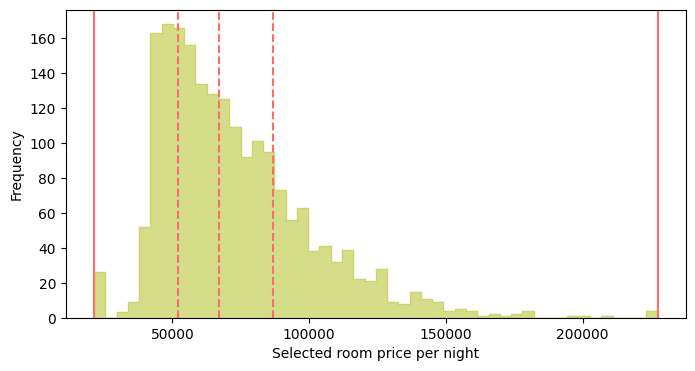

In [25]:
# plot the segment boundaries for monetary segmentation

fig, ax = plt.subplots(1,1, figsize=(8,4))
sns.histplot(data=df['total_price_p_night'], bins=50, color='#CCD56B', alpha=0.8, element="step")
plt.xlabel('Selected room price per night')
plt.ylabel('Frequency')
# add dashed lines
plt.axvline(df['total_price_p_night'].quantile(0),color='#FF6D69', linestyle='-')
plt.axvline(df['total_price_p_night'].quantile(0.25),color='#FF6D69', linestyle='--')
plt.axvline(df['total_price_p_night'].quantile(0.50),color='#FF6D69', linestyle='--')
plt.axvline(df['total_price_p_night'].quantile(0.75),color='#FF6D69', linestyle='--')
plt.axvline(df['total_price_p_night'].quantile(1),color='#FF6D69', linestyle='-')

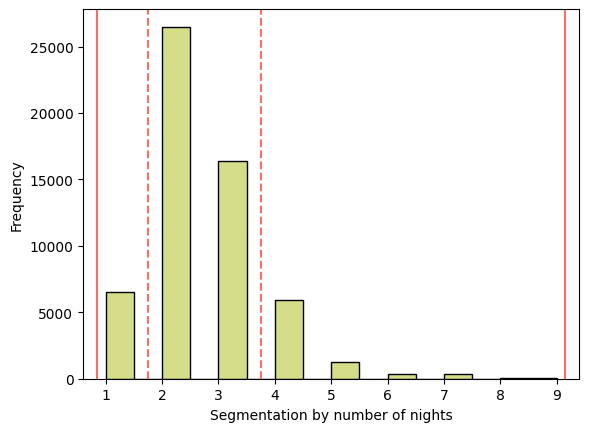

In [26]:
# plot the segment boundaries for duration segmentation

fig, ax = plt.subplots(1,1)
sns.histplot(data=df[df['nights']>0]['nights'], color='#CCD56B', alpha=0.8, binwidth=0.5) #, bins=9, element="step")
plt.xlabel('Segmentation by number of nights')
plt.ylabel('Frequency')
#dashed lines
plt.axvline(0.85,color='#FF6D69', linestyle='-')
plt.axvline(1.75,color='#FF6D69', linestyle='--')
plt.axvline(3.75,color='#FF6D69', linestyle='--')
plt.axvline(9.15,color='#FF6D69', linestyle='-')

### Final rearrangement of columns

In [24]:
# rearrange columns
df = df[['search_log_session_id', 'search_log_id', 'session_id', 'search_log_room_id','uuid', 'utc_datetime', 'utm_source',
   'utm_medium', 'utm_campaign','lang_code', 'currency', 'arrival', 'departure', 'nights',
    'adults', 'children', 'if_children',  'children_age_mean', 'conversion',
    'sel_num_of_rooms', 'mean_room_price', 'total_price_p_night','picked_room', 'baby_bed', 'pieces', 'sum_price', 'total_price_final',
    'rooms_total_price', 'upsell_total_price', 'vouchers_total_price',
    'loyalty_discount_total', 'redeemed_loyalty_points_total', 'hotel_id', 'rfm_monetary_score', 'rfm_duration_score', '0_age',
    '1_age', '2_age', '3_age', '4_age', 'ROOMAA_room_price_min','offered_price_median','offered_price_min','offered_price_max',
    'ROOMAA_room_price_max', 'ROOMBB_room_price_min','ROOMBB_room_price_max', 'ROOMCC_room_price_min',
    'ROOMCC_room_price_max', 'ROOMDD_room_price_min','ROOMDD_room_price_max', 'ROOMEE_room_price_min',
    'ROOMEE_room_price_max', 'ROOMFF_room_price_min','ROOMFF_room_price_max', 'ROOMGG_room_price_min',
    'ROOMGG_room_price_max', 'ROOMHH_room_price_min','ROOMHH_room_price_max', 'day_of_week',
    'is_holiday', 'time_of_day', 'stay_dates', 'lead_time',
    'lead_time_category', 'arrival_day_of_week', 'departure_day_of_week',
    'arrival_is_holiday', 'departure_is_holiday', 'stay_includes_weekend',
    'days_of_week_in_stay', 'num_saturdays', 'num_sundays']]

In [37]:
# create sub-tables for subsequent analysis
hotel1 = df[df['hotel_id']=='hotel_1'].drop(columns='hotel_id').copy()
hotel2 = df[df['hotel_id']=='hotel_2'].drop(columns='hotel_id').copy()
hotel3 = df[df['hotel_id']=='hotel_3'].drop(columns='hotel_id').copy()
df_unique = df.drop_duplicates(subset='uuid', keep='last')

In [38]:
df.columns

Index(['search_log_session_id', 'uuid', 'session_id', 'utm_source',
       'utm_medium', 'utm_campaign', 'hotel_id', 'search_log_id',
       'utc_datetime', 'lang_code', 'currency', 'arrival', 'departure',
       'nights', 'adults', 'children', 'conversion', 'search_log_room_id',
       'sel_num_of_rooms', 'picked_price_median', 'picked_room', '0_age',
       '1_age', '2_age', '3_age', '4_age', 'baby_bed', 'ROOMAA_room_price_min',
       'ROOMAA_room_price_max', 'ROOMBB_room_price_min',
       'ROOMBB_room_price_max', 'ROOMCC_room_price_min',
       'ROOMCC_room_price_max', 'ROOMDD_room_price_min',
       'ROOMDD_room_price_max', 'ROOMEE_room_price_min',
       'ROOMEE_room_price_max', 'ROOMFF_room_price_min',
       'ROOMFF_room_price_max', 'ROOMGG_room_price_min',
       'ROOMGG_room_price_max', 'ROOMHH_room_price_min',
       'ROOMHH_room_price_max', 'pieces', 'sum_price', 'total_price_final',
       'rooms_total_price', 'upsell_total_price', 'vouchers_total_price',
       'loyalty_

### Work with occupancy table

In [39]:
hotel1_unique = hotel1.drop_duplicates(subset='uuid', keep='last')
hotel2_unique = hotel2.drop_duplicates(subset='uuid', keep='last')
hotel3_unique = hotel3.drop_duplicates(subset='uuid', keep='last')

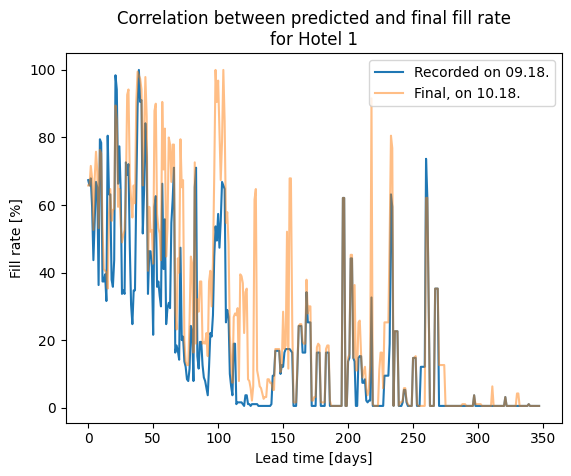

In [40]:
# check the correlation between predicted and final fill rate
occupancy[(occupancy['hotel_id']=='hotel_1') & (occupancy['recording_date']=='2024-09-18')]['fill_rate'].plot()
occupancy[(occupancy['hotel_id']=='hotel_1') & (occupancy['recording_date']=='2024-10-18')]['fill_rate'].reset_index(drop=True).plot(alpha=0.5)
plt.title('Correlation between predicted and final fill rate''\n''for Hotel 1')
plt.ylabel('Fill rate [%]')
plt.xlabel('Lead time [days]')
plt.legend(['Recorded on 09.18.','Final, on 10.18.'])

In [41]:
# mean occupancy for the subject date:

occupancy_hotel_1 = occupancy[occupancy['hotel_id']=='hotel_1'][['subject_date','fill_rate','days_until_stay']].groupby(by='subject_date').mean().reset_index().join(
    hotel1_unique[['lead_time','conversion']].groupby(by='lead_time').mean(), on='days_until_stay', how='inner')
occupancy_hotel_2 = occupancy[occupancy['hotel_id']=='hotel_2'][['subject_date','fill_rate','days_until_stay']].groupby(by='subject_date').mean().reset_index().join(
    hotel2_unique[['lead_time','conversion']].groupby(by='lead_time').mean(), on='days_until_stay', how='inner')
occupancy_hotel_3 = occupancy[occupancy['hotel_id']=='hotel_3'][['subject_date','fill_rate','days_until_stay']].groupby(by='subject_date').mean().reset_index().join(
    hotel3_unique[['lead_time','conversion']].groupby(by='lead_time').mean(), on='days_until_stay', how='inner')

In [42]:
# to datetime type
occupancy_hotel_1['subject_date'] = pd.to_datetime(occupancy_hotel_1['subject_date'])
occupancy_hotel_2['subject_date'] = pd.to_datetime(occupancy_hotel_2['subject_date'])
occupancy_hotel_3['subject_date'] = pd.to_datetime(occupancy_hotel_3['subject_date'])

# Analysis

## Basic funnel analysis for an overview

In [43]:
# prepare data for funnel analysis

# hotel 1
hotel1 = df[df['hotel_id']=='hotel_1'].drop(columns='hotel_id').copy()
hotel1['utc_datetime'] = pd.to_datetime(hotel1['utc_datetime'], format='%Y-%m-%d %H:%M:%S').dt.strftime('%Y-%m-%d')
hotel1 = hotel1[hotel1['utc_datetime'] > '2024-09-17'].copy()
# keep the uniqe users
hotel1.drop_duplicates(subset='uuid', keep='last', inplace=True)  # there are some guests, who booked rooms several times (61 pieces in total). I keep the last booking

# hotel 2
hotel2 = df[df['hotel_id']=='hotel_2'].drop(columns='hotel_id').copy()
hotel2['utc_datetime'] = pd.to_datetime(hotel2['utc_datetime'], format='%Y-%m-%d %H:%M:%S').dt.strftime('%Y-%m-%d')
hotel2 = hotel2[hotel2['utc_datetime'] > '2024-09-17'].copy()
# keep the uniqe users
hotel2.drop_duplicates(subset='uuid', keep='last', inplace=True)  # there are some guests, who booked rooms several times (61 pieces in total). I keep the last booking

# hotel 3
hotel3 = df[df['hotel_id']=='hotel_3'].drop(columns='hotel_id').copy()
hotel3['utc_datetime'] = pd.to_datetime(hotel3['utc_datetime'], format='%Y-%m-%d %H:%M:%S').dt.strftime('%Y-%m-%d')
hotel3 = hotel3[hotel3['utc_datetime'] > '2024-09-17'].copy()
# keep the uniqe users
hotel3.drop_duplicates(subset='uuid', keep='last', inplace=True)  # there are some guests, who booked rooms several times (61 pieces in total). I keep the last booking

In [44]:
# create funnel data or each hotel
funnel1 = list()
funnel1.append(len(hotel1))
funnel1.append(len(hotel1[(hotel1[['ROOMAA_room_price_min','ROOMBB_room_price_min','ROOMCC_room_price_min','ROOMDD_room_price_min','ROOMEE_room_price_min','ROOMFF_room_price_min','ROOMGG_room_price_min','ROOMHH_room_price_min']].notna().sum(axis=1))>0])) # where there was at least 1 offered room
funnel1.append((hotel1['conversion']==1).sum())

funnel2 = list()
funnel2.append(len(hotel2))
funnel2.append(len(hotel2[(hotel2[['ROOMAA_room_price_min','ROOMBB_room_price_min','ROOMCC_room_price_min','ROOMDD_room_price_min','ROOMEE_room_price_min','ROOMFF_room_price_min','ROOMGG_room_price_min','ROOMHH_room_price_min']].notna().sum(axis=1))>0]))
funnel2.append((hotel2['conversion']==1).sum())

funnel3 = list()
funnel3.append(len(hotel3))
funnel3.append(len(hotel3[(hotel3[['ROOMAA_room_price_min','ROOMBB_room_price_min','ROOMCC_room_price_min','ROOMDD_room_price_min','ROOMEE_room_price_min','ROOMFF_room_price_min','ROOMGG_room_price_min','ROOMHH_room_price_min']].notna().sum(axis=1))>0]))
funnel3.append((hotel3['conversion']==1).sum())

In [47]:
fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Funnel(
    y = ["Datepicker site visit", "Room offered", "Room booked"],
    x =  np.array(funnel1)/len(hotel1)*100,
    textposition = "inside",
    textinfo = "percent initial",
    name='Hotel 1'),row=1, col=1)

fig.add_trace(go.Funnel(
    y = ["Datepicker site visit", "Room offered", "Room booked"],
    x =  np.array(funnel2)/len(hotel2)*100,
    textposition = "inside",
    textinfo = "percent initial",
    name='Hotel 2'),row=2, col=1)

fig.add_trace(go.Funnel(
    y = ["Datepicker site visit", "Room offered", "Room booked"],
    x =  np.array(funnel3)/len(hotel3)*100,
    textposition = "inside",
    textinfo = "percent initial",
    name='Hotel 3'),row=3, col=1)


fig.update_layout(
    autosize=False,
    width=700,
    height=900,
    title='Funnel for each Hotel')

In [30]:
# calculate the difference between converted and not converted funnels:
hotel1_not_converted = hotel1[hotel1['conversion']==0]
hotel2_not_converted = hotel2[hotel2['conversion']==0]
hotel3_not_converted = hotel3[hotel3['conversion']==0]

funnel1_n_conv = list()
funnel1_n_conv.append(len(hotel1_not_converted))
funnel1_n_conv.append(len(hotel1_not_converted[(hotel1_not_converted[['ROOMAA_room_price_min','ROOMBB_room_price_min','ROOMCC_room_price_min','ROOMDD_room_price_min','ROOMEE_room_price_min','ROOMFF_room_price_min','ROOMGG_room_price_min','ROOMHH_room_price_min']].notna().sum(axis=1))>0])) # where there was at least 1 offered room
funnel2_n_conv = list()
funnel2_n_conv.append(len(hotel2_not_converted))
funnel2_n_conv.append(len(hotel2_not_converted[(hotel2_not_converted[['ROOMAA_room_price_min','ROOMBB_room_price_min','ROOMCC_room_price_min','ROOMDD_room_price_min','ROOMEE_room_price_min','ROOMFF_room_price_min','ROOMGG_room_price_min','ROOMHH_room_price_min']].notna().sum(axis=1))>0])) # where there was at least 1 offered room
funnel3_n_conv = list()
funnel3_n_conv.append(len(hotel3_not_converted))
funnel3_n_conv.append(len(hotel3_not_converted[(hotel3_not_converted[['ROOMAA_room_price_min','ROOMBB_room_price_min','ROOMCC_room_price_min','ROOMDD_room_price_min','ROOMEE_room_price_min','ROOMFF_room_price_min','ROOMGG_room_price_min','ROOMHH_room_price_min']].notna().sum(axis=1))>0])) # where there was at least 1 offered room

In [31]:
fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Funnel(
    y = ["Datepicker site visit", "Room offered"],
    x =  (np.array(funnel1_n_conv)/len(hotel1_not_converted))*100,
    textposition = "inside",
    textinfo = "percent initial",
    name='Hotel 1'),row=1, col=1)

fig.add_trace(go.Funnel(
    y = ["Datepicker site visit", "Room offered"],
    x =  (np.array(funnel2_n_conv)/len(hotel2_not_converted))*100,
    textposition = "inside",
    textinfo = "percent initial",
    name='Hotel 2'),row=2, col=1)

fig.add_trace(go.Funnel(
    y = ["Datepicker site visit", "Room offered"],
    x =  (np.array(funnel3_n_conv)/len(hotel3_not_converted))*100,
    textposition = "inside",
    textinfo = "percent initial",
    name='Hotel 3'),row=3, col=1)


fig.update_layout(
    autosize=False,
    width=700,
    height=900,
    title='Funnel for each Hotel, where the visitors did NOT convert')

## Lead time related analysis

In [32]:
# Investigate the time-delay between the first datepicker visit and then the booking

# calculate the time difference between the first visit and the booking
return_time = []
for hotel_num in ['hotel_1', 'hotel_2', 'hotel_3']:
    for index, row in df[df['uuid'].duplicated(keep='first') & (df['conversion'] == 1) & (df['hotel_id']==hotel_num)]['uuid'].items():
    
        i_first = df[df['uuid'].duplicated(keep=False) & (df['hotel_id']==hotel_num) & (df['uuid']==row)]['uuid'].index[0]
        i_last = df[df['uuid'].duplicated(keep=False) & (df['hotel_id']==hotel_num) & (df['uuid']==row)]['uuid'].index[-1]

        return_time.append({
            'uuid': row,
            'first_visit': df.loc[i_first, 'utc_datetime'],
            'last_visit': df.loc[i_last, 'utc_datetime'],
            'hotel_id': hotel_num
        })
    
return_time = pd.DataFrame(return_time)
return_time['time_diff'] = (pd.to_datetime(return_time['last_visit'], format='%Y-%m-%d %H:%M:%S') - pd.to_datetime(return_time['first_visit'], format='%Y-%m-%d %H:%M:%S')).dt.total_seconds() / 3600 # in hours

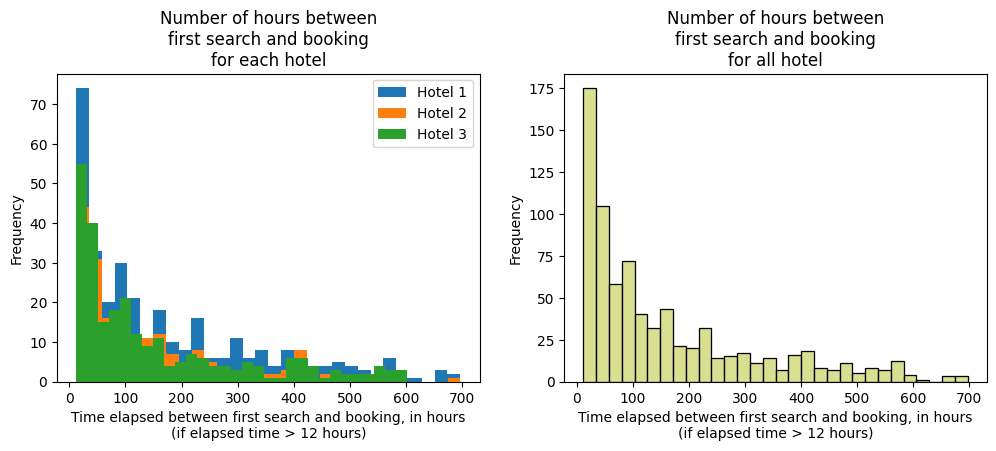

In [33]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
sns.histplot(return_time[(return_time['time_diff']>12)]['time_diff'], bins=30, color='#CCD56B')
plt.xlabel('Time elapsed between first search and booking, in hours''\n''(if elapsed time > 12 hours)')
plt.ylabel('Frequency')
plt.title('Number of hours between''\n''first search and booking''\n''for all hotel')

return_time[(return_time['hotel_id']=='hotel_1') & (return_time['time_diff']>12)]['time_diff'].plot(kind='hist', bins=30, ax=ax1)
return_time[(return_time['hotel_id']=='hotel_2') & (return_time['time_diff']>12)]['time_diff'].plot(kind='hist', bins=30, ax=ax1)
return_time[(return_time['hotel_id']=='hotel_3') & (return_time['time_diff']>12)]['time_diff'].plot(kind='hist', bins=30, ax=ax1)
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Time elapsed between first search and booking, in hours''\n''(if elapsed time > 12 hours)')
ax1.set_title('Number of hours between''\n''first search and booking''\n''for each hotel')
ax1.legend(['Hotel 1','Hotel 2','Hotel 3'])

Text(0.5, 1.0, 'Distribution of Lead time')

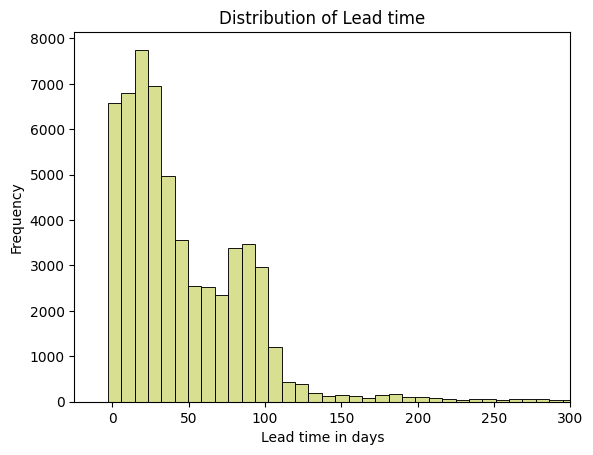

In [34]:
# lead time distribution
sns.histplot(data=df['lead_time'], bins=50, color='#CCD56B')
plt.xlabel('Lead time in days')
plt.ylabel('Frequency')
plt.xlim(right=300)
plt.title('Distribution of Lead time')

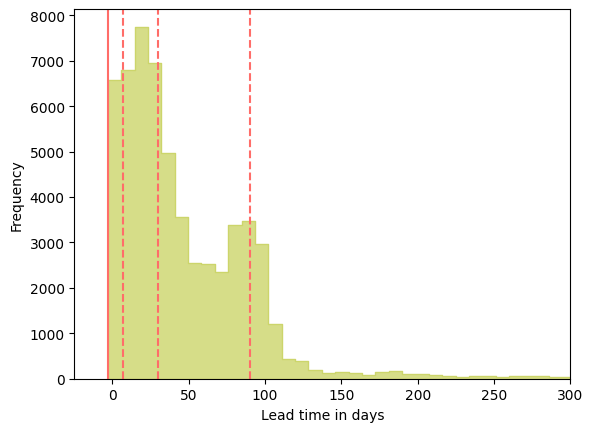

In [35]:
sns.histplot(data=df['lead_time'], bins=50, color='#CCD56B', alpha=0.8, element="step")
plt.xlabel('Lead time in days')
plt.ylabel('Frequency')
plt.xlim(right=300)

#dashed lines
plt.axvline(-3,color='#FF6D69', linestyle='-')
plt.axvline(7,color='#FF6D69', linestyle='--')
plt.axvline(30,color='#FF6D69', linestyle='--')
plt.axvline(90,color='#FF6D69', linestyle='--')

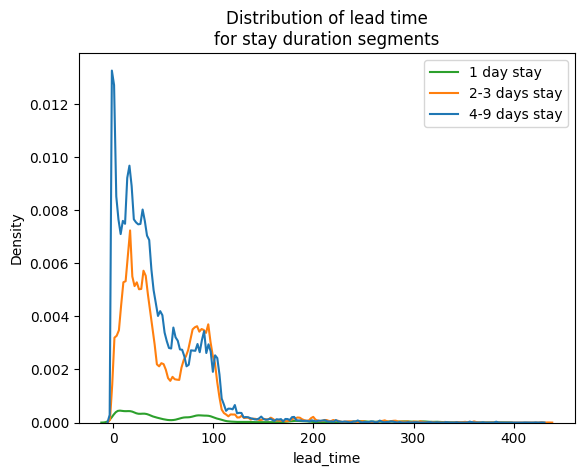

In [36]:
sns.kdeplot(data=df, x='lead_time', bw_adjust=0.2, hue='rfm_duration_score')
plt.title('Distribution of lead time''\n''for stay duration segments')
plt.legend(['1 day stay', '2-3 days stay', '4-9 days stay'])

Text(0.5, 1.0, 'Hotel 3')

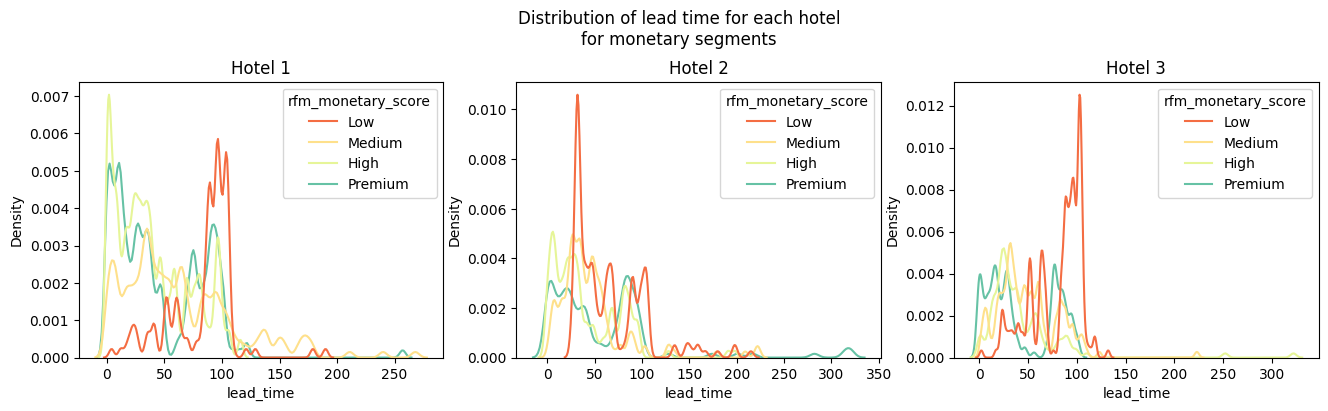

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,4))
fig.subplots_adjust(top=0.8)

sns.kdeplot(ax=ax1, data=df[df['hotel_id']=='hotel_1'], x='lead_time', bw_adjust=0.2, hue='rfm_monetary_score',palette='Spectral')
sns.kdeplot(ax=ax2, data=df[df['hotel_id']=='hotel_2'], x='lead_time', bw_adjust=0.2, hue='rfm_monetary_score',palette='Spectral')
sns.kdeplot(ax=ax3, data=df[df['hotel_id']=='hotel_3'], x='lead_time', bw_adjust=0.2, hue='rfm_monetary_score',palette='Spectral')

fig.suptitle('Distribution of lead time for each hotel''\n''for monetary segments')
ax1.set_title('Hotel 1')
ax2.set_title('Hotel 2')
ax3.set_title('Hotel 3')

Text(0.5, 1.0, 'Variation of lead time as a function of stay duration')

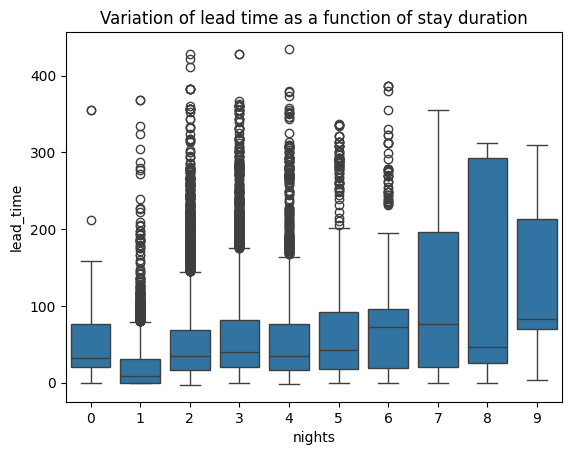

In [38]:
sns.boxplot(data=df, y='lead_time', x='nights')
plt.title('Variation of lead time as a function of stay duration')

Text(0.5, 0.98, 'Variation of lead time as a function of stay duration, for each hotel')

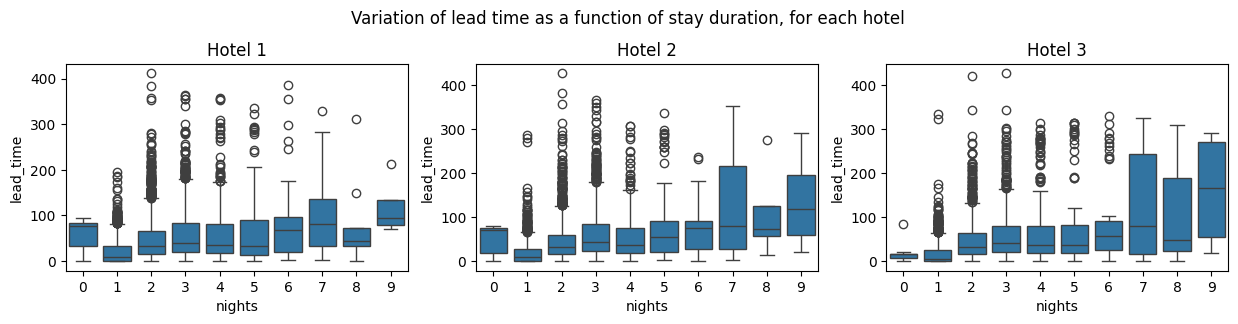

In [39]:
# Hows does the stay duration influences the lead time?
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,3))
fig.subplots_adjust(top=0.8)
sns.boxplot(ax=ax1 ,data=hotel1, y='lead_time', x='nights')
sns.boxplot(ax=ax2 ,data=hotel2, y='lead_time', x='nights')
sns.boxplot(ax=ax3 ,data=hotel3, y='lead_time', x='nights')
ax1.set_title('Hotel 1')
ax2.set_title('Hotel 2')
ax3.set_title('Hotel 3')
fig.suptitle('Variation of lead time as a function of stay duration, for each hotel')

In [40]:
# median lead time as a function of duration time category
hotel1[['rfm_duration_score', 'lead_time']].groupby(by='rfm_duration_score').median()

lead_time
rfm_duration_score           
1                        29.0
2-3                      38.0
4-9                      39.0

Text(0.5, 1.0, 'Lead time as a function of stay duration category')

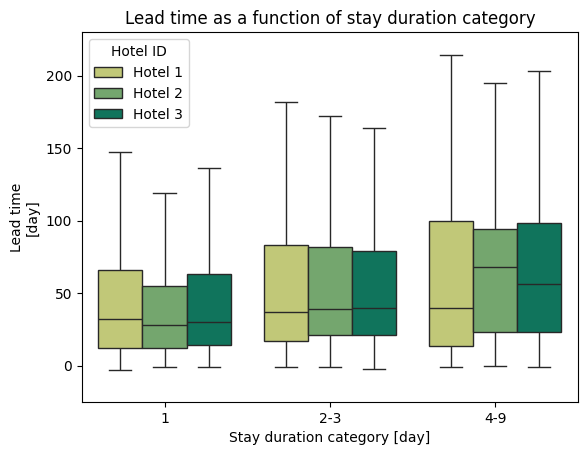

In [41]:
# custom color palette
custom_palette = ["#CCD56B", "#6CAF65", "#008464"]

sns.boxplot(data=df.assign(hotel_id=df['hotel_id'].map({'hotel_1': 'Hotel 1', 'hotel_2': 'Hotel 2', 'hotel_3':'Hotel 3'})), y='lead_time', x='rfm_duration_score', hue='hotel_id',fliersize=False, palette=custom_palette).set_ylim(top=230)
plt.legend(loc='upper left', title='Hotel ID')
plt.xlabel('Stay duration category [day]')
plt.ylabel('Lead time''\n''[day]')
plt.title('Lead time as a function of stay duration category')

## Booked price analysis

Text(0.5, 1.0, 'Hotel 3')

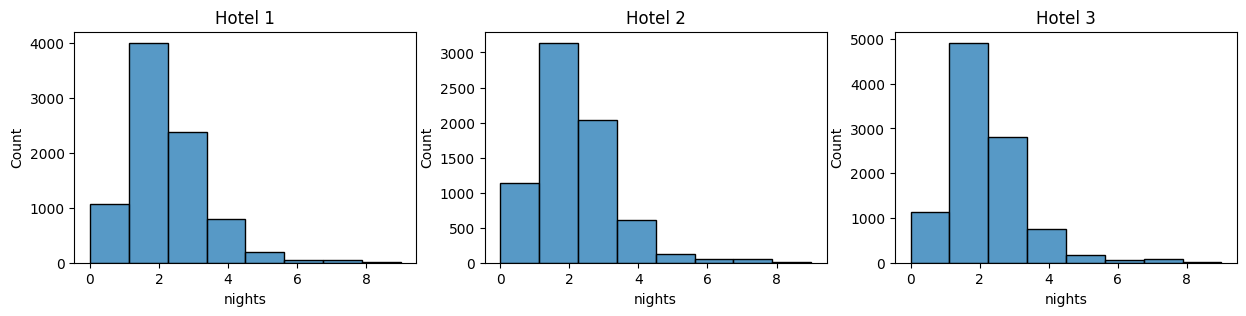

In [42]:
# distribution of stay duration
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,3))
sns.histplot(ax=ax1, data=hotel1, x='nights', bins=8)
sns.histplot(ax=ax2, data=hotel2, x='nights', bins=8)
sns.histplot(ax=ax3, data=hotel3, x='nights', bins=8)
ax1.set_title('Hotel 1')
ax2.set_title('Hotel 2')
ax3.set_title('Hotel 3')

Text(0.5, 0, 'Total price/night')

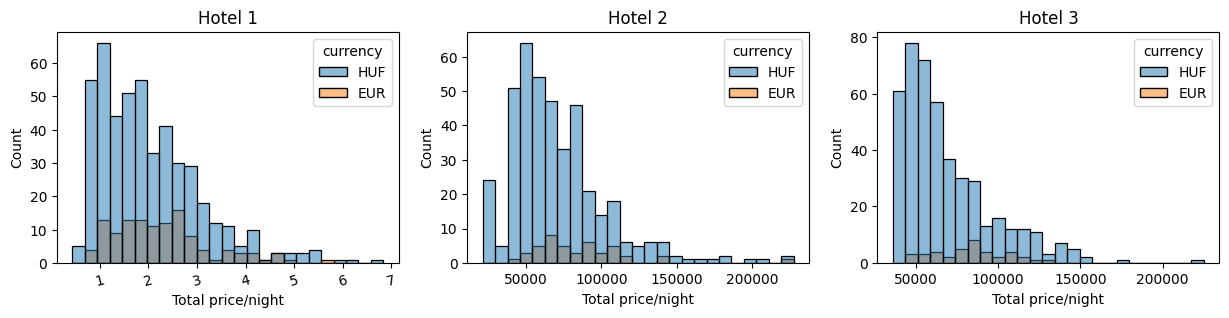

In [43]:
# distribution of booked total price per night
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,3))
sns.histplot(ax=ax1, data=hotel1, x='total_price_p_night', bins=25, hue='currency').set_xticklabels(ax.get_xticklabels(), rotation=15);
sns.histplot(ax=ax2, data=hotel2, x='total_price_p_night', bins=25, hue='currency')
sns.histplot(ax=ax3, data=hotel3, x='total_price_p_night', bins=25, hue='currency')  #lognorm distribution
ax1.set_title('Hotel 1')
ax2.set_title('Hotel 2')
ax3.set_title('Hotel 3')
ax1.set_xlabel('Total price/night')
ax2.set_xlabel('Total price/night')
ax3.set_xlabel('Total price/night')

In [44]:
# variable characteristics according to stay duration segments
# with every room search

pd.concat([df[['hotel_id','adults', 'children', 'if_children', 'conversion','sel_num_of_rooms',
               'total_price_p_night','children_age_mean', 'baby_bed','rfm_duration_score']],
           df[['upsell_total_price', 'loyalty_discount_total','redeemed_loyalty_points_total']].replace(to_replace=0, value=None)], axis=1).groupby(by=['hotel_id','rfm_duration_score']).mean().style.format('{0:,.2f}').bar(color='#d65f5f')

In [45]:
# variable characteristics according to stay duration segments
# this drops the duplicates in uuid!!! - keeping only the last room search from each visitor

pd.concat([df[['hotel_id','uuid','adults', 'children', 'if_children', 'conversion','sel_num_of_rooms',
               'total_price_p_night','children_age_mean', 'baby_bed','rfm_duration_score']],
           df[['upsell_total_price', 'loyalty_discount_total','redeemed_loyalty_points_total']].replace(to_replace=0, value=None)], axis=1).drop_duplicates(subset='uuid', keep='last').drop(columns='uuid').groupby(by=['hotel_id','rfm_duration_score']).mean().style.format('{0:,.2f}').bar(color='#d65f5f')

In [46]:
# variable characteristics according to monetary segments
# with every conversion

pd.concat([df[['hotel_id','adults', 'children', 'if_children','sel_num_of_rooms','nights',
               'children_age_mean', 'baby_bed','rfm_monetary_score']],
           df[['upsell_total_price', 'loyalty_discount_total','redeemed_loyalty_points_total']].replace(to_replace=0, value=None)], axis=1).groupby(by=['hotel_id','rfm_monetary_score']).mean().style.format('{0:,.2f}').bar(color='#d65f5f')

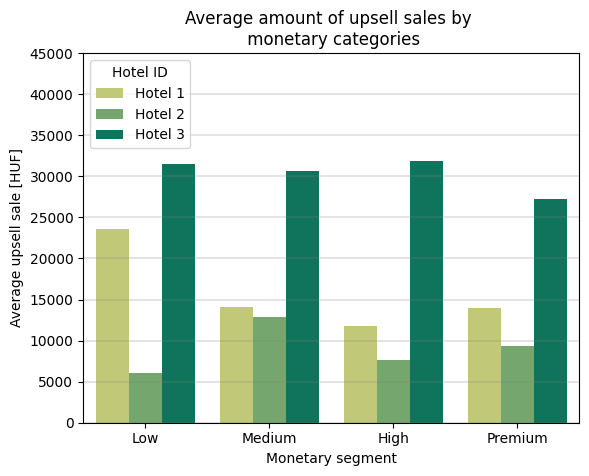

In [47]:
# plot the interesting findings from above charts

sns.barplot(data=df.assign(hotel_id=df['hotel_id'].map({'hotel_1': 'Hotel 1', 'hotel_2': 'Hotel 2', 'hotel_3':'Hotel 3'})), x='rfm_monetary_score', y=df['upsell_total_price'].replace(to_replace=0, value=None), hue='hotel_id', estimator="mean", errorbar=None, palette=custom_palette)
plt.legend(loc='upper left', title='Hotel ID')
plt.ylim(top=45000)
plt.xlabel('Monetary segment')
plt.ylabel('Average upsell sale [HUF]')
plt.title('Average amount of upsell sales by ''\n'' monetary categories')
plt.grid(which='major', axis='y', color='gray', linewidth=0.3)

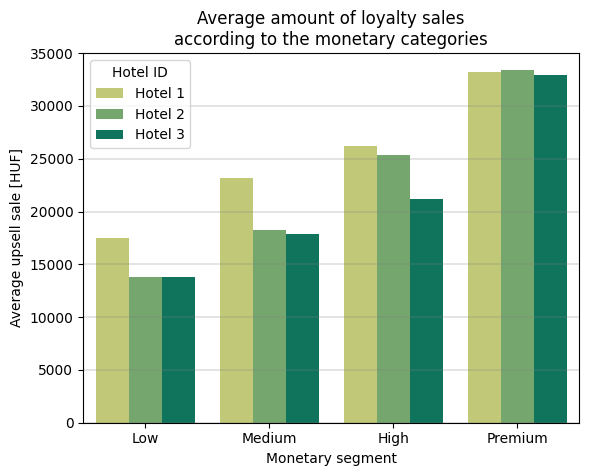

In [48]:
sns.barplot(data=df.assign(hotel_id=df['hotel_id'].map({'hotel_1': 'Hotel 1', 'hotel_2': 'Hotel 2', 'hotel_3':'Hotel 3'})), x='rfm_monetary_score', y=df['loyalty_discount_total'].replace(to_replace=0, value=None), hue='hotel_id', errorbar=None, estimator="mean", palette=custom_palette)

plt.legend(loc='upper left', title='Hotel ID')
plt.ylim(top=35000)
plt.xlabel('Monetary segment')
plt.ylabel('Average upsell sale [HUF]')
plt.title('Average amount of loyalty sales''\n''according to the monetary categories')
plt.grid(which='major', axis='y', color='gray', linewidth=0.3)

In [49]:
# groupby to separate according to who converted and who not
pd.concat([df_unique[['hotel_id','adults', 'children', 'if_children','sel_num_of_rooms','nights',
               'children_age_mean', 'baby_bed','conversion']],
           df_unique[['upsell_total_price', 'loyalty_discount_total','redeemed_loyalty_points_total']].replace(to_replace=0, value=None)], axis=1).groupby(by=['hotel_id','conversion']).mean().style.format('{0:,.2f}').bar(color='#d65f5f')

Text(0.5, 1.0, 'Hotel 3')

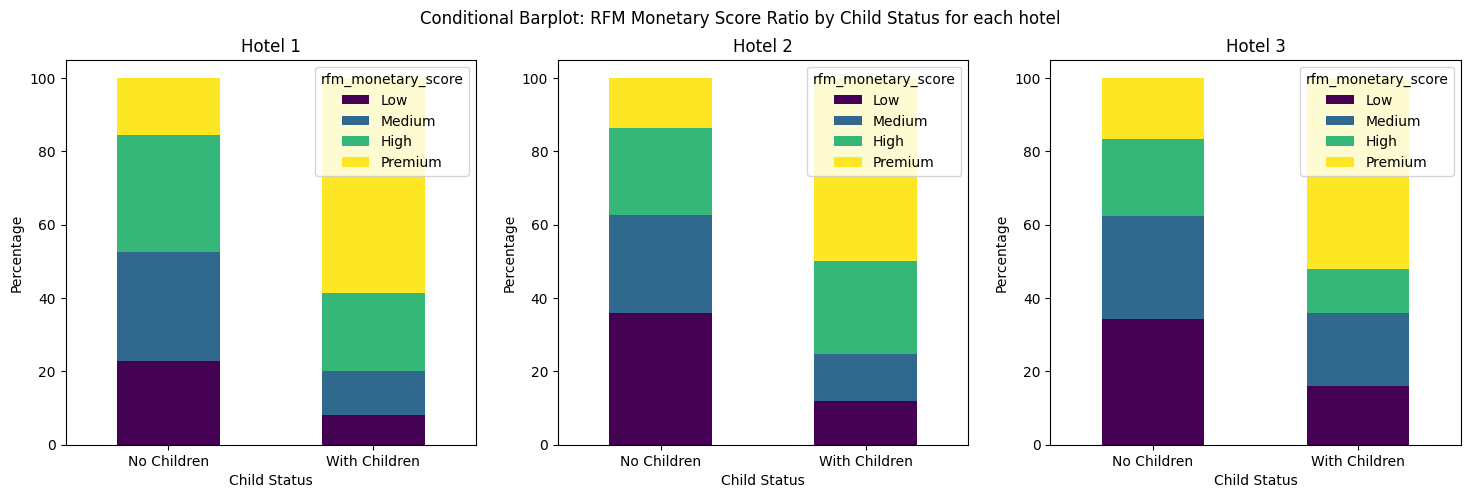

In [50]:
# for hotel 1
# Step 1: Calculate counts by 'if_children' and 'rfm_monetary_score'
counts1 = (
    hotel1[['if_children', 'rfm_monetary_score']]
    .groupby(['if_children', 'rfm_monetary_score'])
    .size()
    .reset_index(name='count'))  # Name the count column explicitly

# Step 2: Normalize the counts to percentages within each 'if_children' group
counts1['percentage'] = (
    counts1.groupby('if_children')['count']
    .transform(lambda x: 100 * x / x.sum()))

# Step 3: Pivot the data to reshape for plotting
pivot1 = counts1.pivot(
    index='if_children',          # Rows: If Children (0 or 1)
    columns='rfm_monetary_score', # Columns: RFM monetary score
    values='percentage'           # Values: Percentage
).fillna(0)  # Fill any missing values with 0


# for hotel 2
# Step 1: Calculate counts by 'if_children' and 'rfm_monetary_score'
counts2 = (
    hotel2[['if_children', 'rfm_monetary_score']]
    .groupby(['if_children', 'rfm_monetary_score'])
    .size()
    .reset_index(name='count'))  # Name the count column explicitly

# Step 2: Normalize the counts to percentages within each 'if_children' group
counts2['percentage'] = (
    counts2.groupby('if_children')['count']
    .transform(lambda x: 100 * x / x.sum()))

# Step 3: Pivot the data to reshape for plotting
pivot2 = counts2.pivot(
    index='if_children',          # Rows: If Children (0 or 1)
    columns='rfm_monetary_score', # Columns: RFM monetary score
    values='percentage'           # Values: Percentage
).fillna(0)  # Fill any missing values with 0


# for hotel 3
# Step 1: Calculate counts by 'if_children' and 'rfm_monetary_score'
counts3 = (
    hotel3[['if_children', 'rfm_monetary_score']]
    .groupby(['if_children', 'rfm_monetary_score'])
    .size()
    .reset_index(name='count'))  # Name the count column explicitly

# Step 2: Normalize the counts to percentages within each 'if_children' group
counts3['percentage'] = (
    counts3.groupby('if_children')['count']
    .transform(lambda x: 100 * x / x.sum()))

# Step 3: Pivot the data to reshape for plotting
pivot3 = counts3.pivot(
    index='if_children',          # Rows: If Children (0 or 1)
    columns='rfm_monetary_score', # Columns: RFM monetary score
    values='percentage'           # Values: Percentage
).fillna(0)  # Fill any missing values with 0


fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,5))


# Step 4: Plot the data
pivot1.plot(ax=ax1, kind='bar', stacked=True, cmap="viridis")
pivot2.plot(ax=ax2, kind='bar', stacked=True, cmap="viridis")
pivot3.plot(ax=ax3, kind='bar', stacked=True, cmap="viridis")

fig.suptitle('Conditional Barplot: RFM Monetary Score Ratio by Child Status for each hotel')
ax1.set_xlabel('Child Status')
ax2.set_xlabel('Child Status')
ax3.set_xlabel('Child Status')
ax1.set_ylabel('Percentage')
ax2.set_ylabel('Percentage')
ax3.set_ylabel('Percentage')
ax1.set_xticks(ticks=[0, 1], labels=['No Children', 'With Children'], rotation=0)
ax2.set_xticks(ticks=[0, 1], labels=['No Children', 'With Children'], rotation=0)
ax3.set_xticks(ticks=[0, 1], labels=['No Children', 'With Children'], rotation=0)
ax1.set_title('Hotel 1')
ax2.set_title('Hotel 2')
ax3.set_title('Hotel 3')


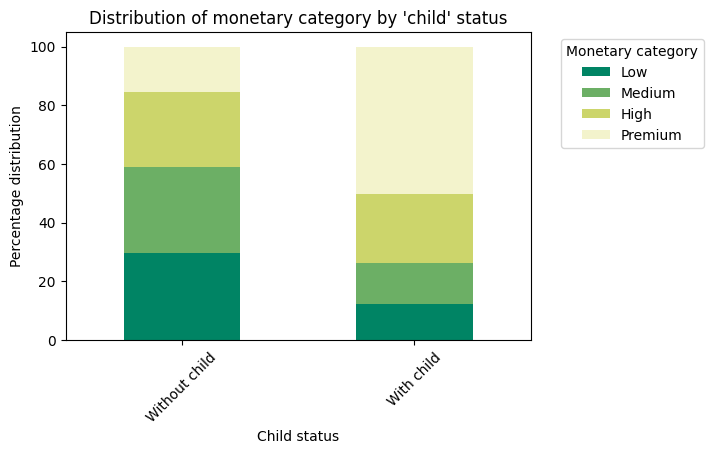

In [51]:
# for entire df, instead of uniqe hotels

import matplotlib.colors

# Step 1: Calculate counts by 'if_children' and 'rfm_monetary_score'
counts = (
    df[['if_children', 'rfm_monetary_score']]
    .groupby(['if_children', 'rfm_monetary_score'])
    .size()
    .reset_index(name='count'))  # Name the count column explicitly

# Step 2: Normalize the counts to percentages within each 'if_children' group
counts['percentage'] = (
    counts.groupby('if_children')['count']
    .transform(lambda x: 100 * x / x.sum()))

# Step 3: Pivot the data to reshape for plotting
pivot = counts.pivot(
    index='if_children',          # Rows: If Children (0 or 1)
    columns='rfm_monetary_score', # Columns: RFM monetary score
    values='percentage'           # Values: Percentage
).fillna(0)  # Fill any missing values with 0

# Step 4: Plot the data
pivot.plot(kind='bar', stacked=True, figsize=(6, 4), cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ['#008464', '#6CAF65', '#CCD56B', '#F3F3CC']))
plt.title("Distribution of monetary category by 'child' status")
plt.xlabel('Child status')
plt.ylabel('Percentage distribution')
plt.xticks(ticks=[0, 1], labels=['Without child', 'With child'], rotation=45)
plt.legend(title='Monetary category', loc='upper left',bbox_to_anchor=(1.05, 1))

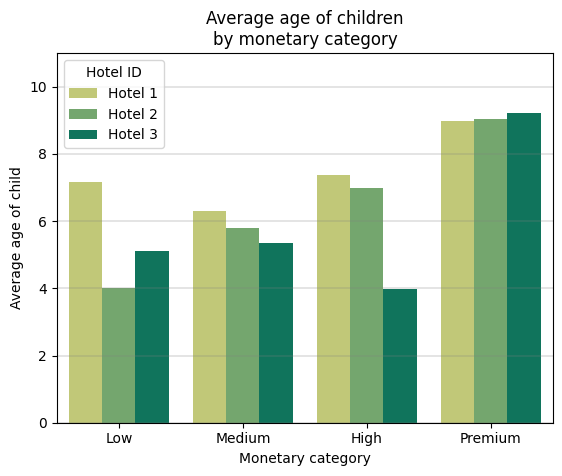

In [52]:
sns.barplot(data=df.assign(hotel_id=df['hotel_id'].map({'hotel_1': 'Hotel 1', 'hotel_2': 'Hotel 2', 'hotel_3':'Hotel 3'})), x='rfm_monetary_score', y='children_age_mean', hue='hotel_id', errorbar=None, palette=custom_palette)
plt.ylim(top=11)

plt.legend(loc='upper left', title='Hotel ID')
plt.xlabel('Monetary category')
plt.ylabel('Average age of child')
plt.title('Average age of children''\n''by monetary category')
plt.grid(which='major', axis='y', color='gray', linewidth=0.3)

In [ ]:
# probability of children according to different monetary score category
df[['hotel_id','children','rfm_monetary_score']].groupby(by=['hotel_id','rfm_monetary_score']).mean().reset_index()

hotel_id rfm_monetary_score  children
0   hotel_1                Low  0.207692
1   hotel_1             Medium  0.298507
2   hotel_1               High  0.514768
3   hotel_1            Premium  1.141593
4   hotel_2                Low  0.189024
5   hotel_2             Medium  0.225564
6   hotel_2               High  0.471429
7   hotel_2            Premium  0.945312
8   hotel_3                Low  0.155660
9   hotel_3             Medium  0.128655
10  hotel_3               High  0.179688
11  hotel_3            Premium  0.638158

In [98]:
# groupby according to  children was in the booking or not (1 or 0 flag)
# with every conversion
pd.concat([df[['hotel_id','adults', 'if_children','sel_num_of_rooms','nights','total_price_p_night','conversion']],
           df[['upsell_total_price', 'loyalty_discount_total','redeemed_loyalty_points_total']].replace(to_replace=0, value=None)], axis=1).groupby(by=['hotel_id','if_children']).mean().style.format('{0:,.2f}').bar(color='#d65f5f')

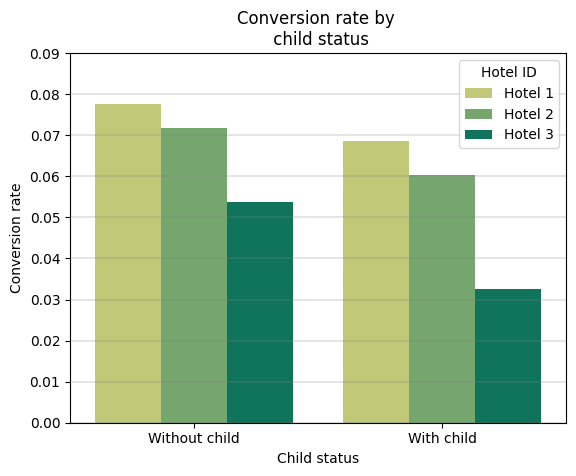

In [145]:
# Conversion rate by child status
sns.barplot(data=df_unique[['hotel_id','if_children','conversion']].groupby(by=['hotel_id','if_children']).mean().reset_index().assign(hotel_id=df_unique[['hotel_id','if_children','conversion']].groupby(by=['hotel_id','if_children']).mean().reset_index()['hotel_id'].map({'hotel_1': 'Hotel 1', 'hotel_2': 'Hotel 2', 'hotel_3':'Hotel 3'})), 
            x='if_children', y='conversion', hue='hotel_id', palette=custom_palette)
plt.xticks(ticks=[0, 1], labels=['Without child', 'With child'])
plt.ylim(top=0.09)
plt.legend(loc='upper right', title='Hotel ID')
plt.xlabel('Child status')
plt.ylabel('Conversion rate')
plt.title('Conversion rate by ''\n'' child status')
plt.grid(which='major', axis='y', color='gray', linewidth=0.3)

In [149]:
# take into account only the unique users (and not multiple searches from the same users)
df_to_plot = df_unique.copy()
df_to_plot['upsell_total_price'].replace(to_replace=0, value=None, inplace=True)

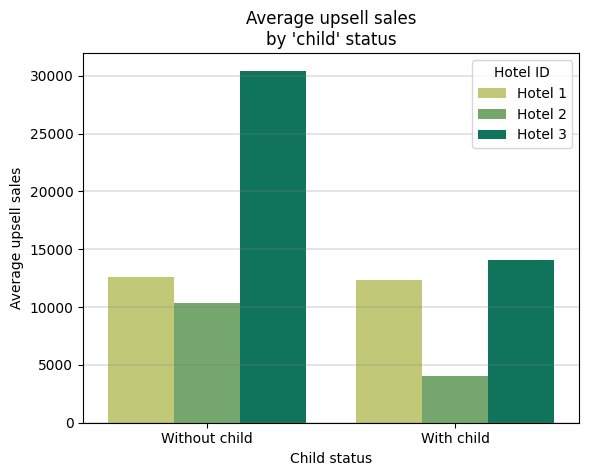

In [151]:
# Average upsell sales by 'child' status
sns.barplot(data=df_to_plot[['hotel_id','if_children','upsell_total_price']].groupby(by=['hotel_id','if_children']).mean().reset_index().assign(hotel_id=df_unique[['hotel_id','if_children','upsell_total_price']].groupby(by=['hotel_id','if_children']).mean().reset_index()['hotel_id'].map({'hotel_1': 'Hotel 1', 'hotel_2': 'Hotel 2', 'hotel_3':'Hotel 3'})), 
            x='if_children', y='upsell_total_price', hue='hotel_id', palette=custom_palette)

plt.xticks(ticks=[0, 1], labels=['Without child', 'With child'])
plt.legend(loc='upper right', title='Hotel ID')
plt.xlabel('Child status')
plt.ylabel('Average upsell sales')
plt.title("Average upsell sales""\n""by 'child' status")
plt.grid(which='major', axis='y', color='gray', linewidth=0.3)

<Axes: xlabel='currency', ylabel='nights'>

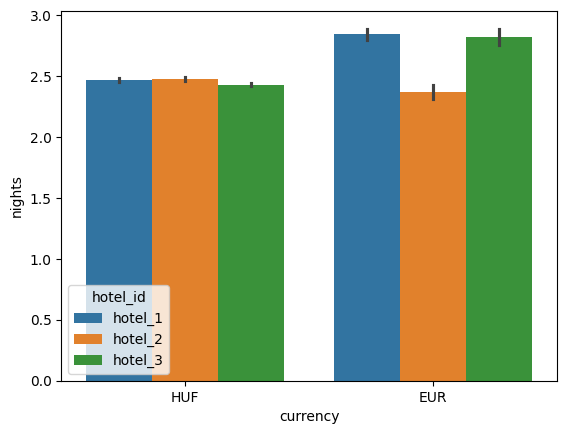

In [ ]:
# average booking price/night per currency
sns.barplot(data=df, x='currency', y='nights', hue='hotel_id', estimator='mean')

Text(0, 0.5, 'Percentage [%]')

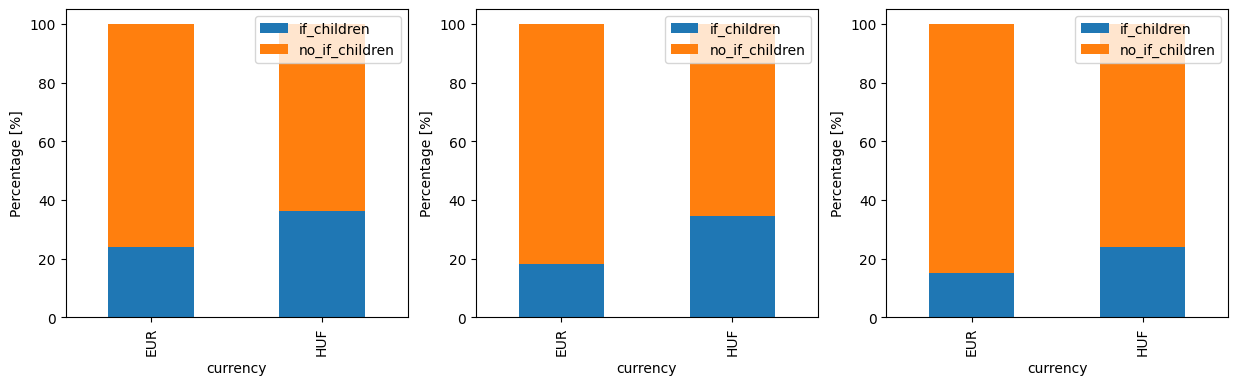

In [ ]:
# conditional probability plot of childrens by currency
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))

test = (hotel1_unique[['if_children','currency']].groupby(by='currency').mean()*100).reset_index()
test['no_if_children'] = 100-test['if_children']
test.plot(ax=ax1, x='currency',kind='bar',stacked=True)
ax1.set_ylabel('Percentage [%]')

test = (hotel2_unique[['if_children','currency']].groupby(by='currency').mean()*100).reset_index()
test['no_if_children'] = 100-test['if_children']
test.plot(ax=ax2, x='currency',kind='bar',stacked=True)
ax2.set_ylabel('Percentage [%]')

test = (hotel3_unique[['if_children','currency']].groupby(by='currency').mean()*100).reset_index()
test['no_if_children'] = 100-test['if_children']
test.plot(ax=ax3, x='currency',kind='bar',stacked=True)
ax3.set_ylabel('Percentage [%]')

In [ ]:
# median booking price for each stay duration category
df[['hotel_id','total_price_p_night','rfm_duration_score']].groupby(by=['hotel_id','rfm_duration_score']).median()

total_price_p_night
hotel_id rfm_duration_score                     
hotel_1  1                          73440.000000
         2-3                        70848.147778
         4-9                        62172.000000
hotel_2  1                          63575.550000
         2-3                        67321.945000
         4-9                        74187.036667
hotel_3  1                          61261.000000
         2-3                        61499.507867
         4-9                        61371.000000

## Campaign analysis

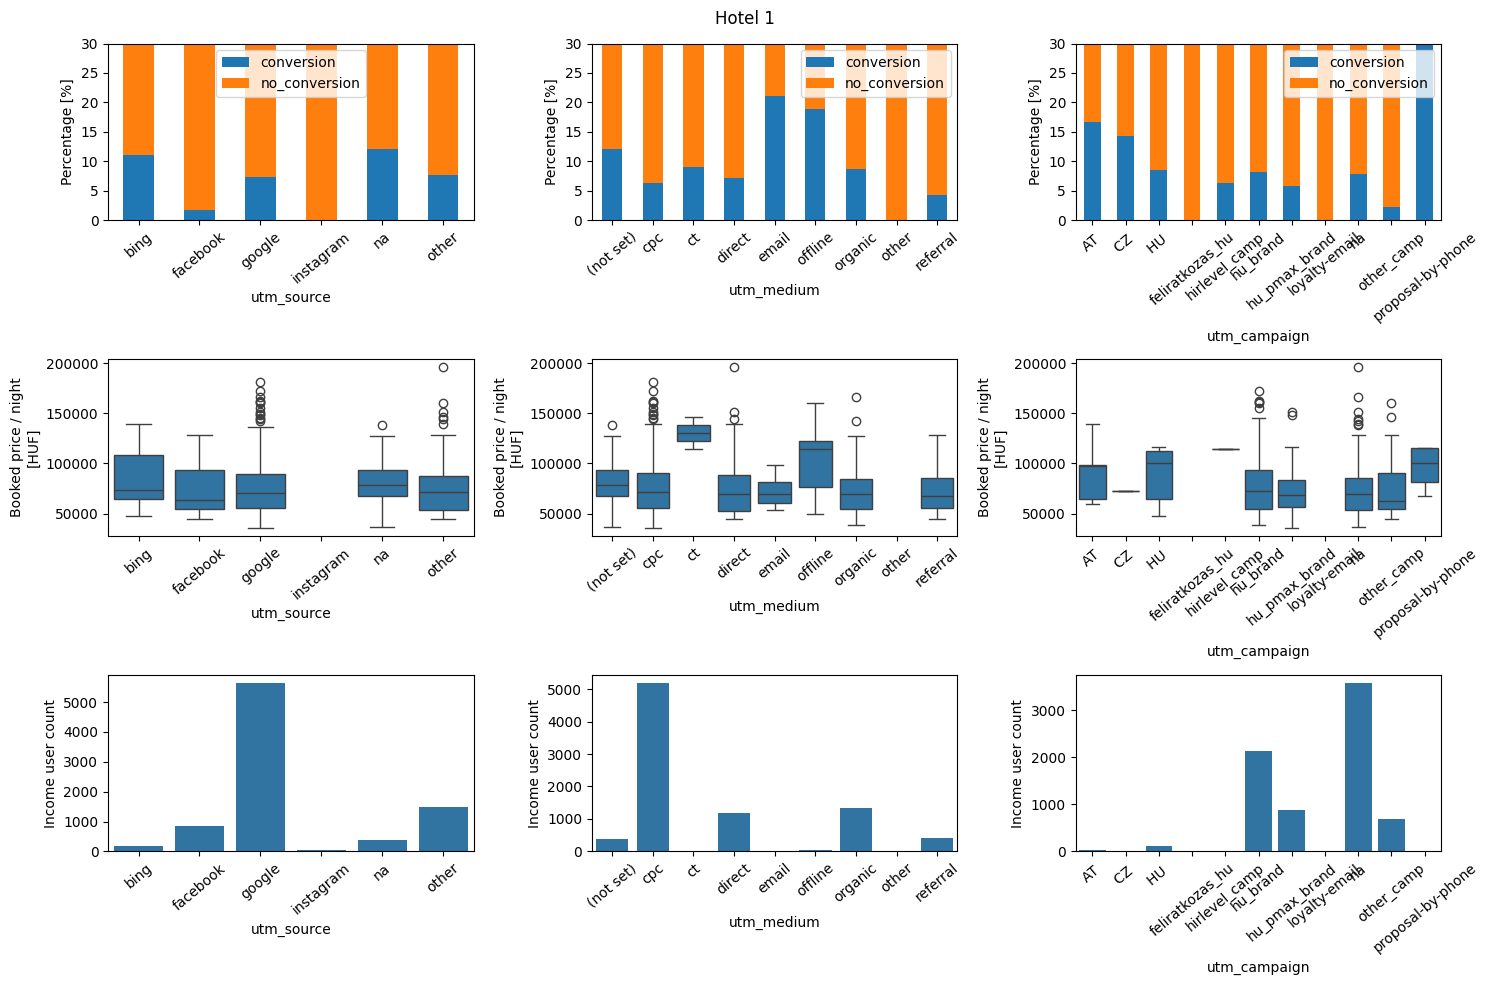

In [62]:
# stacked barplot according to utm_campaign, medium and source for hotel 1

fig, ((ax1, ax2, ax3), (ax21, ax22, ax23), (ax31, ax32, ax33)) = plt.subplots(3,3, figsize=(15,10))

test = (hotel1_unique[['conversion','utm_source']].groupby(by='utm_source').mean()*100).reset_index()
test['no_conversion'] = 100-test['conversion']
test.plot(x='utm_source',kind='bar',stacked=True, ax=ax1).tick_params(axis='x', rotation=40)
ax1.set_ylabel('Percentage [%]')
ax1.set_ylim(top=30)

test2 = (hotel1_unique[['conversion','utm_medium']].groupby(by='utm_medium').mean()*100).reset_index()
test2['no_conversion'] = 100-test2['conversion']
test2.plot(x='utm_medium',kind='bar',stacked=True, ax=ax2).tick_params(axis='x', rotation=40)
ax2.set_ylabel('Percentage [%]')
ax2.set_ylim(top=30)

test3 = (hotel1_unique[['conversion','utm_campaign']].groupby(by='utm_campaign').mean()*100).reset_index()
test3['no_conversion'] = 100-test3['conversion']
test3.plot(x='utm_campaign',kind='bar',stacked=True, ax=ax3).tick_params(axis='x', rotation=40)
ax3.set_ylabel('Percentage [%]')
ax3.set_ylim(top=30)

sns.boxplot(data=hotel1_unique, x='utm_source', y='total_price_p_night', ax=ax21, order=['bing', 'facebook', 'google', 'instagram', 'na', 'other']).tick_params(axis='x', rotation=40)
sns.boxplot(data=hotel1_unique, x='utm_medium', y='total_price_p_night', ax=ax22, order=['(not set)', 'cpc', 'ct', 'direct', 'email', 'offline','organic','other','referral']).tick_params(axis='x', rotation=40)
sns.boxplot(data=hotel1_unique, x='utm_campaign', y='total_price_p_night', ax=ax23, order=['AT ', 'CZ ', 'HU ', 'feliratkozas_hu', 'hirlevel_camp', 'hu_brand','hu_pmax_brand','loyalty-email','na','other_camp','proposal-by-phone']).tick_params(axis='x', rotation=40)
ax21.set_ylabel('Booked price / night''\n''[HUF]')
ax22.set_ylabel('Booked price / night''\n''[HUF]')
ax23.set_ylabel('Booked price / night''\n''[HUF]')

sns.countplot(data=hotel1_unique, x='utm_source', ax=ax31, order=['bing', 'facebook', 'google', 'instagram', 'na', 'other']).tick_params(axis='x', rotation=40)
sns.countplot(data=hotel1_unique, x='utm_medium', ax=ax32, order=['(not set)', 'cpc', 'ct', 'direct', 'email', 'offline','organic','other','referral']).tick_params(axis='x', rotation=40)
sns.countplot(data=hotel1_unique, x='utm_campaign', ax=ax33, order=['AT ', 'CZ ', 'HU ', 'feliratkozas_hu', 'hirlevel_camp', 'hu_brand','hu_pmax_brand','loyalty-email','na','other_camp','proposal-by-phone']).tick_params(axis='x', rotation=40)
ax31.set_ylabel('Income user count')
ax32.set_ylabel('Income user count')
ax33.set_ylabel('Income user count')

fig.suptitle('Hotel 1')
fig.tight_layout()

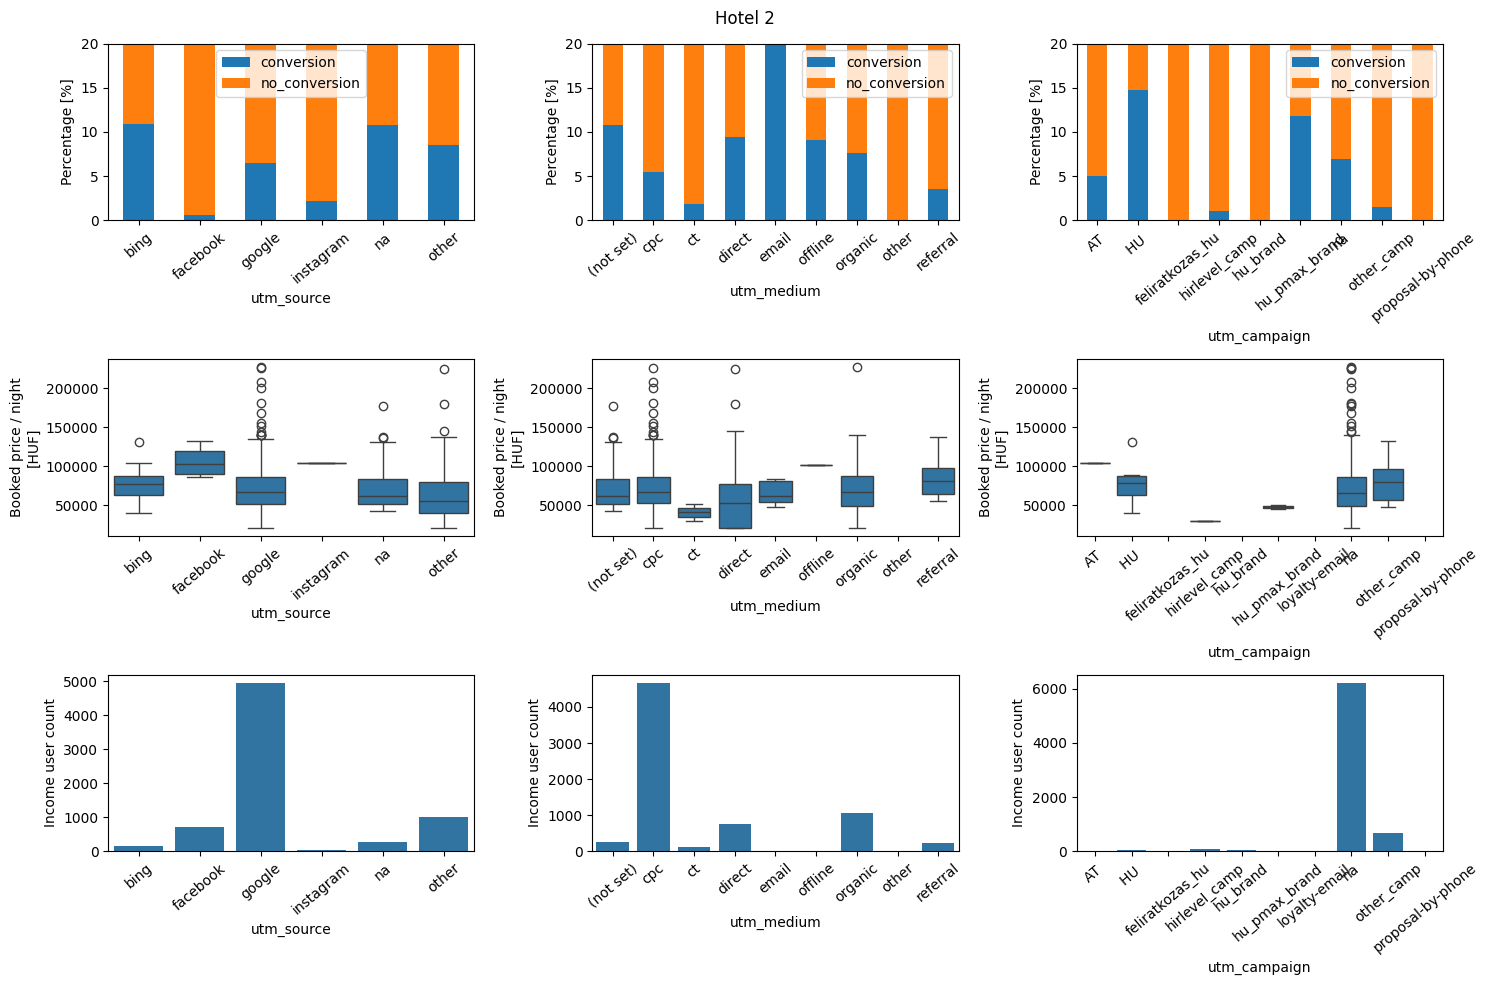

In [63]:
# stacked barplot according to utm_campaign, medium and source for hotel 2

fig, ((ax1, ax2, ax3), (ax21, ax22, ax23), (ax31, ax32, ax33)) = plt.subplots(3,3, figsize=(15,10))

test = (hotel2_unique[['conversion','utm_source']].groupby(by='utm_source').mean()*100).reset_index()
test['no_conversion'] = 100-test['conversion']
test.plot(x='utm_source',kind='bar',stacked=True, ax=ax1).tick_params(axis='x', rotation=40)
ax1.set_ylabel('Percentage [%]')
ax1.set_ylim(top=20)

test2 = (hotel2_unique[['conversion','utm_medium']].groupby(by='utm_medium').mean()*100).reset_index()
test2['no_conversion'] = 100-test2['conversion']
test2.plot(x='utm_medium',kind='bar',stacked=True, ax=ax2).tick_params(axis='x', rotation=40)
ax2.set_ylabel('Percentage [%]')
ax2.set_ylim(top=20)

test3 = (hotel2_unique[['conversion','utm_campaign']].groupby(by='utm_campaign').mean()*100).reset_index()
test3['no_conversion'] = 100-test3['conversion']
test3.plot(x='utm_campaign',kind='bar',stacked=True, ax=ax3).tick_params(axis='x', rotation=40)
ax3.set_ylabel('Percentage [%]')
ax3.set_ylim(top=20)

sns.boxplot(data=hotel2_unique, x='utm_source', y='total_price_p_night', ax=ax21, order=['bing', 'facebook', 'google', 'instagram', 'na', 'other']).tick_params(axis='x', rotation=40)
sns.boxplot(data=hotel2_unique, x='utm_medium', y='total_price_p_night', ax=ax22, order=['(not set)', 'cpc', 'ct', 'direct', 'email', 'offline','organic', 'other', 'referral']).tick_params(axis='x', rotation=40)
sns.boxplot(data=hotel2_unique, x='utm_campaign', y='total_price_p_night', ax=ax23, order=['AT ', 'HU ', 'feliratkozas_hu', 'hirlevel_camp', 'hu_brand','hu_pmax_brand','loyalty-email','na','other_camp','proposal-by-phone']).tick_params(axis='x', rotation=40)
ax21.set_ylabel('Booked price / night''\n''[HUF]')
ax22.set_ylabel('Booked price / night''\n''[HUF]')
ax23.set_ylabel('Booked price / night''\n''[HUF]')

sns.countplot(data=hotel2_unique, x='utm_source', ax=ax31, order=['bing', 'facebook', 'google', 'instagram', 'na', 'other']).tick_params(axis='x', rotation=40)
sns.countplot(data=hotel2_unique, x='utm_medium', ax=ax32, order=['(not set)', 'cpc', 'ct', 'direct', 'email', 'offline','organic', 'other', 'referral']).tick_params(axis='x', rotation=40)
sns.countplot(data=hotel2_unique, x='utm_campaign', ax=ax33, order=['AT ', 'HU ', 'feliratkozas_hu', 'hirlevel_camp', 'hu_brand','hu_pmax_brand','loyalty-email','na','other_camp','proposal-by-phone']).tick_params(axis='x', rotation=40)
ax31.set_ylabel('Income user count')
ax32.set_ylabel('Income user count')
ax33.set_ylabel('Income user count')

fig.suptitle('Hotel 2')
fig.tight_layout()

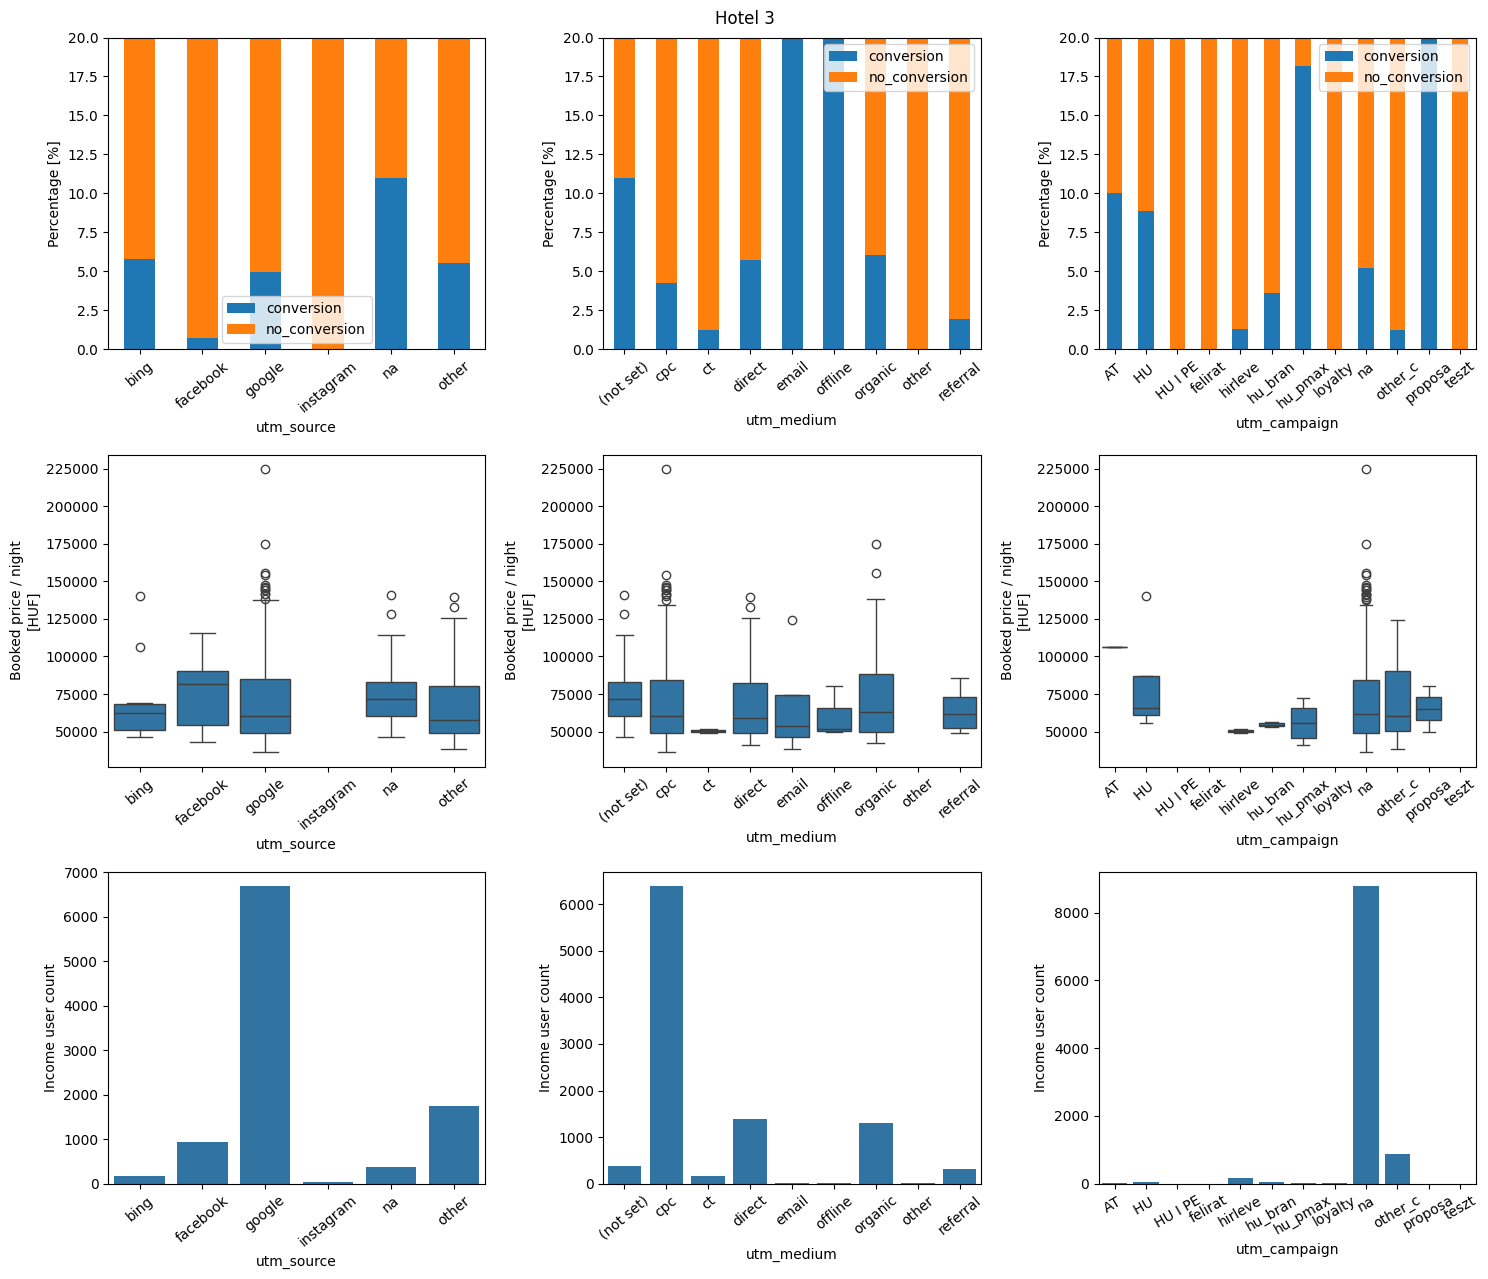

In [79]:
# stacked barplot according to utm_campaign, medium and source for hotel 3

fig, ((ax1, ax2, ax3), (ax21, ax22, ax23), (ax31, ax32, ax33)) = plt.subplots(3,3, figsize=(15,13))

test = (hotel3_unique[['conversion','utm_source']].groupby(by='utm_source').mean()*100).reset_index()
test['no_conversion'] = 100-test['conversion']
test.plot(x='utm_source',kind='bar',stacked=True, ax=ax1).tick_params(axis='x', rotation=40)
ax1.set_ylabel('Percentage [%]')
ax1.set_ylim(top=20)

test2 = (hotel3_unique[['conversion','utm_medium']].groupby(by='utm_medium').mean()*100).reset_index()
test2['no_conversion'] = 100-test2['conversion']
test2.plot(x='utm_medium',kind='bar',stacked=True, ax=ax2).tick_params(axis='x', rotation=40)
ax2.set_ylabel('Percentage [%]')
ax2.set_ylim(top=20)

test3 = (hotel3_unique[['conversion','utm_campaign']].groupby(by='utm_campaign').mean()*100).reset_index()
test3['no_conversion'] = 100-test3['conversion']
test3.plot(x='utm_campaign',kind='bar',stacked=True, ax=ax3).tick_params(axis='x', rotation=40)
ax3.set_ylabel('Percentage [%]')
ax3.set_ylim(top=20)

sns.boxplot(data=hotel3_unique, x='utm_source', y='total_price_p_night', ax=ax21, order=['bing', 'facebook', 'google', 'instagram', 'na', 'other']).tick_params(axis='x', rotation=40)
sns.boxplot(data=hotel3_unique, x='utm_medium', y='total_price_p_night', ax=ax22, order=['(not set)', 'cpc', 'ct', 'direct', 'email', 'offline','organic', 'other', 'referral']).tick_params(axis='x', rotation=40)
sns.boxplot(data=hotel3_unique, x='utm_campaign', y='total_price_p_night', ax=ax23, order=['AT ', 'HU ', 'HU I PERF I Display I Fagus lombhullÃ¡s', 'feliratkozas_hu','hirlevel_camp', 'hu_brand','hu_pmax_brand','loyalty-email','na','other_camp','proposal-by-phone','teszt']).tick_params(axis='x', rotation=40)
ax21.set_ylabel('Booked price / night''\n''[HUF]')
ax22.set_ylabel('Booked price / night''\n''[HUF]')
ax23.set_ylabel('Booked price / night''\n''[HUF]')

sns.countplot(data=hotel3_unique, x='utm_source', ax=ax31, order=['bing', 'facebook', 'google', 'instagram', 'na', 'other']).tick_params(axis='x', rotation=40)
sns.countplot(data=hotel3_unique, x='utm_medium', ax=ax32, order=['(not set)', 'cpc', 'ct', 'direct', 'email', 'offline','organic', 'other', 'referral']).tick_params(axis='x', rotation=40)
sns.countplot(data=hotel3_unique, x='utm_campaign', ax=ax33, order=['AT ', 'HU ', 'HU I PERF I Display I Fagus lombhullÃ¡s', 'feliratkozas_hu','hirlevel_camp', 'hu_brand','hu_pmax_brand','loyalty-email','na','other_camp','proposal-by-phone','teszt']).tick_params(axis='x', rotation=30)

# shortening the too long xlables for plotting
max_chars = 7
new_labels = ['\n'.join(label._text[i:i + max_chars ] 
                        for i in range(0, max_chars, max_chars ))
              for label in ax33.get_xticklabels()]
ax3.set_xticklabels(new_labels)
ax23.set_xticklabels(new_labels)
ax33.set_xticklabels(new_labels)

ax31.set_ylabel('Income user count')
ax32.set_ylabel('Income user count')
ax33.set_ylabel('Income user count')

fig.suptitle('Hotel 3')
fig.tight_layout()

# Search patterns and key variables

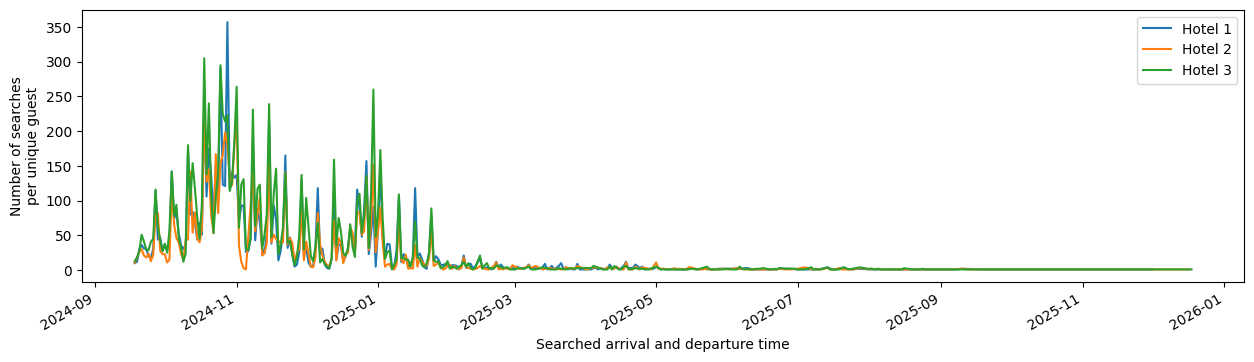

In [93]:
# what are the visitors looking for?

# search pattern by date
fig, ax1 = plt.subplots(1,1,figsize=(15,4))
hotel1[['arrival','uuid']].groupby(by='arrival').count().plot(ax=ax1)
hotel2[['arrival','uuid']].groupby(by='arrival').count().plot(ax=ax1)
hotel3[['arrival','uuid']].groupby(by='arrival').count().plot(ax=ax1)

plt.xlabel('Searched arrival and departure time')
plt.ylabel('Number of searches''\n''per unique guest')
ax1.legend(['Hotel 1', 'Hotel 2', 'Hotel 3'])

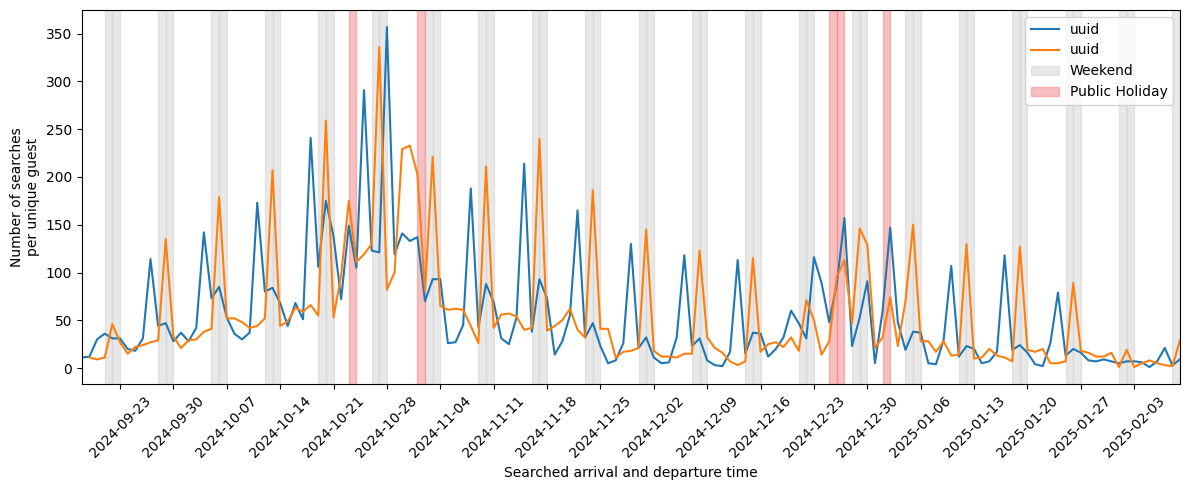

In [87]:
# filter for more recent dates and highlight tha public holidays and weekend days

fig, ax1 = plt.subplots(1, 1, figsize=(12, 5))
hotel1_unique[hotel1_unique['arrival'] < '2025-02-10'][['arrival', 'uuid']].groupby(by='arrival').count().plot(ax=ax1, label='Hotel 1')
hotel1_unique[hotel1_unique['departure'] < '2025-02-10'][['departure', 'uuid']].groupby(by='departure').count().plot(ax=ax1, label='Hotel 1')

# highlight weekends
start_date = pd.to_datetime('2024-09-01')  # Adjust based on your data range
end_date = pd.to_datetime('2025-02-10')
current_date = start_date

while current_date <= end_date:
    if current_date.weekday() >= 5:  # Saturday (5) and Sunday (6)
        ax1.axvspan(current_date, current_date + timedelta(days=1), color='lightgrey', alpha=0.5, label='Weekend' if current_date == start_date else None)
    current_date += timedelta(days=1)

# highlight public holidays
for holiday in public_holidays:
    if start_date <= holiday <= end_date:
        ax1.axvspan(holiday, holiday + timedelta(days=1), color='lightcoral', alpha=0.5, label='Public Holiday' if holiday == public_holidays[0] else None)

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
plt.xticks(rotation=45)

ax1.set_xlabel('Searched arrival and departure time')
ax1.set_ylabel('Number of searches''\n''per unique guest')
ax1.legend()
plt.tight_layout()


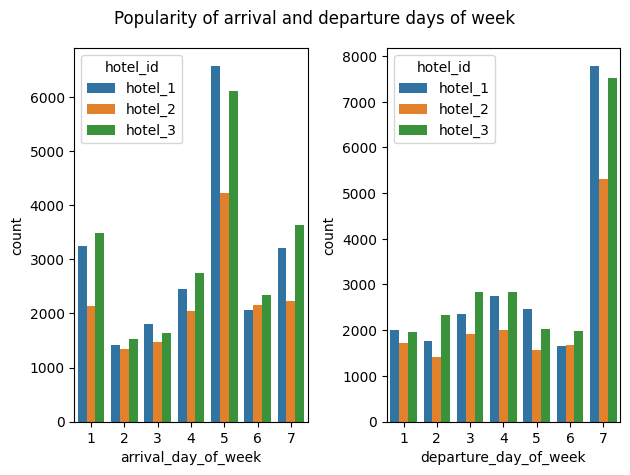

In [95]:
# Popularity of arrival and departure days of week for each hotel

fig, (ax1, ax2) = plt.subplots(1,2)
sns.countplot(ax=ax1, data=df, x='arrival_day_of_week', hue='hotel_id')
sns.countplot(ax=ax2, data=df, x='departure_day_of_week', hue='hotel_id')
fig.suptitle('Popularity of arrival and departure days of week')
plt.tight_layout()

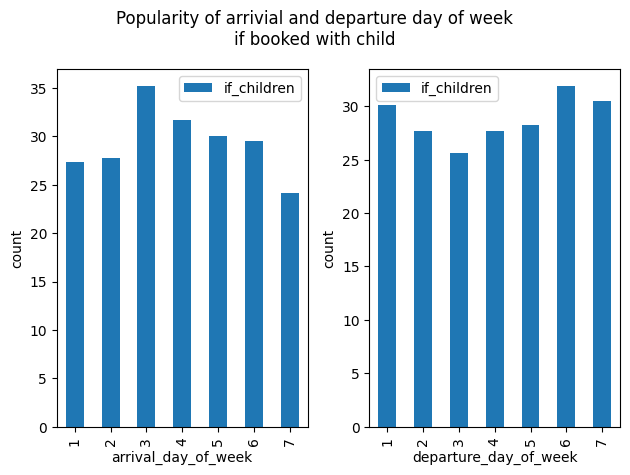

In [100]:
# Popularity of arrivial and departure day of week if booked with child
fig, (ax1, ax2) = plt.subplots(1,2)
(df_unique[['if_children','arrival_day_of_week']].groupby(by='arrival_day_of_week').mean()*100).plot(ax=ax1, kind='bar')
(df_unique[['if_children','departure_day_of_week']].groupby(by='departure_day_of_week').mean()*100).plot(ax=ax2, kind='bar')
ax1.set_ylabel('count')
ax2.set_ylabel('count')
fig.suptitle('Popularity of arrivial and departure day of week''\n''if booked with child')
plt.tight_layout()

Text(0.5, 1.0, 'Day of week on which the guests\nsearch for hotel rooms')

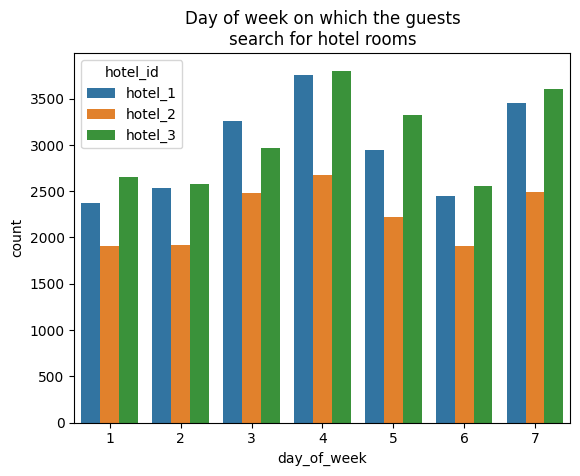

In [103]:
# on which day the guests search for hotel rooms?
sns.countplot(data=df, x='day_of_week', hue='hotel_id')
plt.title('Day of week on which the guests''\n''search for hotel rooms')

Text(0.5, 1.0, 'Time of day on which the guests\nsearch for hotel rooms')

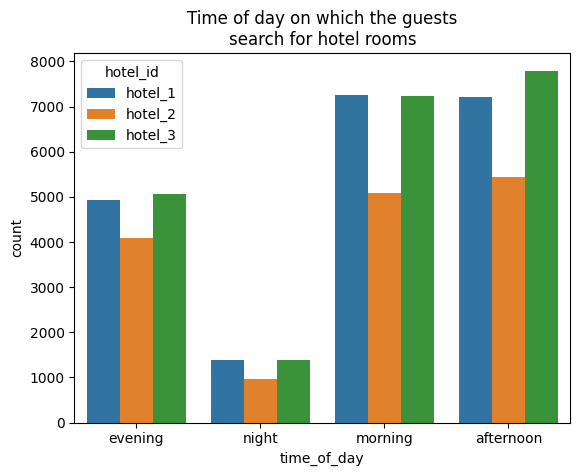

In [104]:
# on which time of the day the guests search for hotel rooms?
sns.countplot(data=df, x='time_of_day', hue='hotel_id')
plt.title('Time of day on which the guests''\n''search for hotel rooms')

In [160]:
# segmentation according to lead time category and guest properties
# define the specific order for 'lead_time_category'
order = ['last_minute', 'short_term', 'medium_term', 'long_term']
df['lead_time_category'] = pd.Categorical(df['lead_time_category'], categories=order, ordered=True)

df[['nights', 'if_children', 'children_age_mean', 'conversion', 'total_price_p_night','hotel_id','lead_time_category']].groupby(by=['hotel_id', 'lead_time_category'], sort=True).mean().style.format('{0:,.2f}').bar(color='#d65f5f')

In [161]:
# filter for only unique website visitors (according to uuid), segmentation according to lead time category and guest properties
# define the specific order for 'lead_time_category'
df_unique['lead_time_category'] = pd.Categorical(df_unique['lead_time_category'], categories=order, ordered=True)

df_unique[['nights', 'if_children', 'children_age_mean', 'conversion', 'total_price_p_night','hotel_id','lead_time_category']].groupby(by=['hotel_id', 'lead_time_category'], sort=True).mean().style.format('{0:,.2f}').bar(color='#d65f5f')

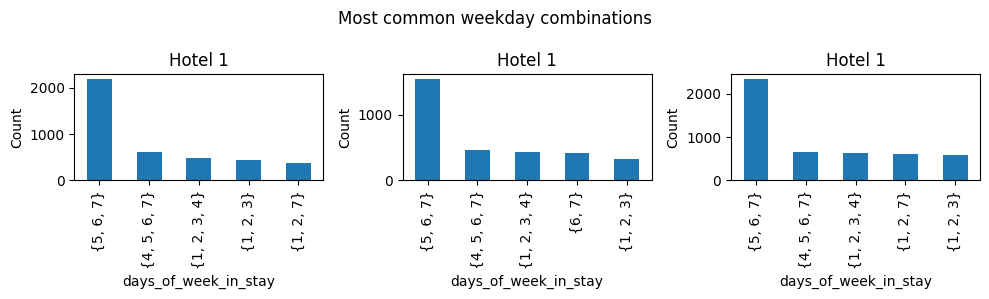

In [114]:
# most common weekday combinations
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(10,3))
hotel1['days_of_week_in_stay'].value_counts()[:5].plot(kind='bar', ax=ax1)
hotel2['days_of_week_in_stay'].value_counts()[:5].plot(kind='bar', ax=ax2)
hotel3['days_of_week_in_stay'].value_counts()[:5].plot(kind='bar', ax=ax3)
ax1.set_ylabel('Count')
ax2.set_ylabel('Count')
ax3.set_ylabel('Count')
fig.suptitle('Most common weekday combinations')
ax1.set_title('Hotel 1')
ax2.set_title('Hotel 1')
ax3.set_title('Hotel 1')
fig.tight_layout()

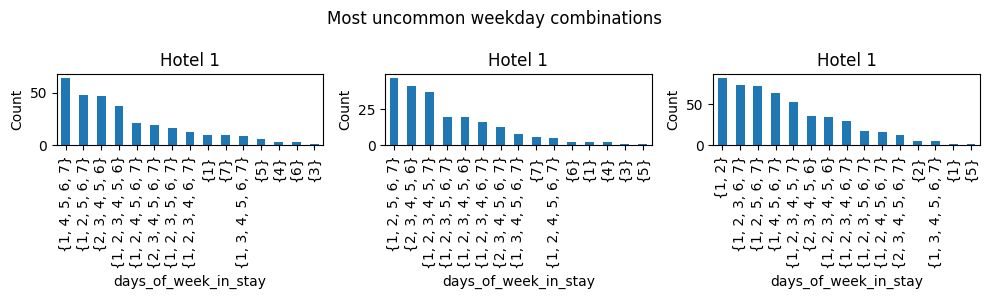

In [113]:
# most uncommon weekday combinations
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(10,3))
hotel1['days_of_week_in_stay'].value_counts()[-15:].plot(kind='bar', ax=ax1)
hotel2['days_of_week_in_stay'].value_counts()[-15:].plot(kind='bar', ax=ax2)
hotel3['days_of_week_in_stay'].value_counts()[-15:].plot(kind='bar', ax=ax3)
ax1.set_ylabel('Count')
ax2.set_ylabel('Count')
ax3.set_ylabel('Count')
fig.suptitle('Most uncommon weekday combinations')
ax1.set_title('Hotel 1')
ax2.set_title('Hotel 1')
ax3.set_title('Hotel 1')
fig.tight_layout()

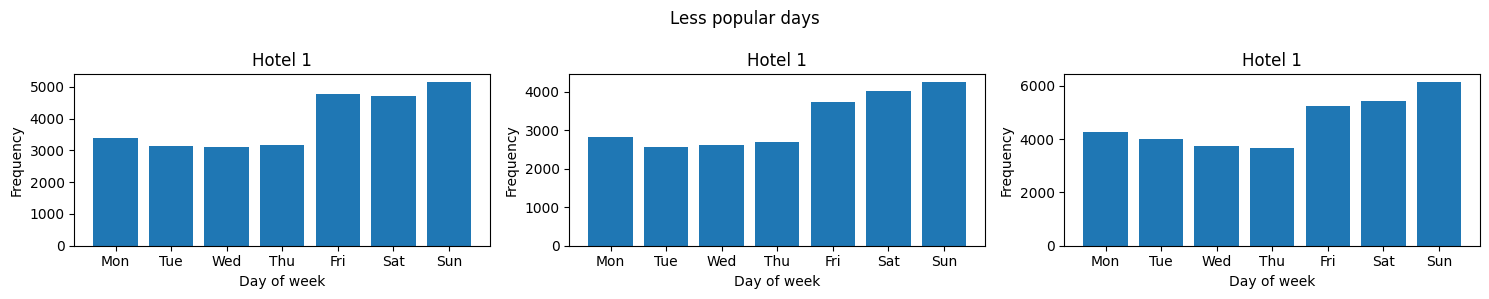

In [112]:
# which days are less popular?

from collections import Counter
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,3))
day_counts_h1 = Counter(day for days in hotel1[hotel1['conversion']==0]['days_of_week_in_stay'] for day in days)
day_counts_h2 = Counter(day for days in hotel2[hotel2['conversion']==0]['days_of_week_in_stay'] for day in days)
day_counts_h3 = Counter(day for days in hotel3[hotel3['conversion']==0]['days_of_week_in_stay'] for day in days)
ax1.bar(day_counts_h1.keys(), day_counts_h1.values())
ax2.bar(day_counts_h2.keys(), day_counts_h2.values())
ax3.bar(day_counts_h3.keys(), day_counts_h3.values())
fig.suptitle('Less popular days for searches WITHOUT conversion')
ax1.set_xticks(range(1, 8), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax2.set_xticks(range(1, 8), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax3.set_xticks(range(1, 8), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax1.set_ylabel("Frequency")
ax2.set_ylabel("Frequency")
ax3.set_ylabel("Frequency")
ax1.set_xlabel('Day of week')
ax2.set_xlabel('Day of week')
ax3.set_xlabel('Day of week')
ax1.set_title('Hotel 1')
ax2.set_title('Hotel 1')
ax3.set_title('Hotel 1')
fig.tight_layout()

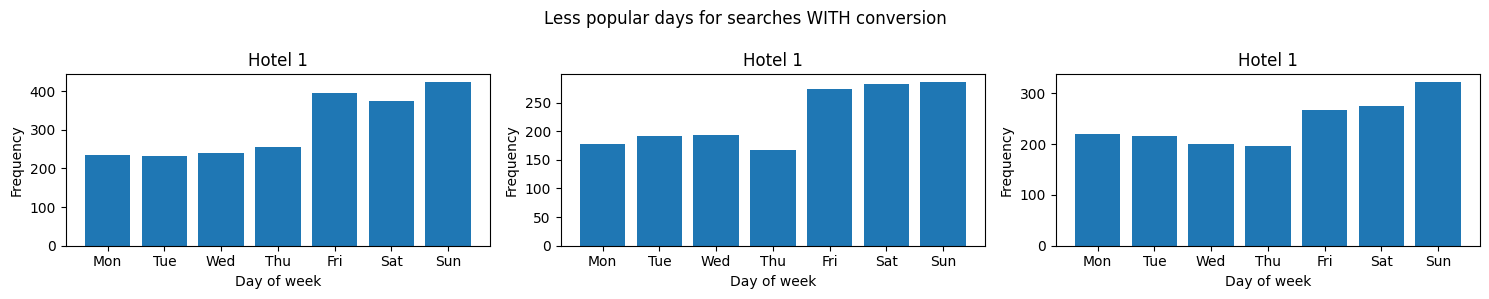

In [115]:
# which days are more popular?
from collections import Counter
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,3))
day_counts_h1 = Counter(day for days in hotel1[hotel1['conversion']==1]['days_of_week_in_stay'] for day in days)
day_counts_h2 = Counter(day for days in hotel2[hotel2['conversion']==1]['days_of_week_in_stay'] for day in days)
day_counts_h3 = Counter(day for days in hotel3[hotel3['conversion']==1]['days_of_week_in_stay'] for day in days)
ax1.bar(day_counts_h1.keys(), day_counts_h1.values())
ax2.bar(day_counts_h2.keys(), day_counts_h2.values())
ax3.bar(day_counts_h3.keys(), day_counts_h3.values())
fig.suptitle('Less popular days for searches WITH conversion')
ax1.set_xticks(range(1, 8), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax2.set_xticks(range(1, 8), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax3.set_xticks(range(1, 8), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax1.set_ylabel("Frequency")
ax2.set_ylabel("Frequency")
ax3.set_ylabel("Frequency")
ax1.set_xlabel('Day of week')
ax2.set_xlabel('Day of week')
ax3.set_xlabel('Day of week')
ax1.set_title('Hotel 1')
ax2.set_title('Hotel 1')
ax3.set_title('Hotel 1')
fig.tight_layout()

In [169]:
# Mean booked price/ night and mean upsell price according to stay includes a weekend or not
df[['stay_includes_weekend', 'hotel_id','total_price_p_night','upsell_total_price']].groupby(by=['hotel_id','stay_includes_weekend']).mean().style.format('{0:,.2f}').bar(color='#d65f5f')

In [116]:
# create a new table with search, conversion and sale volume data for each hotel
search_and_conversion1 = hotel1[['arrival','uuid','conversion', 'total_price_p_night','offered_price_median','offered_price_min','offered_price_max']].groupby(by='arrival').agg({'uuid':'count', 'conversion':'mean', 'total_price_p_night':'mean', 'offered_price_median':'mean', 'offered_price_min':'mean', 'offered_price_max':'mean'}).reset_index()
search_and_conversion2 = hotel2[['arrival','uuid','conversion', 'total_price_p_night','offered_price_median','offered_price_min','offered_price_max']].groupby(by='arrival').agg({'uuid':'count', 'conversion':'mean', 'total_price_p_night':'mean', 'offered_price_median':'mean', 'offered_price_min':'mean', 'offered_price_max':'mean'}).reset_index()
search_and_conversion3 = hotel3[['arrival','uuid','conversion', 'total_price_p_night','offered_price_median','offered_price_min','offered_price_max']].groupby(by='arrival').agg({'uuid':'count', 'conversion':'mean', 'total_price_p_night':'mean', 'offered_price_median':'mean', 'offered_price_min':'mean', 'offered_price_max':'mean'}).reset_index()

In [118]:
search_and_conversion1.head()

arrival  uuid  conversion  total_price_p_night  offered_price_median  \
0 2024-09-18    10    0.000000                  NaN         140408.908800   
1 2024-09-19    12    0.000000                  NaN         119754.698882   
2 2024-09-20    30    0.133333        111068.416250         121889.088301   
3 2024-09-21    36    0.083333         81545.206667         109018.371031   
4 2024-09-22    31    0.032258         66240.000000          99533.902610   

   offered_price_min  offered_price_max  
0      112154.467400      172714.241740  
1       94715.010909      151607.029927  
2      100679.494000      150119.449081  
3       87833.635097      139031.187412  
4       76599.396375      128393.489528

In [131]:
# create a new table with search, conversion and sale volume data for each hotel, BUT now remove the buplicated website visitors (keep only the last search for each visitor)
search_and_conversion1_unique = hotel1_unique[['arrival','uuid','conversion', 'total_price_p_night','offered_price_median','offered_price_min','offered_price_max']].groupby(by='arrival').agg({'uuid':'count', 'conversion':'mean', 'total_price_p_night':'mean', 'offered_price_median':'mean', 'offered_price_min':'mean', 'offered_price_max':'mean'}).reset_index()
search_and_conversion2_unique = hotel2_unique[['arrival','uuid','conversion', 'total_price_p_night','offered_price_median','offered_price_min','offered_price_max']].groupby(by='arrival').agg({'uuid':'count', 'conversion':'mean', 'total_price_p_night':'mean', 'offered_price_median':'mean', 'offered_price_min':'mean', 'offered_price_max':'mean'}).reset_index()
search_and_conversion3_unique = hotel3_unique[['arrival','uuid','conversion', 'total_price_p_night','offered_price_median','offered_price_min','offered_price_max']].groupby(by='arrival').agg({'uuid':'count', 'conversion':'mean', 'total_price_p_night':'mean', 'offered_price_median':'mean', 'offered_price_min':'mean', 'offered_price_max':'mean'}).reset_index()

Text(0.5, 0.98, 'Conversion and fill rate trends for\nHotel 1, Hotel 2 and Hotel 3')

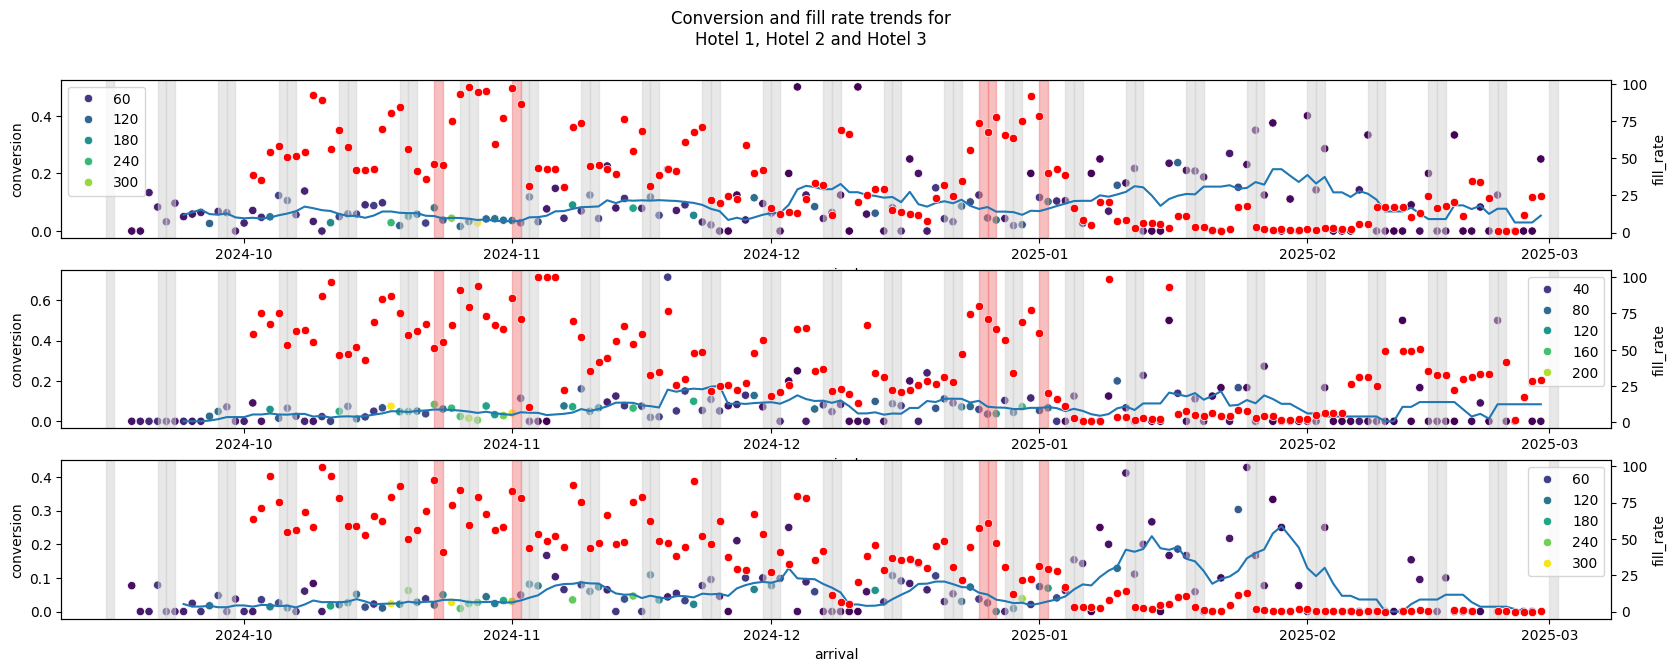

In [129]:
# what factors influences the conversion rate?
# what are the most searched time periods?

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(20,7))

sns.scatterplot(ax=ax1,
    data=search_and_conversion1[search_and_conversion1['arrival']<'2025-03-01'], 
    x='arrival',
    y='conversion', hue='uuid' ,palette='viridis')
sns.lineplot(ax=ax1,
    data=search_and_conversion1[search_and_conversion1['arrival']<'2025-03-01'], 
    x='arrival',
    y=search_and_conversion1[search_and_conversion1['arrival']<'2025-03-01']['conversion'].rolling(7).mean())
ax11 = ax1.twinx()
sns.scatterplot(ax=ax11, data=occupancy_hotel_1[occupancy_hotel_1['subject_date']<'2025-03-01'], x='subject_date', y='fill_rate', color='red')

sns.scatterplot(ax=ax2,
    data=search_and_conversion2[search_and_conversion2['arrival']<'2025-03-01'], 
    x='arrival',
    y='conversion', hue='uuid' ,palette='viridis')
sns.lineplot(ax=ax2,
    data=search_and_conversion2[search_and_conversion2['arrival']<'2025-03-01'], 
    x='arrival',
    y=search_and_conversion2[search_and_conversion2['arrival']<'2025-03-01']['conversion'].rolling(7).mean())
ax21 = ax2.twinx()
sns.scatterplot(ax=ax21, data=occupancy_hotel_2[occupancy_hotel_2['subject_date']<'2025-03-01'], x='subject_date', y='fill_rate', color='red')

sns.scatterplot(ax=ax3,
    data=search_and_conversion3[search_and_conversion3['arrival']<'2025-03-01'], 
    x='arrival',
    y='conversion', hue='uuid' ,palette='viridis')
sns.lineplot(ax=ax3,
    data=search_and_conversion3[search_and_conversion3['arrival']<'2025-03-01'], 
    x='arrival',
    y=search_and_conversion3[search_and_conversion3['arrival']<'2025-03-01']['conversion'].rolling(7).mean())
ax31 = ax3.twinx()
sns.scatterplot(ax=ax31, data=occupancy_hotel_3[occupancy_hotel_3['subject_date']<'2025-03-01'], x='subject_date', y='fill_rate', color='red')

# Highlight weekends
start_date = pd.to_datetime('2024-09-15')  # Adjust based on your data range
end_date = pd.to_datetime('2025-03-01')
current_date = start_date

while current_date <= end_date:
    if current_date.weekday() >= 5:  # Saturday (5) and Sunday (6)
        ax1.axvspan(current_date, current_date + timedelta(days=1), color='lightgrey', alpha=0.5, label='Weekend' if current_date == start_date else None)
        ax2.axvspan(current_date, current_date + timedelta(days=1), color='lightgrey', alpha=0.5, label='Weekend' if current_date == start_date else None)
        ax3.axvspan(current_date, current_date + timedelta(days=1), color='lightgrey', alpha=0.5, label='Weekend' if current_date == start_date else None)
    current_date += timedelta(days=1)

# Highlight public holidays
for holiday in public_holidays:
    if start_date <= holiday <= end_date:
        ax1.axvspan(holiday, holiday + timedelta(days=1), color='lightcoral', alpha=0.5, label='Public Holiday' if holiday == public_holidays[0] else None)
        ax2.axvspan(holiday, holiday + timedelta(days=1), color='lightcoral', alpha=0.5, label='Public Holiday' if holiday == public_holidays[0] else None)
        ax3.axvspan(holiday, holiday + timedelta(days=1), color='lightcoral', alpha=0.5, label='Public Holiday' if holiday == public_holidays[0] else None)
        
fig.suptitle('Conversion and fill rate trends for''\n''Hotel 1, Hotel 2 and Hotel 3')

Text(0.5, 0.98, 'Conversion and fill rate trends for\nHotel 1, Hotel 2 and Hotel 3\nfor uniqe guests')

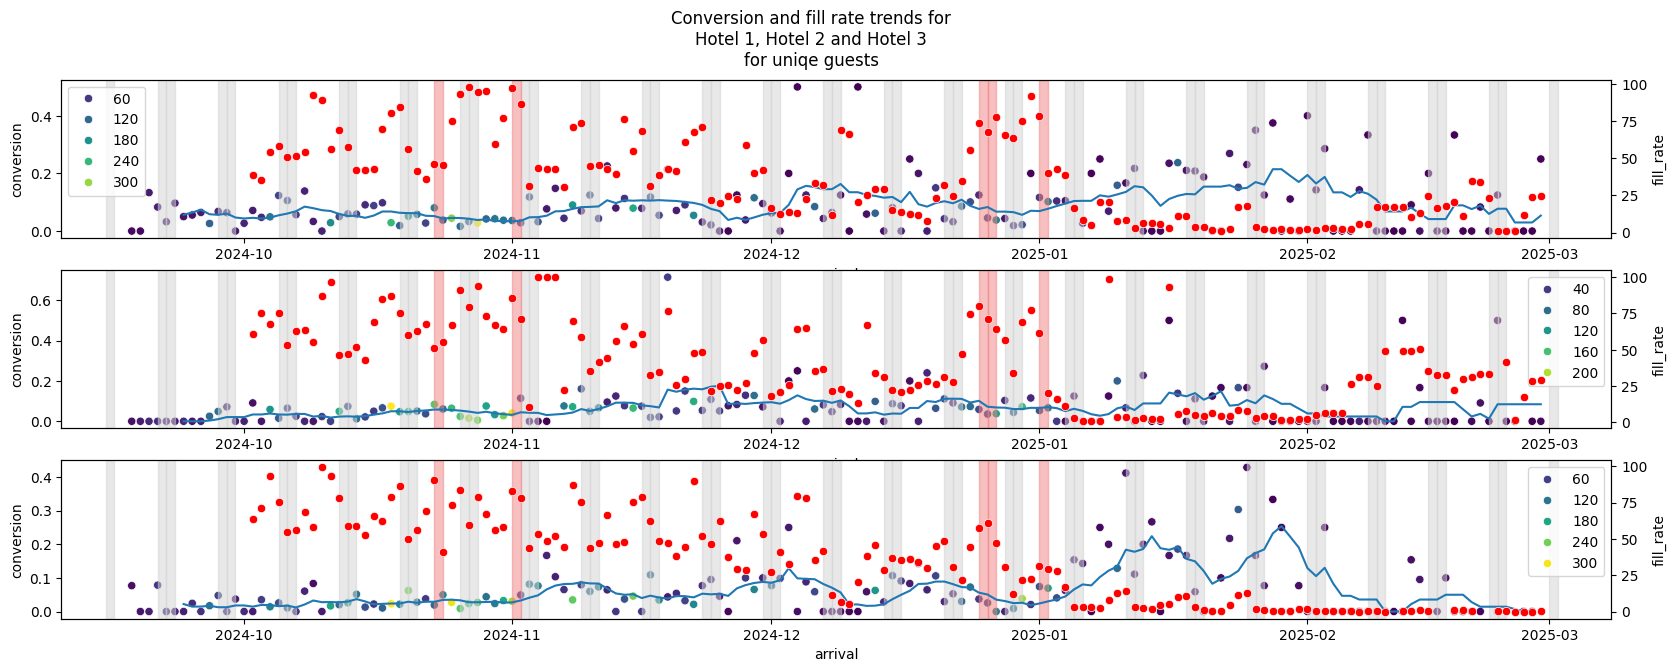

In [132]:
# do the same, but for unique guests
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(20,7))

sns.scatterplot(ax=ax1,
    data=search_and_conversion1_unique[search_and_conversion1_unique['arrival']<'2025-03-01'], 
    x='arrival',
    y='conversion', hue='uuid' ,palette='viridis')
sns.lineplot(ax=ax1,
    data=search_and_conversion1_unique[search_and_conversion1_unique['arrival']<'2025-03-01'], 
    x='arrival',
    y=search_and_conversion1_unique[search_and_conversion1_unique['arrival']<'2025-03-01']['conversion'].rolling(7).mean())
ax11 = ax1.twinx()
sns.scatterplot(ax=ax11, data=occupancy_hotel_1[occupancy_hotel_1['subject_date']<'2025-03-01'], x='subject_date', y='fill_rate', color='red')

sns.scatterplot(ax=ax2,
    data=search_and_conversion2_unique[search_and_conversion2_unique['arrival']<'2025-03-01'], 
    x='arrival',
    y='conversion', hue='uuid' ,palette='viridis')
sns.lineplot(ax=ax2,
    data=search_and_conversion2_unique[search_and_conversion2_unique['arrival']<'2025-03-01'], 
    x='arrival',
    y=search_and_conversion2_unique[search_and_conversion2_unique['arrival']<'2025-03-01']['conversion'].rolling(7).mean())
ax21 = ax2.twinx()
sns.scatterplot(ax=ax21, data=occupancy_hotel_2[occupancy_hotel_2['subject_date']<'2025-03-01'], x='subject_date', y='fill_rate', color='red')

sns.scatterplot(ax=ax3,
    data=search_and_conversion3_unique[search_and_conversion3_unique['arrival']<'2025-03-01'], 
    x='arrival',
    y='conversion', hue='uuid' ,palette='viridis')
sns.lineplot(ax=ax3,
    data=search_and_conversion3_unique[search_and_conversion3_unique['arrival']<'2025-03-01'], 
    x='arrival',
    y=search_and_conversion3_unique[search_and_conversion3_unique['arrival']<'2025-03-01']['conversion'].rolling(7).mean())
ax31 = ax3.twinx()
sns.scatterplot(ax=ax31, data=occupancy_hotel_3[occupancy_hotel_3['subject_date']<'2025-03-01'], x='subject_date', y='fill_rate', color='red')

# Highlight weekends
start_date = pd.to_datetime('2024-09-15')  # Adjust based on your data range
end_date = pd.to_datetime('2025-03-01')
current_date = start_date

while current_date <= end_date:
    if current_date.weekday() >= 5:  # Saturday (5) and Sunday (6)
        ax1.axvspan(current_date, current_date + timedelta(days=1), color='lightgrey', alpha=0.5, label='Weekend' if current_date == start_date else None)
        ax2.axvspan(current_date, current_date + timedelta(days=1), color='lightgrey', alpha=0.5, label='Weekend' if current_date == start_date else None)
        ax3.axvspan(current_date, current_date + timedelta(days=1), color='lightgrey', alpha=0.5, label='Weekend' if current_date == start_date else None)
    current_date += timedelta(days=1)

# Highlight public holidays
for holiday in public_holidays:
    if start_date <= holiday <= end_date:
        ax1.axvspan(holiday, holiday + timedelta(days=1), color='lightcoral', alpha=0.5, label='Public Holiday' if holiday == public_holidays[0] else None)
        ax2.axvspan(holiday, holiday + timedelta(days=1), color='lightcoral', alpha=0.5, label='Public Holiday' if holiday == public_holidays[0] else None)
        ax3.axvspan(holiday, holiday + timedelta(days=1), color='lightcoral', alpha=0.5, label='Public Holiday' if holiday == public_holidays[0] else None)
        
fig.suptitle('Conversion and fill rate trends for''\n''Hotel 1, Hotel 2 and Hotel 3''\n''for uniqe guests')

Text(0, 0.5, 'Offered price [HUF]')

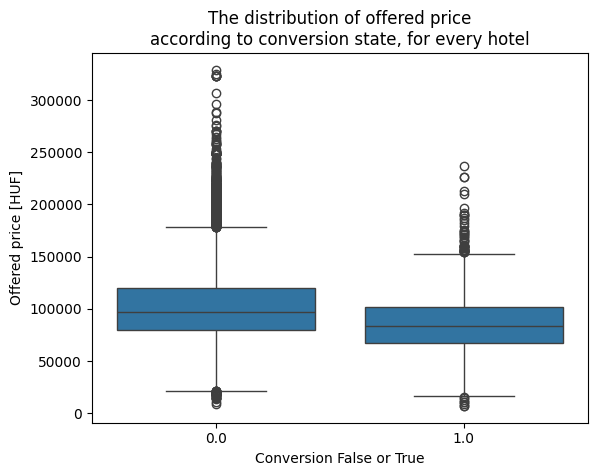

In [135]:
# Did the offered price differ between booked and non-booked cases?
sns.boxplot(y=df_unique['offered_price_median'], x=df_unique['conversion'])
plt.title('The distribution of offered price''\n''according to conversion state, for every hotel')
plt.xlabel('Conversion False or True')
plt.ylabel('Offered price [HUF]')

### Why the conversion is lower in certain days?

Text(0.5, 0.98, 'Why the conversion is lower in certain days?')

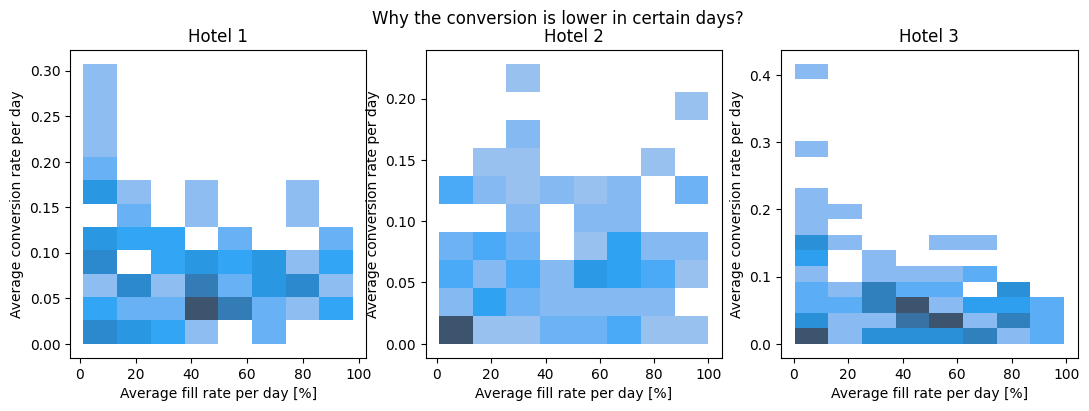

In [151]:
# why the conversion is lower in certain days?
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(13,4))
sns.histplot(ax=ax1, data=occupancy_hotel_1[occupancy_hotel_1['subject_date']<'2025-02-01'], x='fill_rate', y='conversion')
sns.histplot(ax=ax2, data=occupancy_hotel_2[occupancy_hotel_2['subject_date']<'2025-02-01'], x='fill_rate', y='conversion')
sns.histplot(ax=ax3, data=occupancy_hotel_3[occupancy_hotel_3['subject_date']<'2025-02-01'], x='fill_rate', y='conversion')
ax1.set_xlabel('Average fill rate per day [%]')
ax2.set_xlabel('Average fill rate per day [%]')
ax3.set_xlabel('Average fill rate per day [%]')
ax1.set_ylabel('Average conversion rate per day')
ax2.set_ylabel('Average conversion rate per day')
ax3.set_ylabel('Average conversion rate per day')
ax1.set_title('Hotel 1')
ax2.set_title('Hotel 2')
ax3.set_title('Hotel 3')
fig.suptitle('Why the conversion is lower in certain days?')

In [157]:
# pull out 'bad days' to a new table, where both the fill rate and conversion rate are low
bad_days_hotel1 = occupancy_hotel_1[(occupancy_hotel_1['fill_rate']<50) & (occupancy_hotel_1['conversion']<0.075)]['subject_date']
bad_days_hotel2 = occupancy_hotel_2[(occupancy_hotel_2['fill_rate']<30) & (occupancy_hotel_2['conversion']<0.04)]['subject_date']
bad_days_hotel3 = occupancy_hotel_3[(occupancy_hotel_3['fill_rate']<30) & (occupancy_hotel_3['conversion']<0.05)]['subject_date']
# Convert to a set for fast lookup
bad_days_set = set(bad_days_hotel1)
hotel1['is_bad_day'] = hotel1['arrival'].apply(lambda x: x in bad_days_set)
bad_days_set = set(bad_days_hotel2)
hotel2['is_bad_day'] = hotel2['arrival'].apply(lambda x: x in bad_days_set)
bad_days_set = set(bad_days_hotel3)
hotel3['is_bad_day'] = hotel3['arrival'].apply(lambda x: x in bad_days_set)

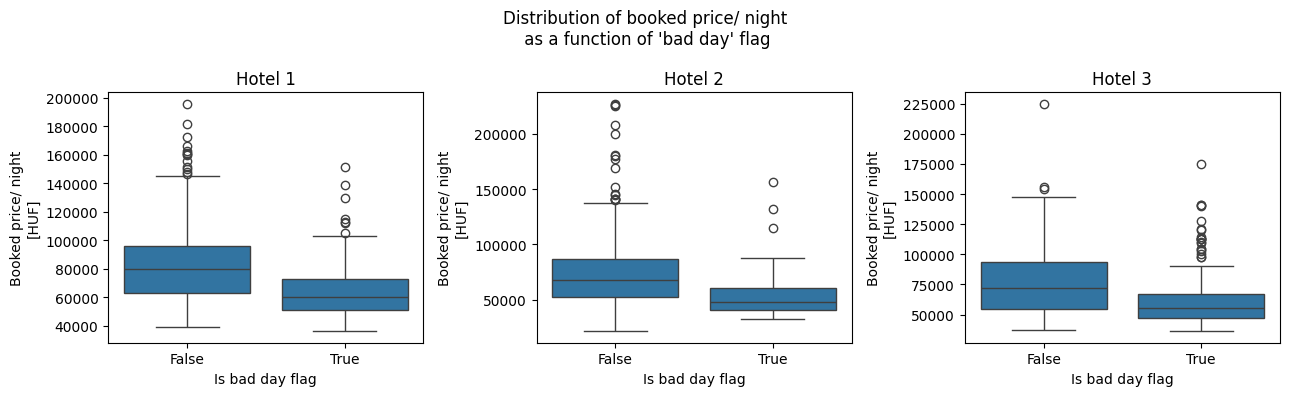

In [158]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(13,4))
sns.boxplot(ax=ax1, data=hotel1[['is_bad_day','total_price_p_night']], x='is_bad_day', y='total_price_p_night')
sns.boxplot(ax=ax2, data=hotel2[['is_bad_day','total_price_p_night']], x='is_bad_day', y='total_price_p_night')
sns.boxplot(ax=ax3, data=hotel3[['is_bad_day','total_price_p_night']], x='is_bad_day', y='total_price_p_night')
ax1.set_xlabel('Is bad day flag')
ax2.set_xlabel('Is bad day flag')
ax3.set_xlabel('Is bad day flag')
ax1.set_ylabel('Booked price/ night''\n''[HUF]')
ax2.set_ylabel('Booked price/ night''\n''[HUF]')
ax3.set_ylabel('Booked price/ night''\n''[HUF]')
ax1.set_title('Hotel 1')
ax2.set_title('Hotel 2')
ax3.set_title('Hotel 3')
fig.suptitle("Distribution of booked price/ night""\n"" as a function of 'bad day' flag")
fig.tight_layout()

In [ ]:
# general differences between bad and good days
hotel1[['is_bad_day','offered_price_median', 'offered_price_min','offered_price_max','arrival_day_of_week','arrival_is_holiday','departure_is_holiday','stay_includes_weekend']].groupby(by='is_bad_day').mean()

offered_price_median  offered_price_min  offered_price_max  \
is_bad_day                                                               
False               98470.660003       82951.133897      118529.962704   
True                85626.208423       67421.767571      108652.798238   

            arrival_day_of_week  arrival_is_holiday  departure_is_holiday  \
is_bad_day                                                                  
False                  4.370218            0.348245              0.575877   
True                   3.944021            0.286162              0.487237   

            stay_includes_weekend  
is_bad_day                         
False                    0.836231  
True                     0.779221

In [159]:
hotel2[['is_bad_day','offered_price_median', 'offered_price_min','offered_price_max','arrival_day_of_week','arrival_is_holiday','departure_is_holiday','stay_includes_weekend']].groupby(by='is_bad_day').mean()

offered_price_median  offered_price_min  offered_price_max  \
is_bad_day                                                               
False               93518.021269       77833.400161      112369.351952   
True                75536.343951       56314.517082       99379.744910   

            arrival_day_of_week  arrival_is_holiday  departure_is_holiday  \
is_bad_day                                                                  
False                  4.299563            0.386703              0.542892   
True                   4.212000            0.358000              0.394000   

            stay_includes_weekend  
is_bad_day                         
False                    0.830243  
True                     0.716000

In [160]:
hotel3[['is_bad_day','offered_price_median', 'offered_price_min','offered_price_max','arrival_day_of_week','arrival_is_holiday','departure_is_holiday','stay_includes_weekend']].groupby(by='is_bad_day').mean()

offered_price_median  offered_price_min  offered_price_max  \
is_bad_day                                                               
False              116548.650174       90980.461949      148245.568600   
True                94074.954111       70596.185391      127183.963759   

            arrival_day_of_week  arrival_is_holiday  departure_is_holiday  \
is_bad_day                                                                  
False                  4.261817            0.329827              0.515336   
True                   4.454432            0.422285              0.518414   

            stay_includes_weekend  
is_bad_day                         
False                    0.815676  
True                     0.819600

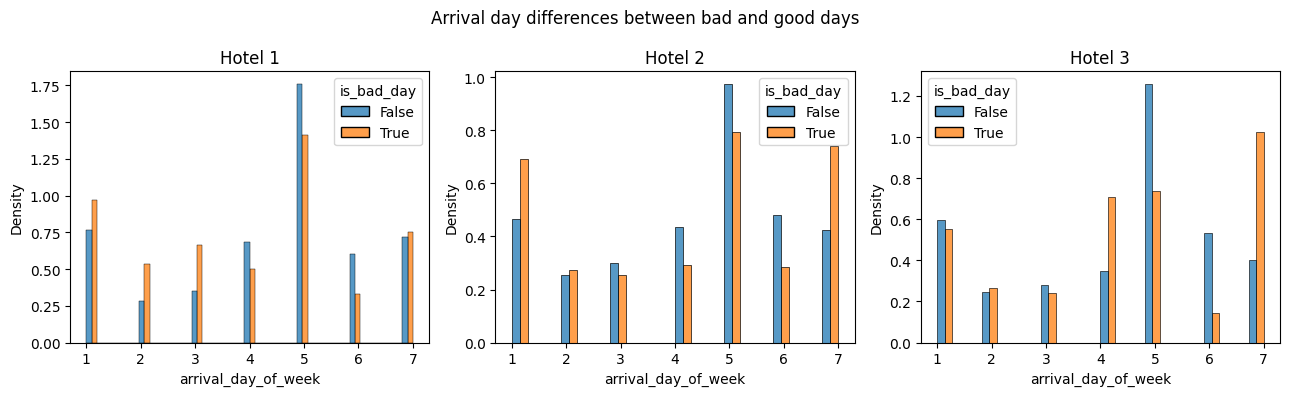

In [162]:
# arrival day differences between bad and good days
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(13,4))
sns.histplot(ax=ax1, data=hotel1, x='arrival_day_of_week', hue='is_bad_day', multiple="dodge", stat = 'density', common_norm=False)
sns.histplot(ax=ax2, data=hotel2, x='arrival_day_of_week', hue='is_bad_day', multiple="dodge", stat = 'density', common_norm=False)
sns.histplot(ax=ax3, data=hotel3, x='arrival_day_of_week', hue='is_bad_day', multiple="dodge", stat = 'density', common_norm=False)
ax1.set_title('Hotel 1')
ax2.set_title('Hotel 2')
ax3.set_title('Hotel 3')
fig.suptitle('Arrival day differences between bad and good days')
fig.tight_layout()

Text(0.5, 0.98, 'Change of fill rate during the observed time period')

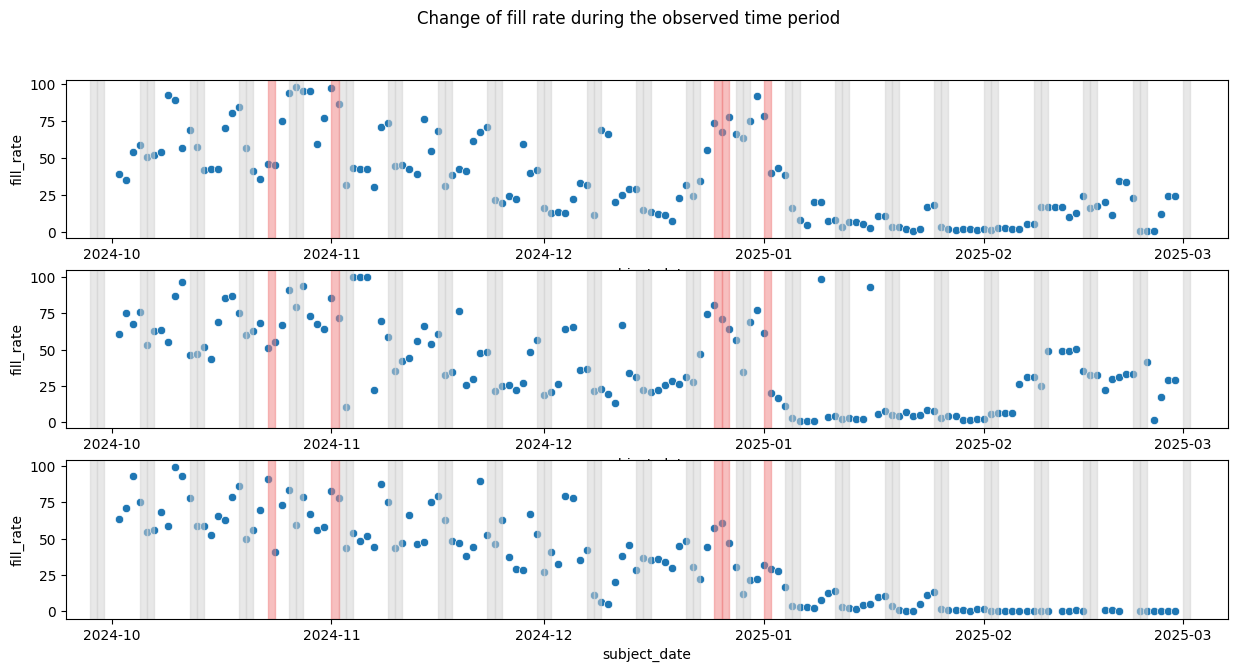

In [170]:
# check the change of fill rate during the observed time period for hidden patterns

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(15,7))

sns.scatterplot(ax=ax1, data=occupancy_hotel_1[occupancy_hotel_1['subject_date']<'2025-03-01'], x='subject_date', y='fill_rate')
sns.scatterplot(ax=ax2, data=occupancy_hotel_2[occupancy_hotel_2['subject_date']<'2025-03-01'], x='subject_date', y='fill_rate')
sns.scatterplot(ax=ax3, data=occupancy_hotel_3[occupancy_hotel_3['subject_date']<'2025-03-01'], x='subject_date', y='fill_rate')

# highlight weekends
start_date = pd.to_datetime('2024-09-15')  # Adjust based on your data range
end_date = pd.to_datetime('2025-03-01')
current_date = start_date

while current_date <= end_date:
    if current_date.weekday() >= 5:  # Saturday (5) and Sunday (6)
        ax1.axvspan(current_date, current_date + timedelta(days=1), color='lightgrey', alpha=0.5, label='Weekend' if current_date == start_date else None)
        ax2.axvspan(current_date, current_date + timedelta(days=1), color='lightgrey', alpha=0.5, label='Weekend' if current_date == start_date else None)
        ax3.axvspan(current_date, current_date + timedelta(days=1), color='lightgrey', alpha=0.5, label='Weekend' if current_date == start_date else None)
    current_date += timedelta(days=1)

# highlight public holidays
for holiday in public_holidays:
    if start_date <= holiday <= end_date:
        ax1.axvspan(holiday, holiday + timedelta(days=1), color='lightcoral', alpha=0.5, label='Public Holiday' if holiday == public_holidays[0] else None)
        ax2.axvspan(holiday, holiday + timedelta(days=1), color='lightcoral', alpha=0.5, label='Public Holiday' if holiday == public_holidays[0] else None)
        ax3.axvspan(holiday, holiday + timedelta(days=1), color='lightcoral', alpha=0.5, label='Public Holiday' if holiday == public_holidays[0] else None)
        
fig.suptitle('Change of fill rate during the observed time period')

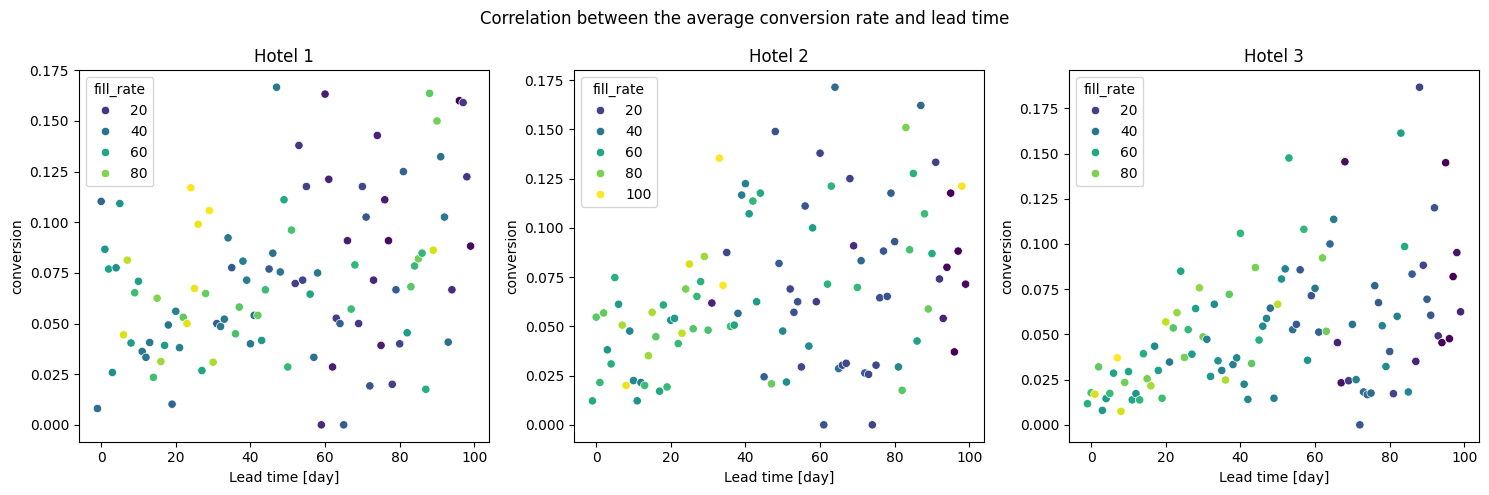

In [168]:
# correlation between the average conversion rate and lead time, and with fill rate on the third dimension

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
sns.scatterplot(ax=ax1, data=occupancy_hotel_1[(occupancy_hotel_1['conversion']<0.2) & (occupancy_hotel_1['days_until_stay']<100)], x='days_until_stay', y='conversion', hue='fill_rate', palette='viridis')
sns.scatterplot(ax=ax2, data=occupancy_hotel_2[(occupancy_hotel_2['conversion']<0.2) & (occupancy_hotel_2['days_until_stay']<100)], x='days_until_stay', y='conversion', hue='fill_rate', palette='viridis')
sns.scatterplot(ax=ax3, data=occupancy_hotel_3[(occupancy_hotel_3['conversion']<0.2) & (occupancy_hotel_3['days_until_stay']<100)], x='days_until_stay', y='conversion', hue='fill_rate', palette='viridis')
ax1.set_xlabel('Lead time [day]')
ax2.set_xlabel('Lead time [day]')
ax3.set_xlabel('Lead time [day]')
ax1.set_title('Hotel 1')
ax2.set_title('Hotel 2')
ax3.set_title('Hotel 3')
fig.suptitle('Correlation between the average conversion rate and lead time')
fig.tight_layout()

Text(0.5, 0.98, 'Average booking price/ night and conversion rate during the observed time period')

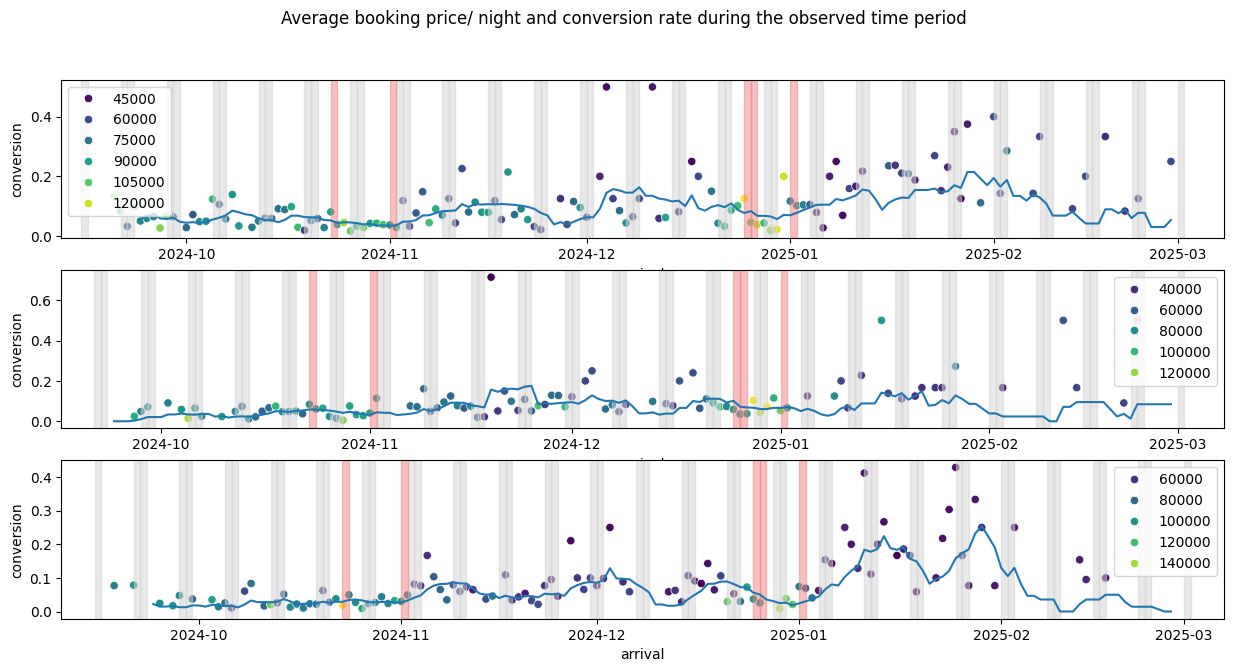

In [169]:
# comparison of the average booking price/ night and conversion rate during the observed time period
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(15,7))

sns.scatterplot(ax=ax1,
    data=search_and_conversion1[search_and_conversion1['arrival']<'2025-03-01'], 
    x='arrival',
    y='conversion', hue='total_price_p_night' ,palette='viridis')
sns.lineplot(ax=ax1,
    data=search_and_conversion1[search_and_conversion1['arrival']<'2025-03-01'], 
    x='arrival',
    y=search_and_conversion1[search_and_conversion1['arrival']<'2025-03-01']['conversion'].rolling(7).mean())

sns.scatterplot(ax=ax2,
    data=search_and_conversion2[search_and_conversion2['arrival']<'2025-03-01'], 
    x='arrival',
    y='conversion', hue='total_price_p_night' ,palette='viridis')
sns.lineplot(ax=ax2,
    data=search_and_conversion2[search_and_conversion2['arrival']<'2025-03-01'], 
    x='arrival',
    y=search_and_conversion2[search_and_conversion2['arrival']<'2025-03-01']['conversion'].rolling(7).mean())

sns.scatterplot(ax=ax3,
    data=search_and_conversion3[search_and_conversion3['arrival']<'2025-03-01'], 
    x='arrival',
    y='conversion', hue='total_price_p_night' ,palette='viridis')
sns.lineplot(ax=ax3,
    data=search_and_conversion3[search_and_conversion3['arrival']<'2025-03-01'], 
    x='arrival',
    y=search_and_conversion3[search_and_conversion3['arrival']<'2025-03-01']['conversion'].rolling(7).mean())

# highlight weekends
start_date = pd.to_datetime('2024-09-15')  # Adjust based on your data range
end_date = pd.to_datetime('2025-03-01')
current_date = start_date

while current_date <= end_date:
    if current_date.weekday() >= 5:  # Saturday (5) and Sunday (6)
        ax1.axvspan(current_date, current_date + timedelta(days=1), color='lightgrey', alpha=0.5, label='Weekend' if current_date == start_date else None)
        ax2.axvspan(current_date, current_date + timedelta(days=1), color='lightgrey', alpha=0.5, label='Weekend' if current_date == start_date else None)
        ax3.axvspan(current_date, current_date + timedelta(days=1), color='lightgrey', alpha=0.5, label='Weekend' if current_date == start_date else None)
    current_date += timedelta(days=1)

# highlight public holidays
for holiday in public_holidays:
    if start_date <= holiday <= end_date:
        ax1.axvspan(holiday, holiday + timedelta(days=1), color='lightcoral', alpha=0.5, label='Public Holiday' if holiday == public_holidays[0] else None)
        ax2.axvspan(holiday, holiday + timedelta(days=1), color='lightcoral', alpha=0.5, label='Public Holiday' if holiday == public_holidays[0] else None)
        ax3.axvspan(holiday, holiday + timedelta(days=1), color='lightcoral', alpha=0.5, label='Public Holiday' if holiday == public_holidays[0] else None)
        
fig.suptitle('Average booking price/ night and conversion rate during the observed time period')

In [201]:
# --> Consequence: As the lead time increases, the number of conversions and vacancies also increases, but the cause and effect is unknown????

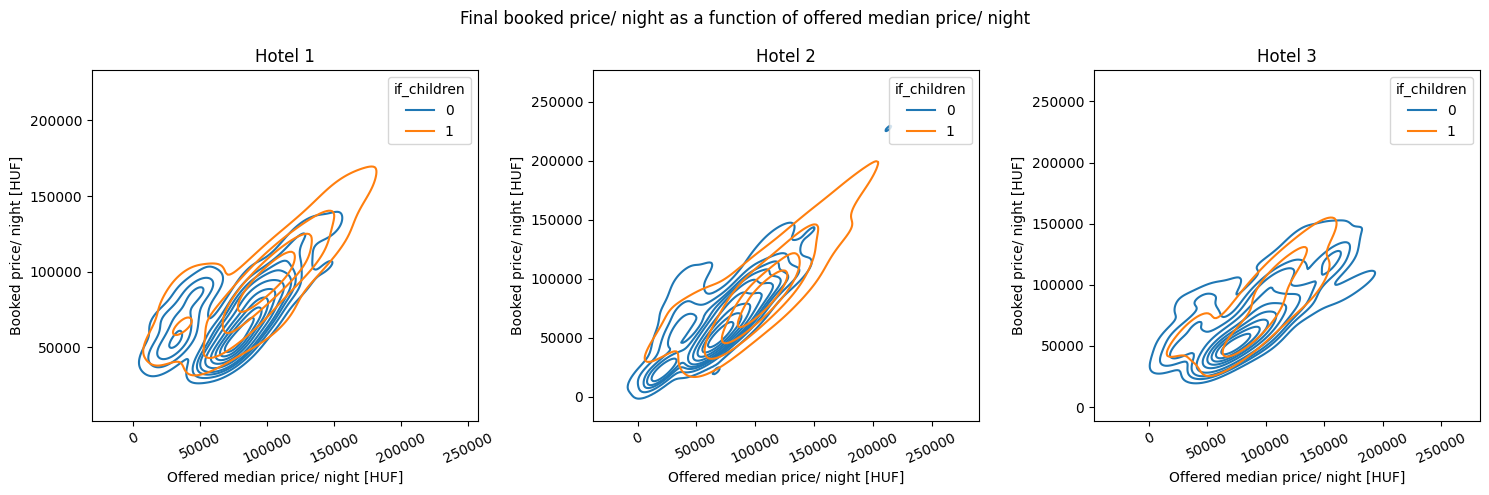

In [177]:
# Final booked price/ night as a function of offered median price/ night
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
sns.kdeplot(ax=ax1, data=hotel1, x='offered_price_median', y='total_price_p_night', hue='if_children').tick_params(axis='x', rotation=25)
sns.kdeplot(ax=ax2, data=hotel2, x='offered_price_median', y='total_price_p_night', hue='if_children').tick_params(axis='x', rotation=25)
sns.kdeplot(ax=ax3, data=hotel3, x='offered_price_median', y='total_price_p_night', hue='if_children').tick_params(axis='x', rotation=25)
ax1.set_title('Hotel 1')
ax2.set_title('Hotel 2')
ax3.set_title('Hotel 3')
ax1.set_xlabel('Offered median price/ night [HUF]')
ax2.set_xlabel('Offered median price/ night [HUF]')
ax3.set_xlabel('Offered median price/ night [HUF]')
ax1.set_ylabel('Booked price/ night [HUF]')
ax2.set_ylabel('Booked price/ night [HUF]')
ax3.set_ylabel('Booked price/ night [HUF]')
fig.suptitle('Final booked price/ night as a function of offered median price/ night')
fig.tight_layout()

In [206]:
# final booked price/ night with and without children for Hotel 1
pd.concat([hotel1[hotel1['if_children']==0][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
hotel1[hotel1['if_children']==1][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'] ], axis=1)

# nagyon valószínű, hogy a legolcsóbb ajánlatot választják
# ha van gyerek akkor nő az esélye, hogy drágább szobát választnanak

total_price_p_night  total_price_p_night
offered_price_min                0.754306             0.859784
offered_price_median             0.696816             0.809843
offered_price_max                0.533806             0.721102
total_price_p_night              1.000000             1.000000

In [207]:
# final booked price/ night with and without children for Hotel 2
pd.concat([hotel2[hotel2['if_children']==0][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
hotel2[hotel2['if_children']==1][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'] ], axis=1)

total_price_p_night  total_price_p_night
offered_price_min                0.843524             0.921419
offered_price_median             0.802602             0.796035
offered_price_max                0.676277             0.457341
total_price_p_night              1.000000             1.000000

In [208]:
# final booked price/ night with and without children for Hotel 3
pd.concat([hotel3[hotel3['if_children']==0][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
hotel3[hotel3['if_children']==1][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'] ], axis=1)

total_price_p_night  total_price_p_night
offered_price_min                0.789204             0.891441
offered_price_median             0.727607             0.823170
offered_price_max                0.628050             0.545638
total_price_p_night              1.000000             1.000000

### UTM medium and source related analysis

In [209]:
hotel3['utm_medium'].unique()

array(['(not set)', 'organic', 'cpc', 'referral', 'direct', 'ct', 'other',
       'offline', 'email'], dtype=object)

In [178]:
# create correlation tables for subsequent analysis
mediums_corr1 = pd.concat(
    [hotel1[hotel1['utm_medium']=='cpc'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['utm_medium']=='referral'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['utm_medium']=='direct'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['utm_medium']=='organic'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['utm_medium']=='ct'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['utm_medium']=='other'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['utm_medium']=='offline'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['utm_medium']=='email'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night']], axis=1).set_axis(['cpc', 'referral', 'direct', 'organic', 'ct', 'other', 'offline', 'email'], axis=1).drop(index='total_price_p_night')

mediums_corr2 = pd.concat(
    [hotel2[hotel2['utm_medium']=='cpc'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel2[hotel2['utm_medium']=='referral'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel2[hotel2['utm_medium']=='direct'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel2[hotel2['utm_medium']=='organic'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel2[hotel2['utm_medium']=='ct'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel2[hotel2['utm_medium']=='other'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel2[hotel2['utm_medium']=='offline'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel2[hotel2['utm_medium']=='email'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night']], axis=1).set_axis(['cpc', 'referral', 'direct', 'organic', 'ct', 'other', 'offline', 'email'], axis=1).drop(index='total_price_p_night')

mediums_corr3 = pd.concat(
    [hotel3[hotel3['utm_medium']=='cpc'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel3[hotel3['utm_medium']=='referral'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel3[hotel3['utm_medium']=='direct'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel3[hotel3['utm_medium']=='organic'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel3[hotel3['utm_medium']=='ct'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel3[hotel3['utm_medium']=='other'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel3[hotel3['utm_medium']=='offline'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel3[hotel3['utm_medium']=='email'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night']], axis=1).set_axis(['cpc', 'referral', 'direct', 'organic', 'ct', 'other', 'offline', 'email'], axis=1).drop(index='total_price_p_night')

In [ ]:
# same with utm source data
source_corr = pd.concat(
    [hotel1[hotel1['utm_source']=='facebook'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['utm_source']=='google'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['utm_source']=='other'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['utm_source']=='bing'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['utm_source']=='instagram'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night']], axis=1).set_axis(['facebook', 'google', 'other', 'bing', 'instagram'], axis=1).drop(index='total_price_p_night')

In [181]:
# correlation with stay duration (number of nights) into tables
nights_corr1 = pd.concat(
    [hotel1[hotel1['nights']==1][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['nights']==2][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['nights']==3][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['nights']==4][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['nights']==5][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['nights']==6][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['nights']==7][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['nights']==8][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night']],
     axis=1).set_axis(['1', '2', '3', '4', '5', '6', '7', '8'], axis=1).drop(index='total_price_p_night')

nights_corr2 = pd.concat(
    [hotel2[hotel2['nights']==1][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel2[hotel2['nights']==2][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel2[hotel2['nights']==3][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel2[hotel2['nights']==4][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel2[hotel2['nights']==5][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel2[hotel2['nights']==6][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel2[hotel2['nights']==7][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel2[hotel2['nights']==8][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night']],
     axis=1).set_axis(['1', '2', '3', '4', '5', '6', '7', '8'], axis=1).drop(index='total_price_p_night')

nights_corr3 = pd.concat(
    [hotel3[hotel3['nights']==1][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel3[hotel3['nights']==2][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel3[hotel3['nights']==3][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel3[hotel3['nights']==4][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel3[hotel3['nights']==5][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel3[hotel3['nights']==6][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel3[hotel3['nights']==7][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel3[hotel3['nights']==8][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night']],
     axis=1).set_axis(['1', '2', '3', '4', '5', '6', '7', '8'], axis=1).drop(index='total_price_p_night')

In [184]:
# same with number of childs
children_corr = pd.concat(
    [hotel1[hotel1['children']==0][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['children']==1][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['children']==2][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['children']==3][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['children']==4][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['children']==5][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night']],
     axis=1).set_axis(['0','1', '2', '3', '4', '5'], axis=1).drop(index='total_price_p_night')

In [187]:
# same as above, but with of without children flag
if_children_corr = pd.concat(
    [hotel1[hotel1['if_children']==0][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['if_children']==1][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night']],
     axis=1).set_axis(['0','1'], axis=1).drop(index='total_price_p_night')

In [192]:
# booked price correlation with children age in booking
children_age_corr1 = pd.concat(
    [hotel1[hotel1['children_age_mean']<=7][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[(hotel1['children_age_mean']>7) & (hotel1['children_age_mean']<=12)][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['children_age_mean']>12][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night']],
     axis=1).set_axis(['<=7','7-12','>12'], axis=1).drop(index='total_price_p_night')

children_age_corr2 = pd.concat(
    [hotel2[hotel2['children_age_mean']<=7][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel2[(hotel2['children_age_mean']>7) & (hotel2['children_age_mean']<=12)][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel2[hotel2['children_age_mean']>12][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night']],
     axis=1).set_axis(['<=7','7-12','>12'], axis=1).drop(index='total_price_p_night')

children_age_corr3 = pd.concat(
    [hotel3[hotel3['children_age_mean']<=7][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel3[(hotel3['children_age_mean']>7) & (hotel3['children_age_mean']<=12)][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel3[hotel3['children_age_mean']>12][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night']],
     axis=1).set_axis(['<=7','7-12','>12'], axis=1).drop(index='total_price_p_night')
lead_time_corr1 = pd.concat(
    [hotel1[hotel1['lead_time_category']=='last_minute'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['lead_time_category']=='short_term'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['lead_time_category']=='medium_term'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel1[hotel1['lead_time_category']=='long_term'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night']],
     axis=1).set_axis(['last_minute','short_term','medium_term','long_term'], axis=1).drop(index='total_price_p_night')

lead_time_corr2 = pd.concat(
    [hotel2[hotel2['lead_time_category']=='last_minute'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel2[hotel2['lead_time_category']=='short_term'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel2[hotel2['lead_time_category']=='medium_term'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel2[hotel2['lead_time_category']=='long_term'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night']],
     axis=1).set_axis(['last_minute','short_term','medium_term','long_term'], axis=1).drop(index='total_price_p_night')

lead_time_corr3 = pd.concat(
    [hotel3[hotel3['lead_time_category']=='last_minute'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel3[hotel3['lead_time_category']=='short_term'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel3[hotel3['lead_time_category']=='medium_term'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night'],
     hotel3[hotel3['lead_time_category']=='long_term'][['offered_price_min','offered_price_median','offered_price_max','total_price_p_night']].corr(method='spearman')['total_price_p_night']],
     axis=1).set_axis(['last_minute','short_term','medium_term','long_term'], axis=1).drop(index='total_price_p_night')

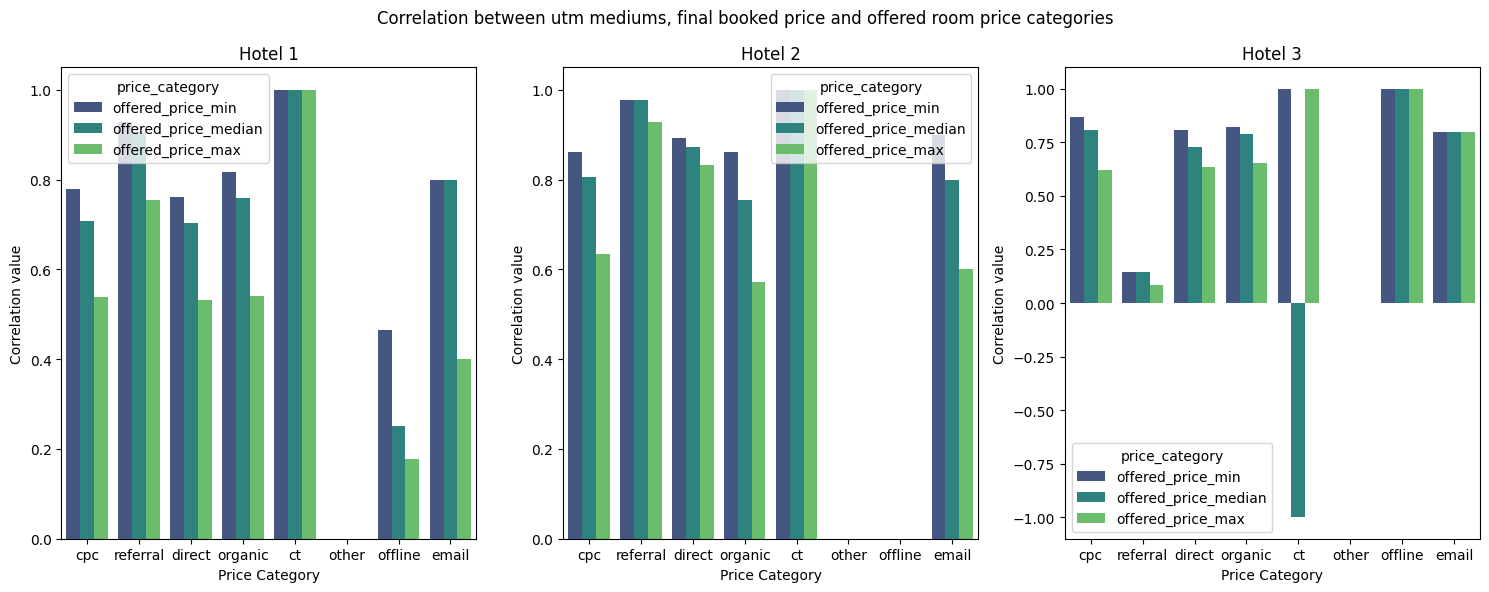

In [185]:
# correlations between utm mediums and offered room price categories
# to tidy format
df_tidy1 = mediums_corr1.reset_index().melt(id_vars="index", var_name="utm_medium", value_name="value")
df_tidy1.rename(columns={"index": "price_category"}, inplace=True)

df_tidy2 = mediums_corr2.reset_index().melt(id_vars="index", var_name="utm_medium", value_name="value")
df_tidy2.rename(columns={"index": "price_category"}, inplace=True)

df_tidy3 = mediums_corr3.reset_index().melt(id_vars="index", var_name="utm_medium", value_name="value")
df_tidy3.rename(columns={"index": "price_category"}, inplace=True)

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15, 6))
sns.barplot(ax=ax1, data=df_tidy1, hue="price_category", y="value", x="utm_medium", palette="viridis")
sns.barplot(ax=ax2, data=df_tidy2, hue="price_category", y="value", x="utm_medium", palette="viridis")
sns.barplot(ax=ax3, data=df_tidy3, hue="price_category", y="value", x="utm_medium", palette="viridis")
ax1.set_ylabel("Correlation value")
ax2.set_ylabel("Correlation value")
ax3.set_ylabel("Correlation value")
ax1.set_xlabel("Price Category")
ax2.set_xlabel("Price Category")
ax3.set_xlabel("Price Category")
ax1.set_title('Hotel 1')
ax2.set_title('Hotel 2')
ax3.set_title('Hotel 3')
fig.suptitle('Correlation between utm mediums, final booked price and offered room price categories')
plt.tight_layout()

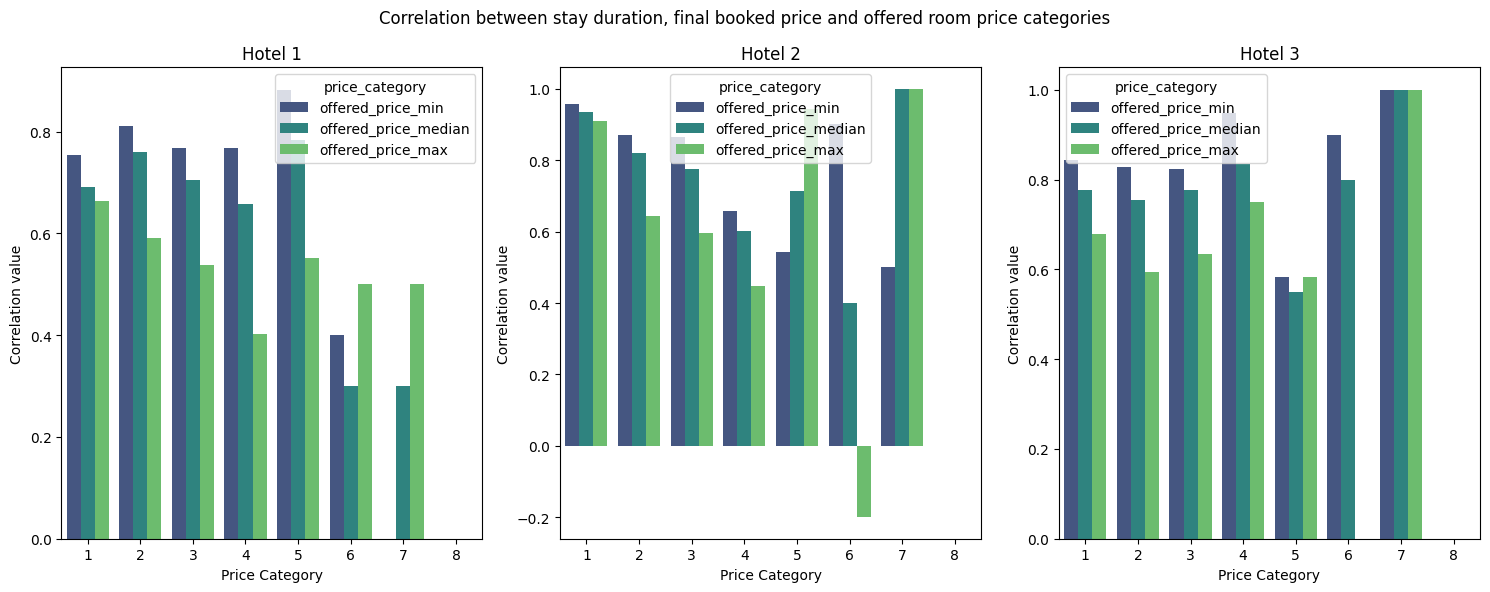

In [186]:
# convert to tidy format
df_tidy1 = nights_corr1.reset_index().melt(id_vars="index", var_name="nights", value_name="value")
df_tidy1.rename(columns={"index": "price_category"}, inplace=True)
df_tidy2 = nights_corr2.reset_index().melt(id_vars="index", var_name="nights", value_name="value")
df_tidy2.rename(columns={"index": "price_category"}, inplace=True)
df_tidy3 = nights_corr3.reset_index().melt(id_vars="index", var_name="nights", value_name="value")
df_tidy3.rename(columns={"index": "price_category"}, inplace=True)

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15, 6))
sns.barplot(ax=ax1, data=df_tidy1, hue="price_category", y="value", x="nights", palette="viridis")
sns.barplot(ax=ax2, data=df_tidy2, hue="price_category", y="value", x="nights", palette="viridis")
sns.barplot(ax=ax3, data=df_tidy3, hue="price_category", y="value", x="nights", palette="viridis")
ax1.set_ylabel("Correlation value")
ax2.set_ylabel("Correlation value")
ax3.set_ylabel("Correlation value")
ax1.set_xlabel("Price Category")
ax2.set_xlabel("Price Category")
ax3.set_xlabel("Price Category")
ax1.set_title('Hotel 1')
ax2.set_title('Hotel 2')
ax3.set_title('Hotel 3')
fig.suptitle('Correlation between stay duration, final booked price and offered room price categories')
plt.tight_layout()

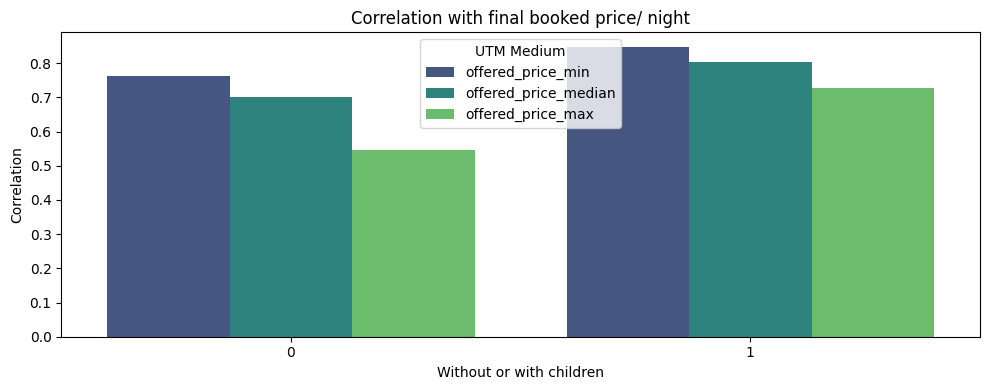

In [191]:
# Child presence correlation with final booked price/ night
df_tidy = if_children_corr.reset_index().melt(id_vars="index", var_name="if_children", value_name="value")
df_tidy.rename(columns={"index": "price_category"}, inplace=True)

plt.figure(figsize=(10, 4))
sns.barplot(
    data=df_tidy,
    hue="price_category",
    y="value",
    x="if_children",
    palette="viridis")

plt.title("Child presence correlation with final booked price/ night")
plt.ylabel("Correlation")
plt.xlabel("Without or with children")
plt.legend(title="UTM Medium")
plt.tight_layout()

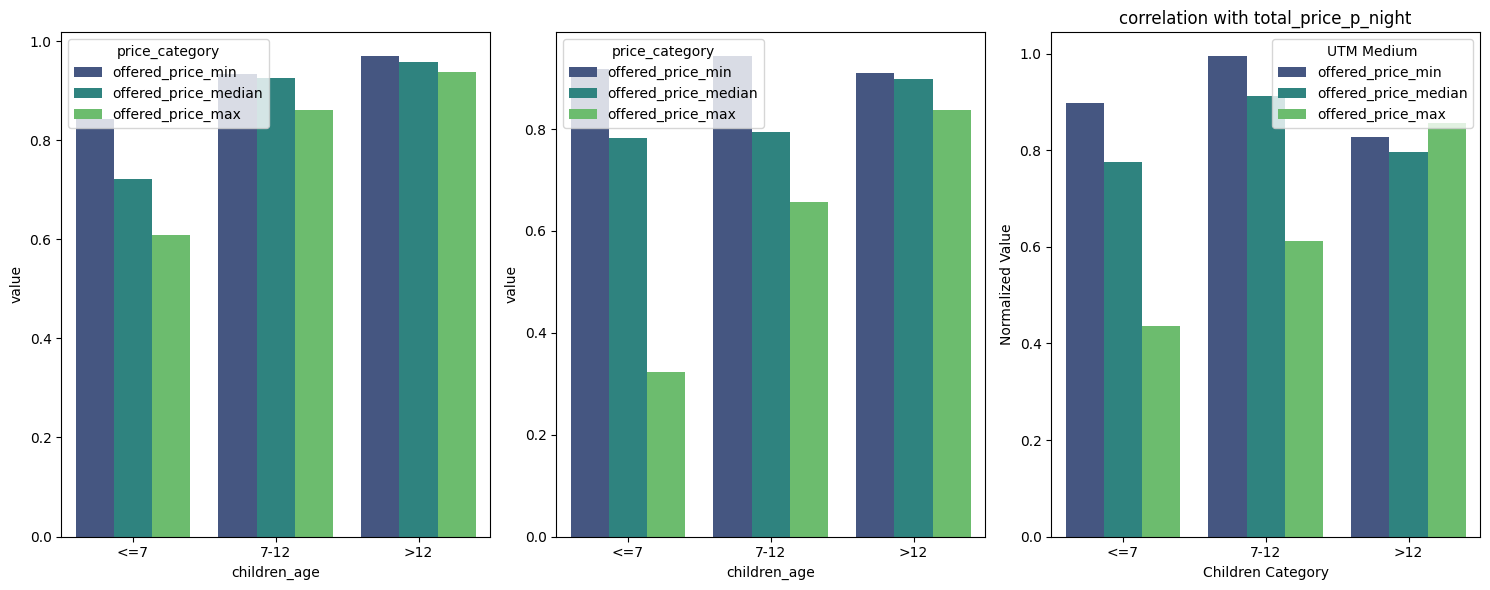

In [198]:
# to tidy format
df_tidy1 = children_age_corr1.reset_index().melt(id_vars="index", var_name="children_age", value_name="value")
df_tidy1.rename(columns={"index": "price_category"}, inplace=True)
df_tidy2 = children_age_corr2.reset_index().melt(id_vars="index", var_name="children_age", value_name="value")
df_tidy2.rename(columns={"index": "price_category"}, inplace=True)
df_tidy3 = children_age_corr3.reset_index().melt(id_vars="index", var_name="children_age", value_name="value")
df_tidy3.rename(columns={"index": "price_category"}, inplace=True)

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15, 6))
sns.barplot(ax=ax1, data=df_tidy1, hue="price_category", y="value", x="children_age", palette="viridis")
sns.barplot(ax=ax2, data=df_tidy2, hue="price_category", y="value", x="children_age", palette="viridis")
sns.barplot(ax=ax3, data=df_tidy3, hue="price_category", y="value", x="children_age", palette="viridis")
plt.title("correlation with total_price_p_night")
plt.ylabel("Normalized Value")
plt.xlabel("Children Category")
plt.legend(title="UTM Medium")
plt.tight_layout()

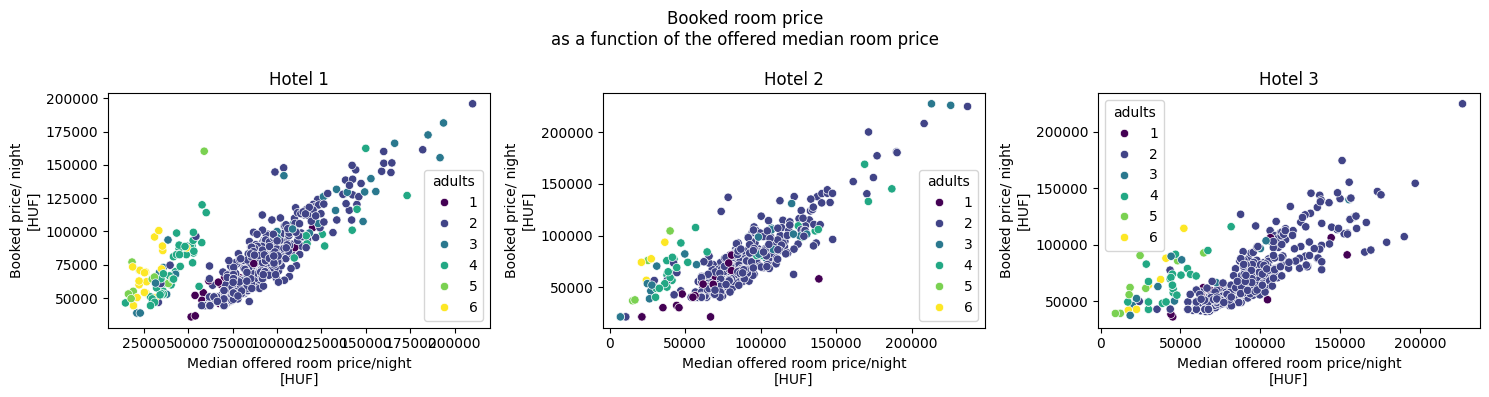

In [196]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,4))
sns.scatterplot(ax=ax1, data=hotel1, x='offered_price_median', y='total_price_p_night', hue='adults', palette='viridis')
sns.scatterplot(ax=ax2, data=hotel2, x='offered_price_median', y='total_price_p_night', hue='adults', palette='viridis')
sns.scatterplot(ax=ax3, data=hotel3, x='offered_price_median', y='total_price_p_night', hue='adults', palette='viridis')
fig.suptitle('Booked room price''\n''as a function of the offered median room price')
ax1.set_title('Hotel 1')
ax2.set_title('Hotel 2')
ax3.set_title('Hotel 3')
ax1.set_xlabel('Median offered room price/night''\n''[HUF]')
ax2.set_xlabel('Median offered room price/night''\n''[HUF]')
ax3.set_xlabel('Median offered room price/night''\n''[HUF]')
ax1.set_ylabel('Booked price/ night''\n''[HUF]')
ax2.set_ylabel('Booked price/ night''\n''[HUF]')
ax3.set_ylabel('Booked price/ night''\n''[HUF]')
fig.tight_layout()

In [203]:
# to tidy format
df_tidy1 = lead_time_corr1.reset_index().melt(id_vars="index", var_name="lead_time", value_name="value")
df_tidy1.rename(columns={"index": "price_category"}, inplace=True)
df_tidy2 = lead_time_corr2.reset_index().melt(id_vars="index", var_name="lead_time", value_name="value")
df_tidy2.rename(columns={"index": "price_category"}, inplace=True)
df_tidy3 = lead_time_corr3.reset_index().melt(id_vars="index", var_name="lead_time", value_name="value")
df_tidy3.rename(columns={"index": "price_category"}, inplace=True)

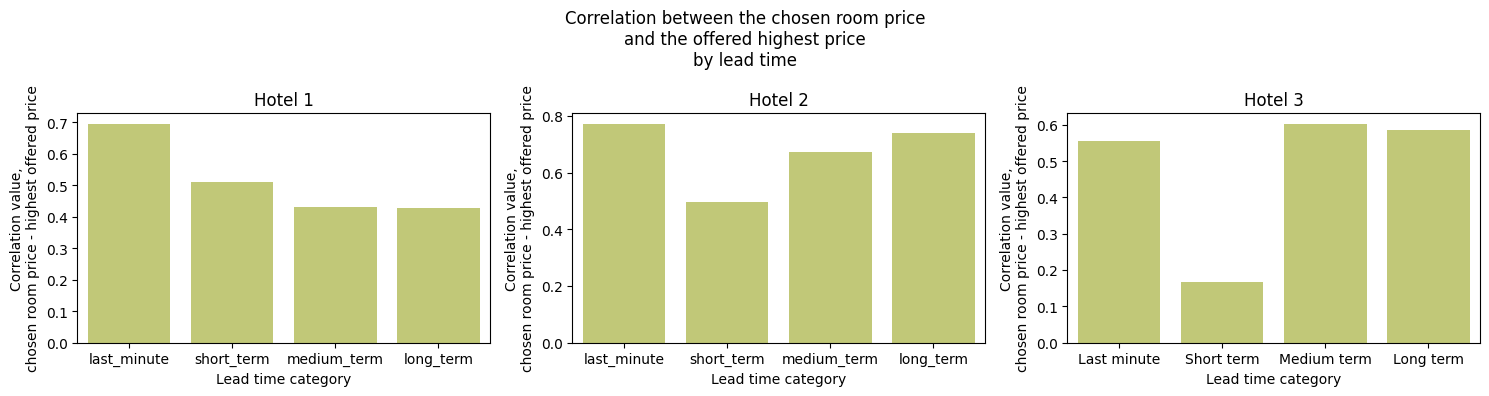

In [205]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,4))
sns.barplot(ax=ax1, data=df_tidy1[df_tidy1['price_category']=='offered_price_max'], hue="price_category", y="value", x="lead_time", palette=custom_palette, legend=False)
sns.barplot(ax=ax2, data=df_tidy2[df_tidy2['price_category']=='offered_price_max'], hue="price_category", y="value", x="lead_time", palette=custom_palette, legend=False)
sns.barplot(ax=ax3, data=df_tidy3[df_tidy3['price_category']=='offered_price_max'], hue="price_category", y="value", x="lead_time", palette=custom_palette, legend=False)
fig.suptitle("Correlation between the chosen room price""\n""and the offered highest price""\n""by lead time")
ax1.set_title('Hotel 1')
ax2.set_title('Hotel 2')
ax3.set_title('Hotel 3')
ax1.set_ylabel("Correlation value,""\n""chosen room price - highest offered price")
ax2.set_ylabel("Correlation value,""\n""chosen room price - highest offered price")
ax3.set_ylabel("Correlation value,""\n""chosen room price - highest offered price")
ax1.set_xlabel("Lead time category")
ax2.set_xlabel("Lead time category")
ax3.set_xlabel("Lead time category")
plt.xticks(ticks=['last_minute','short_term','medium_term','long_term'],labels=['Last minute', 'Short term', 'Medium term', 'Long term'])
fig.tight_layout()

### Check what does Willingness to pay (WTP) depend on

In [206]:
# calculate willingness to pay - wtp
wtp = df[['hotel_id','arrival','total_price_p_night','upsell_total_price']].groupby(by=['hotel_id','arrival']).median().reset_index().dropna()
wtp.head()

hotel_id    arrival  total_price_p_night  upsell_total_price
2  hotel_1 2024-09-20         87975.000000                 0.0
3  hotel_1 2024-09-21         86935.550000                 0.0
4  hotel_1 2024-09-22         67104.000000                 0.0
5  hotel_1 2024-09-23         71533.890000                 0.0
6  hotel_1 2024-09-24         78922.241933                 0.0

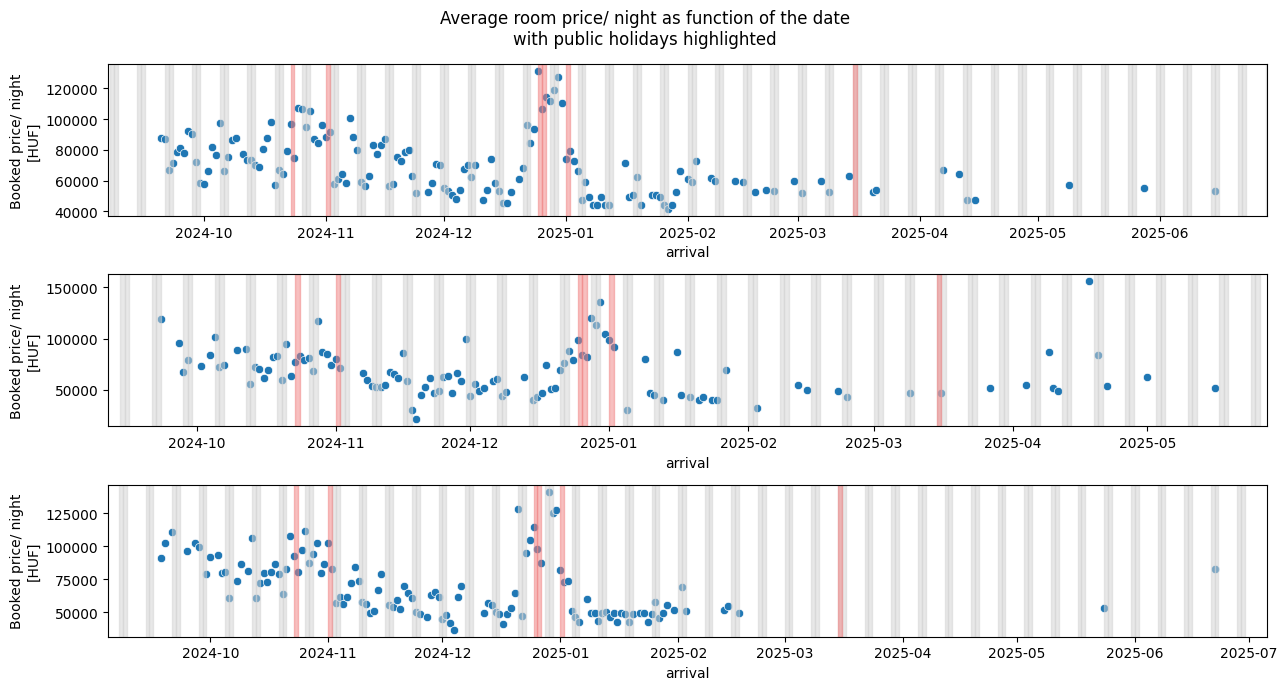

In [216]:
# mean room price as function of the date
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(13,7))
sns.scatterplot(ax=ax1, data=wtp[(wtp['hotel_id']=='hotel_1') & (wtp['arrival']<'2025-07-01')], x='arrival', y='total_price_p_night' )
sns.scatterplot(ax=ax2, data=wtp[(wtp['hotel_id']=='hotel_2') & (wtp['arrival']<'2025-07-01')], x='arrival', y='total_price_p_night' )
sns.scatterplot(ax=ax3, data=wtp[(wtp['hotel_id']=='hotel_3') & (wtp['arrival']<'2025-07-01')], x='arrival', y='total_price_p_night' )

# highlight weekends
start_date = pd.to_datetime('2024-09-01')  # Adjust based on your data range
end_date = pd.to_datetime('2025-07-01')
current_date = start_date

while current_date <= end_date:
    if current_date.weekday() >= 5:  # Saturday (5) and Sunday (6)
        ax1.axvspan(current_date, current_date + timedelta(days=1), color='lightgrey', alpha=0.5, label='Weekend' if current_date == start_date else None)
        ax2.axvspan(current_date, current_date + timedelta(days=1), color='lightgrey', alpha=0.5, label='Weekend' if current_date == start_date else None)
        ax3.axvspan(current_date, current_date + timedelta(days=1), color='lightgrey', alpha=0.5, label='Weekend' if current_date == start_date else None)
    current_date += timedelta(days=1)

# highlight public holidays
for holiday in public_holidays:
    if start_date <= holiday <= end_date:
        ax1.axvspan(holiday, holiday + timedelta(days=1), color='lightcoral', alpha=0.5, label='Public Holiday' if holiday == public_holidays[0] else None)
        ax2.axvspan(holiday, holiday + timedelta(days=1), color='lightcoral', alpha=0.5, label='Public Holiday' if holiday == public_holidays[0] else None)
        ax3.axvspan(holiday, holiday + timedelta(days=1), color='lightcoral', alpha=0.5, label='Public Holiday' if holiday == public_holidays[0] else None)

ax1.set_ylabel('Booked price/ night''\n''[HUF]')
ax2.set_ylabel('Booked price/ night''\n''[HUF]')
ax3.set_ylabel('Booked price/ night''\n''[HUF]')
fig.suptitle('Average room price/ night as function of the date''\n''with public holidays highlighted')
fig.tight_layout()

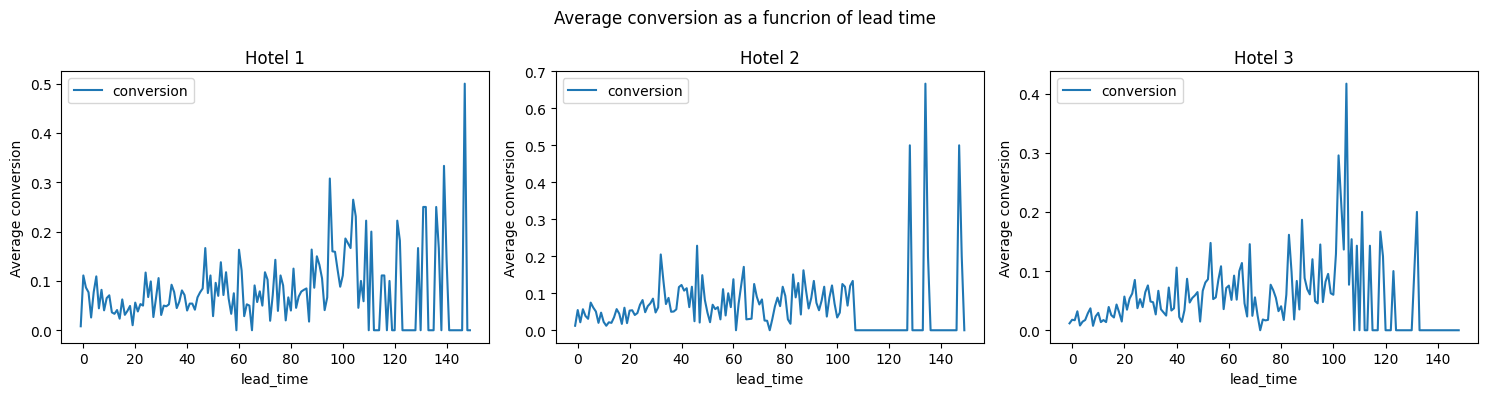

In [219]:
# average conversion as a funcrion of lead time
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))
hotel1[hotel1['lead_time']<150][['lead_time','conversion']].groupby(by='lead_time').mean().plot(ax=ax1)
hotel2[hotel2['lead_time']<150][['lead_time','conversion']].groupby(by='lead_time').mean().plot(ax=ax2)
hotel3[hotel3['lead_time']<150][['lead_time','conversion']].groupby(by='lead_time').mean().plot(ax=ax3)
fig.suptitle('Average conversion as a funcrion of lead time')
ax1.set_title('Hotel 1')
ax2.set_title('Hotel 2')
ax3.set_title('Hotel 3')
ax1.set_ylabel('Average conversion')
ax2.set_ylabel('Average conversion')
ax3.set_ylabel('Average conversion')
fig.tight_layout()

In [236]:
# average conversion as a funcrion of lead time in a table
df[['hotel_id','conversion','rfm_duration_score']].groupby(by=['hotel_id','rfm_duration_score']).mean()

conversion
hotel_id rfm_duration_score            
hotel_1  1                     0.039979
         2-3                   0.035649
         4-9                   0.048000
hotel_2  1                     0.038440
         2-3                   0.034095
         4-9                   0.034623
hotel_3  1                     0.031059
         2-3                   0.030881
         4-9                   0.029630

In [222]:
# connect occupancy data with lead time and average vonversion rate
occupancy_hotel = occupancy[['subject_date','fill_rate','days_until_stay','hotel_id']].groupby(by=['subject_date','hotel_id']).mean().reset_index().join(
    df_unique[['lead_time','conversion']].groupby(by='lead_time').mean(), on='days_until_stay', how='inner')
occupancy_hotel.head()

subject_date hotel_id  fill_rate  days_until_stay  conversion
42   2024-10-02  hotel_1  39.049290             -1.0     0.01011
43   2024-10-02  hotel_2  61.083871             -1.0     0.01011
44   2024-10-02  hotel_3  63.808452             -1.0     0.01011
45   2024-10-03  hotel_1  35.415968              0.0     0.05868
46   2024-10-03  hotel_2  75.174194              0.0     0.05868

Text(0.5, 1.0, 'Average conversion rate as a function of lead time')

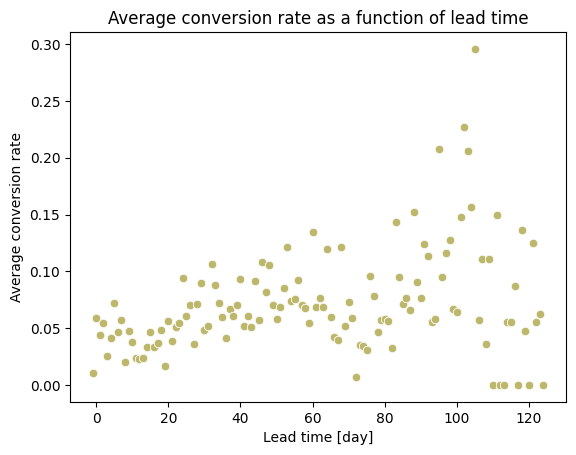

In [223]:
sns.scatterplot(data=occupancy_hotel[occupancy_hotel['days_until_stay']<125], x='days_until_stay', y='conversion', color='darkkhaki')
plt.xlabel('Lead time [day]')
plt.ylabel('Average conversion rate')
plt.title('Average conversion rate as a function of lead time')

Text(0.5, 1.0, 'Offered room price/night bands with booked room price/ night during the observed time period (for every hotel)')

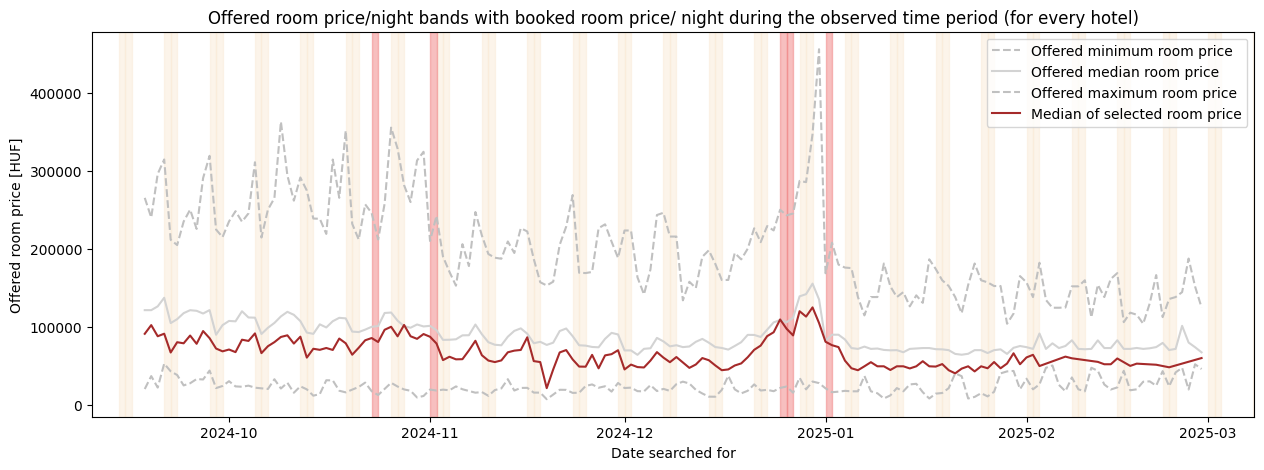

In [226]:
# for every hotel

fig, (ax1) = plt.subplots(1,1,figsize=(15,5))

sns.lineplot(ax=ax1, data=df[df['arrival']<'2025-03-01'][['arrival','offered_price_min']].groupby(by='arrival').min().reset_index(), x='arrival', y='offered_price_min', ci=None, color='silver', linestyle='--')
sns.lineplot(ax=ax1, data=df[df['arrival']<'2025-03-01'][['arrival','offered_price_median']].groupby(by='arrival').median().reset_index(), x='arrival', y='offered_price_median', ci=None, color='lightgrey')
sns.lineplot(ax=ax1, data=df[df['arrival']<'2025-03-01'][['arrival','offered_price_max']].groupby(by='arrival').max().reset_index(), x='arrival', y='offered_price_max', ci=None, color='silver', linestyle='--')
sns.lineplot(ax=ax1, data=df[df['arrival']<'2025-03-01'][['arrival','total_price_p_night']].groupby(by='arrival').median().reset_index(), x='arrival', y='total_price_p_night', ci=None, color='brown')
ax1.legend(['Offered minimum room price','Offered median room price','Offered maximum room price','Median of selected room price'])

# highlight weekends
start_date = pd.to_datetime('2024-09-01')
end_date = pd.to_datetime('2025-07-01')
current_date = start_date

while current_date <= end_date:
    if current_date.weekday() >= 5:
        ax1.axvspan(current_date, current_date + timedelta(days=1), color='antiquewhite', alpha=0.5, label='Weekend' if current_date == start_date else None)
    current_date += timedelta(days=1)

# highlight public holidays
for holiday in public_holidays:
    if start_date <= holiday <= end_date:
        ax1.axvspan(holiday, holiday + timedelta(days=1), color='lightcoral', alpha=0.5, label='Public Holiday' if holiday == public_holidays[0] else None)
        
plt.ylabel('Offered room price [HUF]')
plt.xlabel('Date searched for')
plt.title('Offered room price/night bands with booked room price/ night during the observed time period (for every hotel)')

In [227]:
# join median prices to the original dataframe for each hotel
merged = hotel1[['arrival','total_price_p_night']].join(hotel1[['arrival','offered_price_median']].groupby(by='arrival').median(), on='arrival', validate='m:1')
# Add the new column with adjusted logic
hotel1['higher_than_medium_price'] = np.where(
    merged['total_price_p_night'].isna(),  # condition if total_price_p_night is NaN
    float("NAN"),  # set False when total_price_p_night is NaN
    merged['total_price_p_night'] > merged['offered_price_median']  # Original condition
)

merged = hotel2[['arrival','total_price_p_night']].join(hotel2[['arrival','offered_price_median']].groupby(by='arrival').median(), on='arrival', validate='m:1')
hotel2['higher_than_medium_price'] = np.where(
    merged['total_price_p_night'].isna(),  # condition if total_price_p_night is NaN
    float("NAN"),  # set False when total_price_p_night is NaN
    merged['total_price_p_night'] > merged['offered_price_median']  # Original condition
)

merged = hotel3[['arrival','total_price_p_night']].join(hotel3[['arrival','offered_price_median']].groupby(by='arrival').median(), on='arrival', validate='m:1')
hotel3['higher_than_medium_price'] = np.where(
    merged['total_price_p_night'].isna(),  # condition if total_price_p_night is NaN
    float("NAN"),  # set False when total_price_p_night is NaN
    merged['total_price_p_night'] > merged['offered_price_median']  # Original condition
)

In [ ]:
# when the booked price are higher then the median offered price? - what factors might influence these decisions?

# hotel 1
hotel1[['nights', 'adults', 'children', 'if_children','children_age_mean','sel_num_of_rooms',
        'upsell_total_price','lead_time','higher_than_medium_price']].groupby(by='higher_than_medium_price').mean()

nights    adults  children  if_children  \
higher_than_medium_price                                              
0.0                       2.625000  2.360937  0.387500     0.234375   
1.0                       2.402597  2.500000  1.422078     0.798701   

                          children_age_mean  sel_num_of_rooms  \
higher_than_medium_price                                        
0.0                                7.015815          1.239062   
1.0                                9.402778          1.058442   

                          upsell_total_price  lead_time  
higher_than_medium_price                                 
0.0                               961.321799  53.753125  
1.0                              1036.688312  54.629870

In [228]:
# hotel 2
hotel2[['nights', 'adults', 'children', 'if_children','children_age_mean','sel_num_of_rooms',
        'upsell_total_price','lead_time','higher_than_medium_price']].groupby(by='higher_than_medium_price').mean()

nights    adults  children  if_children  \
higher_than_medium_price                                              
0.0                       2.501425  2.082621  0.270655     0.210826   
1.0                       2.317308  2.365385  0.990385     0.576923   

                          children_age_mean  sel_num_of_rooms  \
higher_than_medium_price                                        
0.0                                6.787671          1.131054   
1.0                                8.551724          1.067308   

                          upsell_total_price  lead_time  
higher_than_medium_price                                 
0.0                               964.709741  51.094017  
1.0                               434.626865  59.288462

In [229]:
# hotel 3
hotel3[['nights', 'adults', 'children', 'if_children','children_age_mean','sel_num_of_rooms',
        'upsell_total_price','lead_time','higher_than_medium_price']].groupby(by='higher_than_medium_price').mean()

nights    adults  children  if_children  \
higher_than_medium_price                                              
0.0                       2.494357  2.214447  0.144470     0.099323   
1.0                       2.418605  2.069767  1.255814     0.720930   

                          children_age_mean  sel_num_of_rooms  \
higher_than_medium_price                                        
0.0                                5.807692          1.155756   
1.0                               10.026882          1.000000   

                          upsell_total_price  lead_time  
higher_than_medium_price                                 
0.0                              2104.883215  55.652370  
1.0                              1234.651163  52.860465

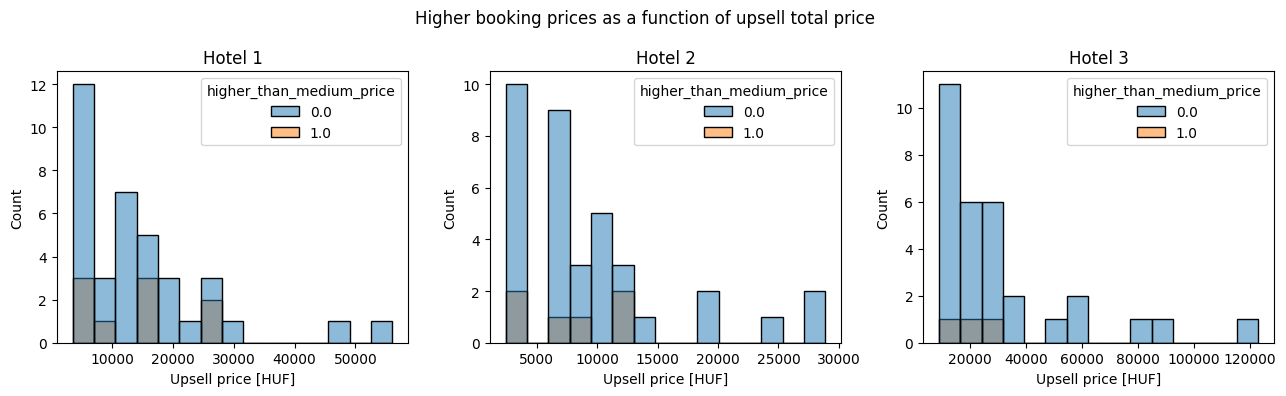

In [236]:
# are there correlation between the booked room price and the upsell price?
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(13,4))
sns.histplot(ax=ax1, data=hotel1[hotel1['upsell_total_price']>0], x='upsell_total_price',hue='higher_than_medium_price', bins=15)
sns.histplot(ax=ax2, data=hotel2[hotel2['upsell_total_price']>0], x='upsell_total_price',hue='higher_than_medium_price', bins=15)
sns.histplot(ax=ax3, data=hotel3[hotel3['upsell_total_price']>0], x='upsell_total_price',hue='higher_than_medium_price', bins=15)
fig.suptitle('Higher booking prices as a function of upsell total price')
ax1.set_xlabel('Upsell price [HUF]')
ax2.set_xlabel('Upsell price [HUF]')
ax3.set_xlabel('Upsell price [HUF]')
ax1.set_title('Hotel 1')
ax2.set_title('Hotel 2')
ax3.set_title('Hotel 3')
fig.tight_layout()

In [237]:
# hotel 1
print(hotel2[['utm_medium', 'higher_than_medium_price']].groupby(by='utm_medium').mean())
print(hotel2[['utm_source', 'higher_than_medium_price']].groupby(by='utm_source').mean())

            higher_than_medium_price
utm_medium                          
(not set)                   0.321429
cpc                         0.214844
ct                          0.000000
direct                      0.260274
email                       0.000000
offline                     1.000000
organic                     0.219512
other                            NaN
referral                    0.250000
            higher_than_medium_price
utm_source                          
bing                        0.176471
facebook                    0.500000
google                      0.213166
instagram                   1.000000
na                          0.321429
other                       0.244186


In [238]:
# hotel 2
print(hotel2[['utm_medium', 'higher_than_medium_price']].groupby(by='utm_medium').mean())
print(hotel2[['utm_source', 'higher_than_medium_price']].groupby(by='utm_source').mean())


            higher_than_medium_price
utm_medium                          
(not set)                   0.321429
cpc                         0.214844
ct                          0.000000
direct                      0.260274
email                       0.000000
offline                     1.000000
organic                     0.219512
other                            NaN
referral                    0.250000
            higher_than_medium_price
utm_source                          
bing                        0.176471
facebook                    0.500000
google                      0.213166
instagram                   1.000000
na                          0.321429
other                       0.244186


In [239]:
# hotel 3
print(hotel3[['utm_medium', 'higher_than_medium_price']].groupby(by='utm_medium').mean())
print(hotel3[['utm_source', 'higher_than_medium_price']].groupby(by='utm_source').mean())

            higher_than_medium_price
utm_medium                          
(not set)                   0.073171
cpc                         0.103321
ct                          0.000000
direct                      0.075000
email                       0.000000
offline                     0.000000
organic                     0.075949
other                            NaN
referral                    0.000000
            higher_than_medium_price
utm_source                          
bing                        0.100000
facebook                    0.142857
google                      0.096677
instagram                        NaN
na                          0.073171
other                       0.061856
